# RoadLane Detection Using Computer Vision

---------------------------------------------------


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
import utils; reload(utils)
from utils import *
%matplotlib inline

In [2]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Camera Caliberation

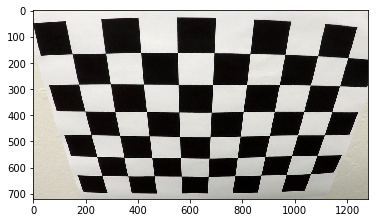

In [3]:
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

"""
glob — Unix style pathname pattern expansion.
The glob module finds all the pathnames matching a specified pattern 
according to the rules used by the Unix shell, although results 
are returned in arbitrary order.
"""
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

In [4]:
cx = 9
cy = 6

In [5]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the positions of internal corners of the supplied chessboard image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [6]:
def showChessboardCorners(img, nx, ny, ret, corners):
    
    """
    Renders the detected chessboard corners.
    Draws the chessboard corners of a given image.
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners(corners – Array of detected corners, the output of findChessboardCorners.) should represent the results from cv2.findChessboardCorners()
    
    The function draws individual chessboard corners detected either as red circles 
    if the board was not found, or as colored corners connected with lines if the board was found.
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    '''plt.axis('off')'''
    plt.imshow(img)

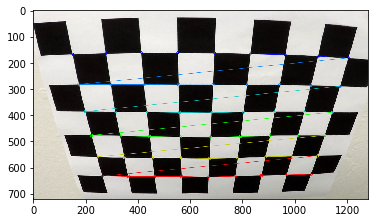

In [7]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

### Image Undistortion

In [8]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same 
    camera. nx and ny parameters respectively indicate the number of inner corners in the x and y 
    directions.
    
    """
    
    # Arrays to store object points and image points from all the images.
    objpts = []  # 3d point in real world space
    imgpts = []  # 2d points in image plane(These image points are locations where two black squares
    
    #touch each other in chess boards).
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we 
    # assume a flat surface)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    
    objp = np.zeros((nx * ny, 3), np.float32) # pattern 9*6 grid

    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            #corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            
            objpts.append(objp)
    
    
    return objpts, imgpts

In [9]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [10]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    """
    '''returns the camera matrix, distortion coefficients, rotation and translation vectors etc'''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts,to_grayscale(img).shape[::-1], None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [11]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)


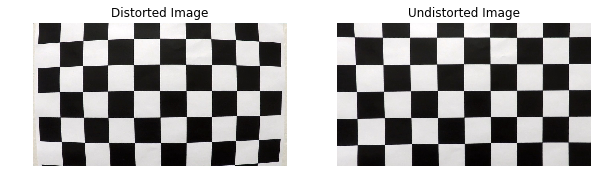

In [12]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()


#### Undistorting Test Images

In [26]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [27]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [28]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [29]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

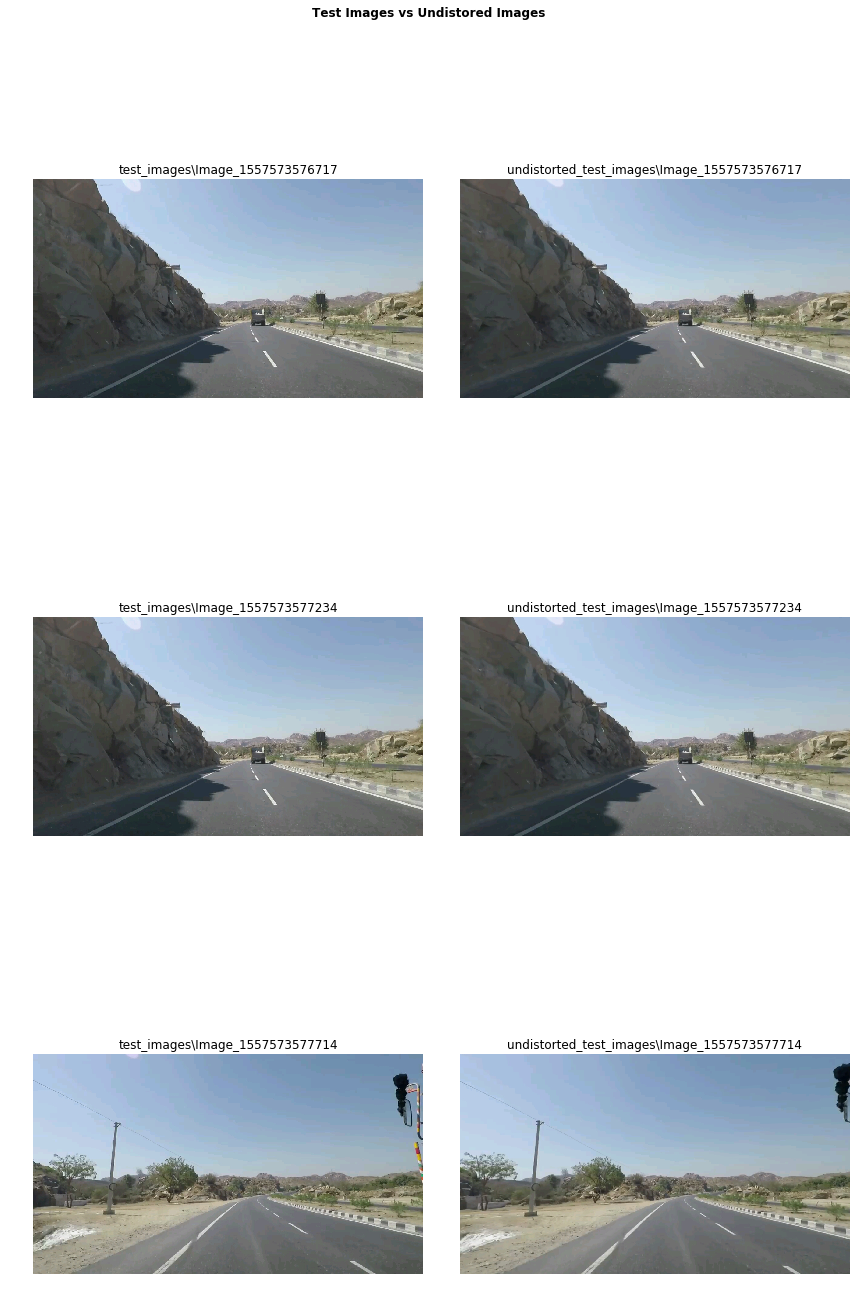

In [30]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

## Thresholding

To better detect the lines, and make it easier to find the polynomial that best describes the left and right lanes .

In [31]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [32]:
test_img_path = test_imgs_paths[1]
test_img = load_image(test_img_path)
print(test_img.shape)
undistorted_test_img = undistort_image(test_img, opts, ipts)

(720, 1280, 3)


### Color Thresholding

Trying out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [33]:
#np.asarray() to convert image to numpy array
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [34]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])
'''
V ==> Amt of light
L ==> Amt of white
'''

'\nV ==> Amt of light\nL ==> Amt of white\n'

In [35]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [36]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [37]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

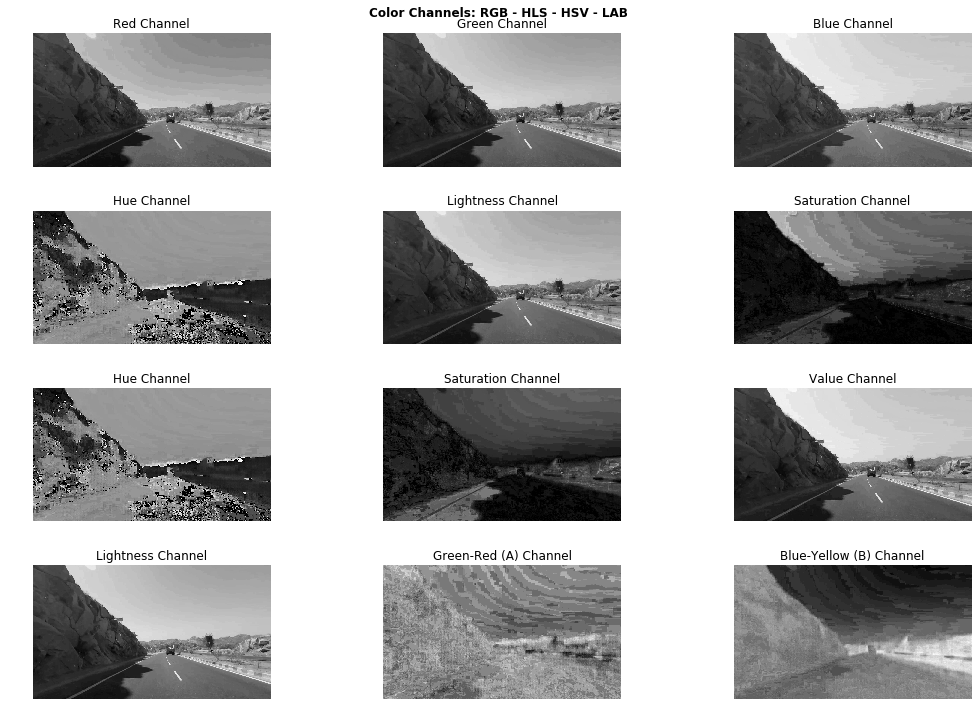

In [38]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

In [39]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

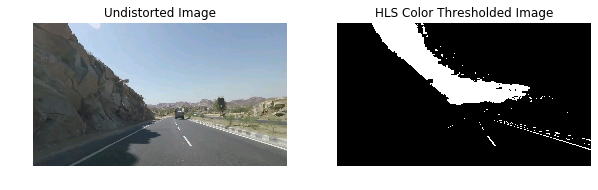

In [40]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

### Gradient Thresholding Via Sobel

In [41]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [42]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal 
    or vertical direction.
    The function also computes the asbolute value of the resulting matrix and applies a 
    binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [43]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [44]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

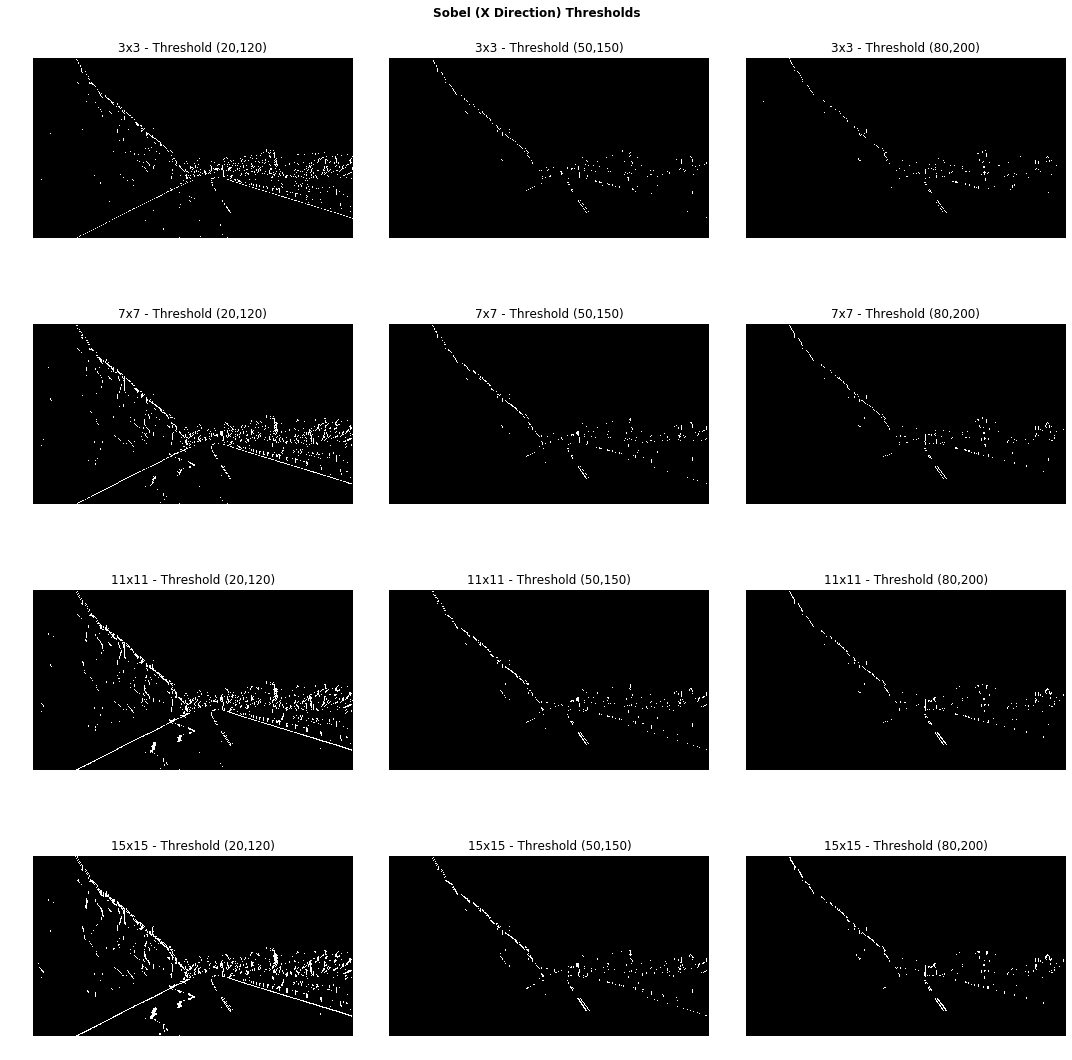

In [45]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

In [46]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [47]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [48]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

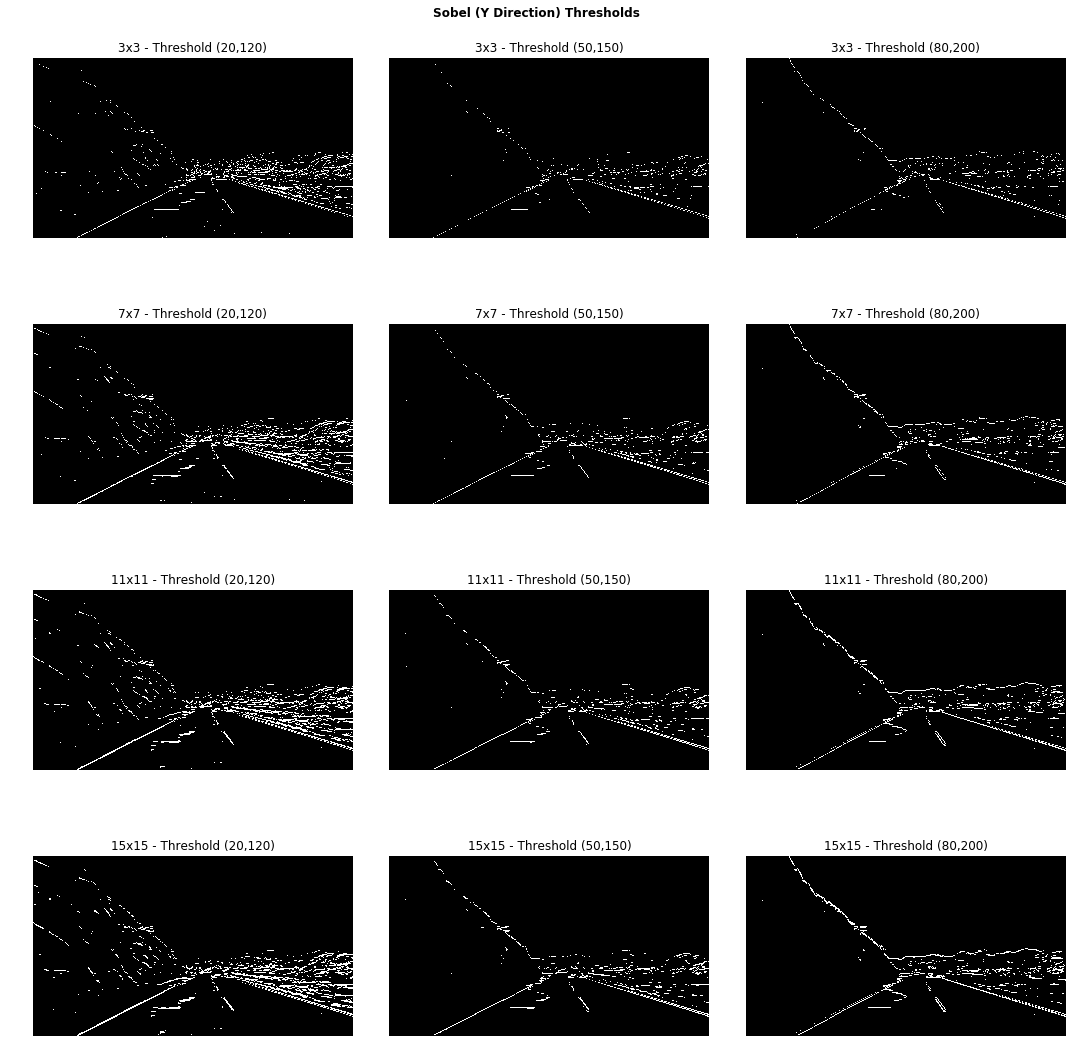

In [49]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In [50]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [51]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [52]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [53]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


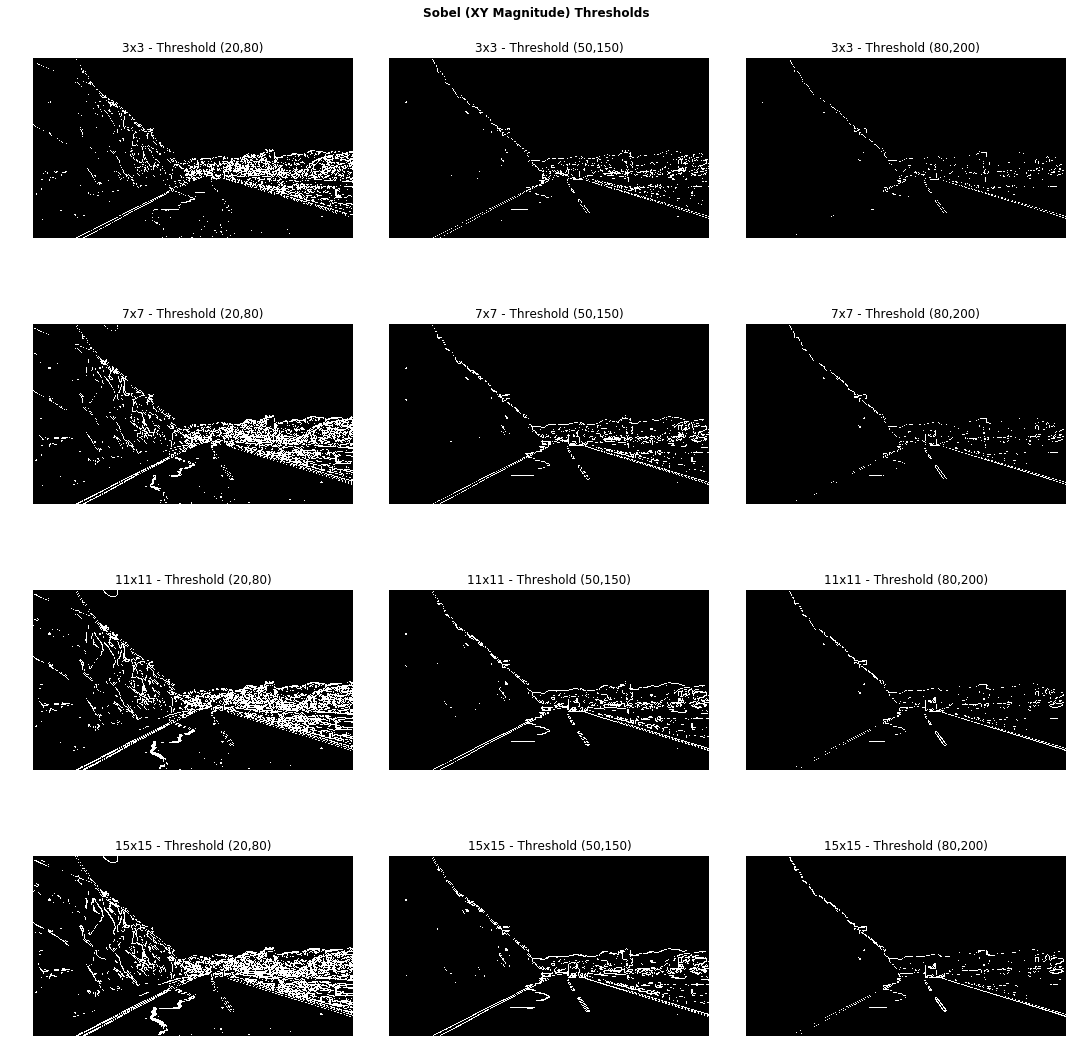

In [54]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

In [55]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

In [56]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [57]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [58]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [59]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [60]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

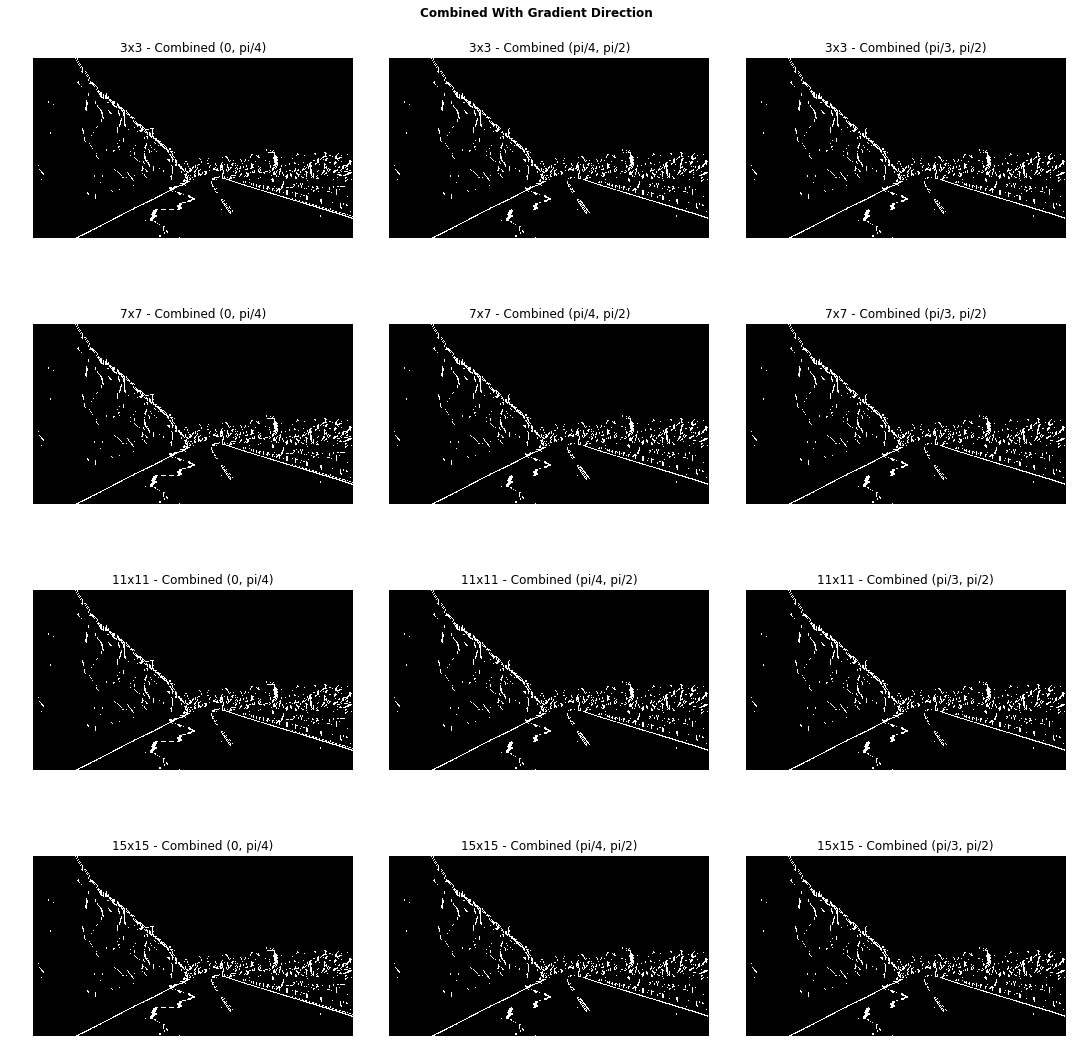

In [61]:

show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

In [62]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

### Combining Color And Gradient (Sobel) Thresholds

In [63]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [64]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [65]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

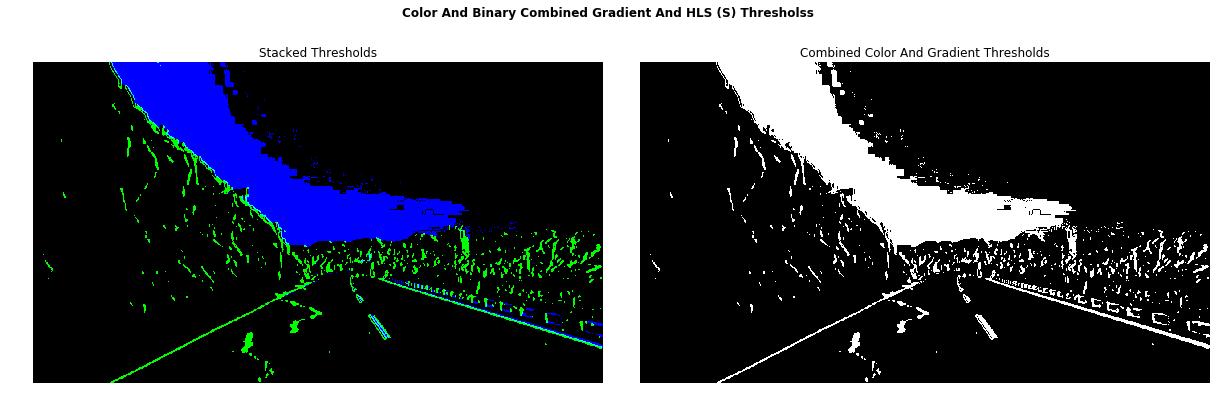

In [66]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)


# Perspective Transform

Defining a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

<b>For perspective transformation, you need a 3x3 transformation matrix. Straight lines will remain straight even after the transformation. To find this transformation matrix, you need 4 points on the input image and corresponding points on the output image. Among these 4 points, 3 of them should not be collinear. Then transformation matrix can be found by the function cv2.getPerspectiveTransform. Then apply cv2.warpPerspective with this 3x3 transformation matrix.</b>

In [70]:
import imutils

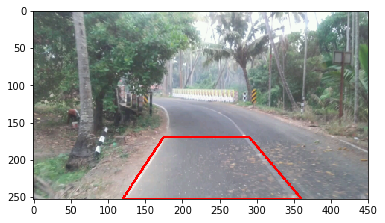

In [90]:
copy_combined =load_image("trim3.jpg")
copy_combined = imutils.resize(copy_combined,width=450)
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[120,bottom_px],[175,170],[290,170], [360, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 2)
plt.axis('on')
plt.imshow(copy_combined)

In [73]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    #Calculates a perspective transform from four pairs of the corresponding points.
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [74]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #INTER_LINEAR , a bilinear interpolation method, interpolating is done on both x and y axes
    return warped

In [75]:
src_pts = pts.astype(np.float32)

dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)


In [76]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

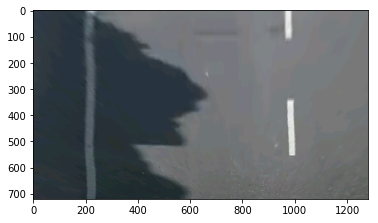

In [77]:
plt.imshow(test_img_persp_tr)

In [78]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

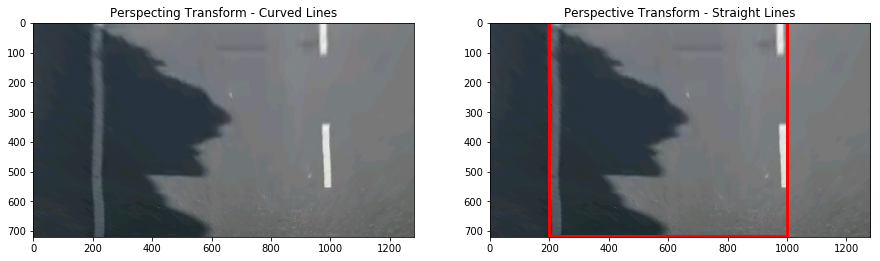

In [79]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[1])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

In [80]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

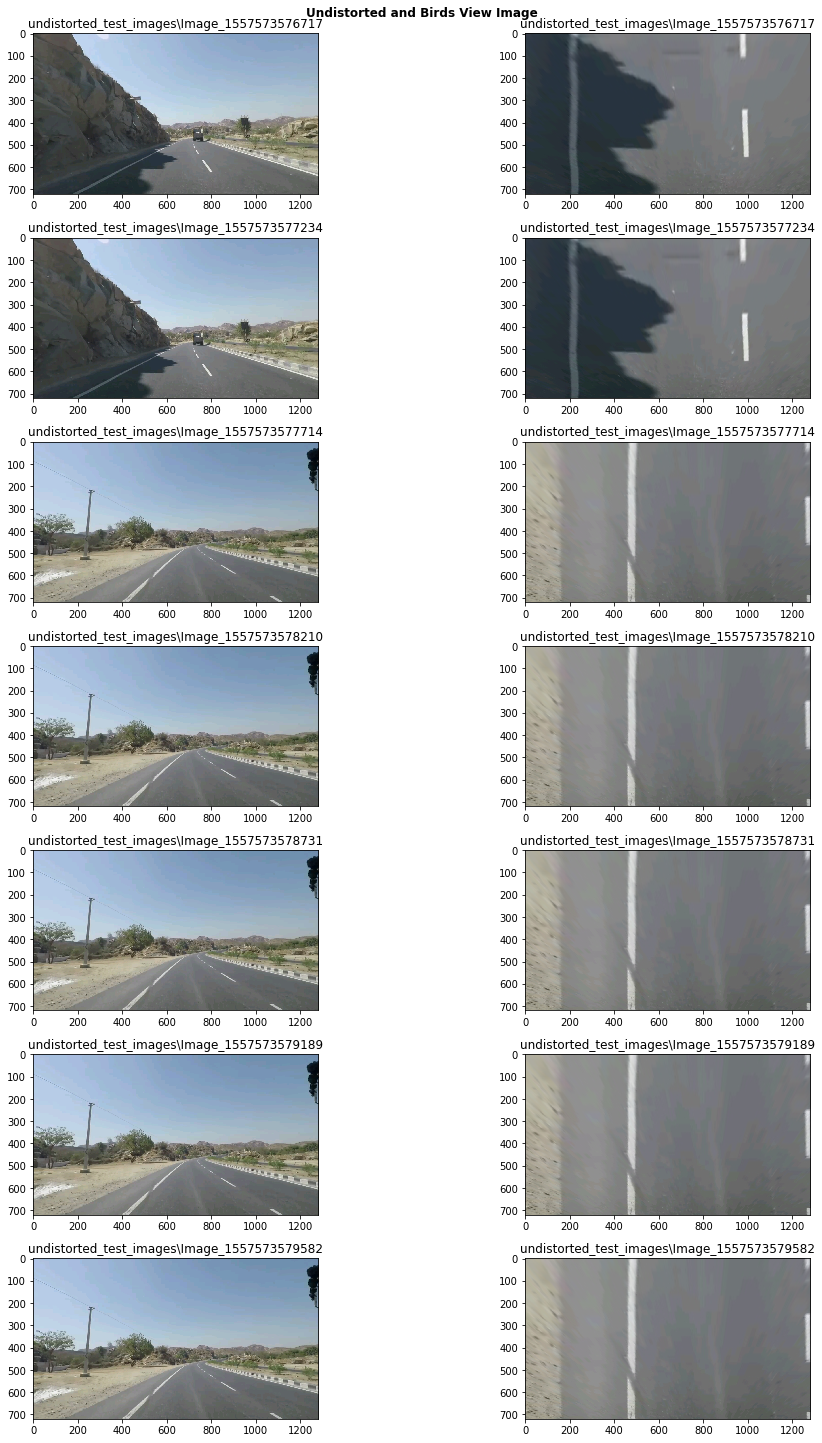

In [81]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

In [82]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [83]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [84]:

test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [85]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [86]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

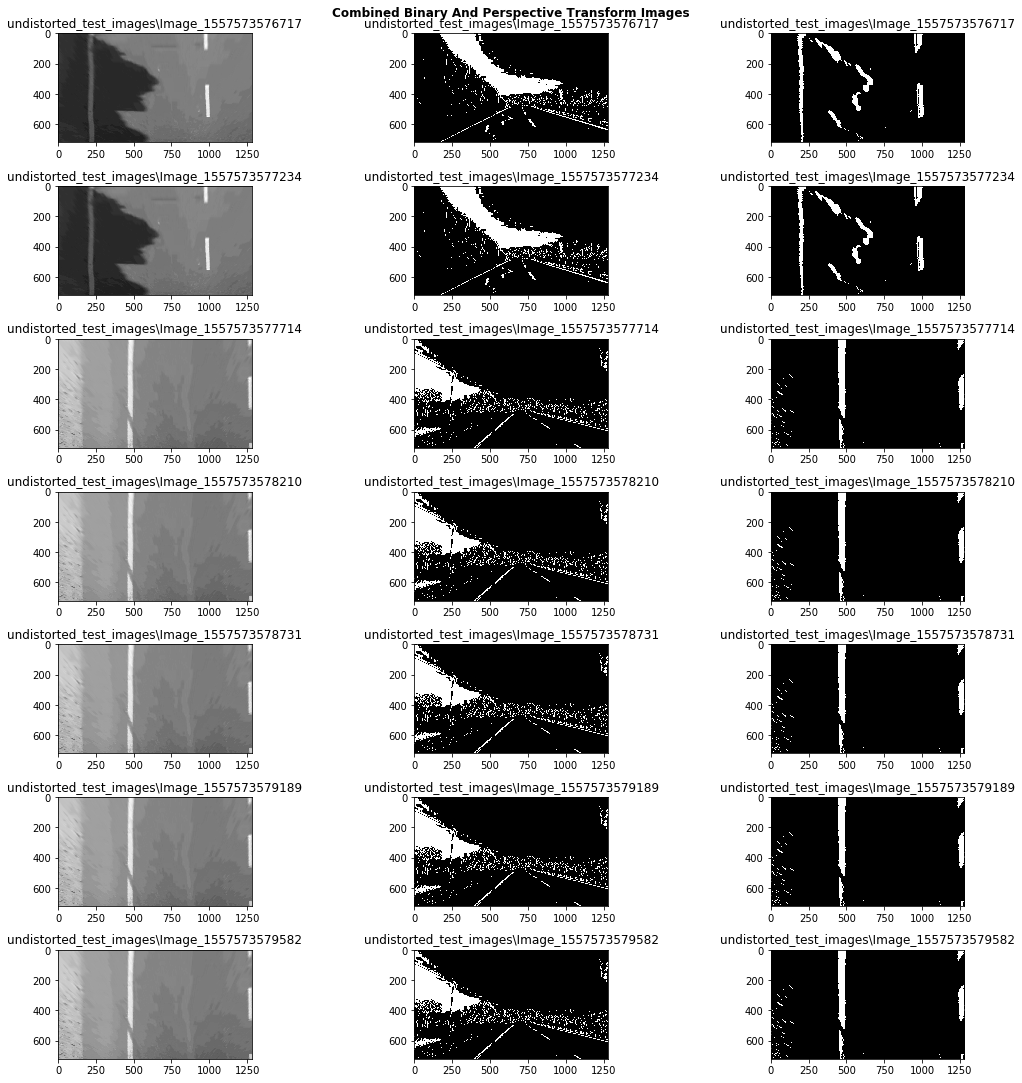

In [87]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

## Finding and fitting the lane line pixels

To find the lane lines we'll use the histogram and window technique that was described in the lectures.

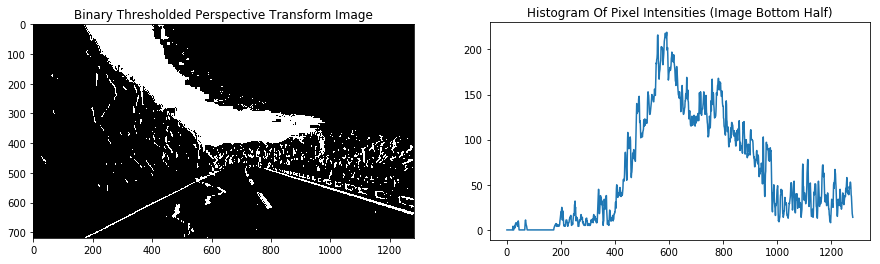

In [92]:
img_example = test_imgs_combined_binary_and_psp_tr[1][1]

histogram = np.sum(img_example[img_example.shape[0]//3:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("on")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

In [93]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [94]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [95]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [96]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)
    used parameters:-
        slidingwindows_per_line       =  20
        
        # Set the width of the windows +/- margin
        sliding_window_half_width     =  100
        
        # Set minimum number of pixels found to recenter window
        sliding_window_recenter_thres =  50
        
    
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        """
        ym_per_pix = 30/720 # meters per pixel in y dimension
        # xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # ym_per_pix = 3.0/100 # meters per pixel in y dimension, lane line is 10 ft = 3 meters
        xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
        """
        
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        plt.imsave("out/undist_img.jpg",undist_img)
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        plt.imsave("out/thres_img.jpg",thres_img)
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        plt.imsave("out/thres_img_psp.jpg",thres_img_psp)
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp,undist_img, ll, rl)        
        plt.imsave("out/drawn_lines.jpg",drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp,undist_img, ll, rl)
        plt.imsave("out/drawn_lines_regions.jpg",drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl) 
        plt.imsave("out/drawn_lane_area.jpg", drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        plt.imsave("out/drawn_hotspots.jpg", drawn_hotspots)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        plt.imsave("out/final_img.jpg", final_img)
        
        
        
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, undist_img,left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3) 
        # Create an image to draw the lines on
        warp_zero1 = np.zeros_like(warped_img).astype(np.uint8)
        color_warp1 = np.dstack((warp_zero1, warp_zero1, warp_zero1))
        # Warp the blank back to original image space using inverse perspective matrix (Minv
         # Draw the lane onto the warped blank image
        cv2.polylines(color_warp1, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(color_warp1, pts_right, False, (255, 140,0), 5)
        
        
        
        newwarp = cv2.warpPerspective(color_warp1, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        plt.imsave("out\warpedlines.jpg",result)
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img,undist_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        # Create an image to draw the lines on
        warp_zero1 = np.zeros_like(warped_img).astype(np.uint8)
        color_warp1 = np.dstack((warp_zero1, warp_zero1, warp_zero1))
        # Warp the blank back to original image space using inverse perspective matrix (Minv
         # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp1, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(color_warp1, np.int_([right_line_pts]), (0, 255, 0))
        
        newwarp = cv2.warpPerspective(color_warp1, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        plt.imsave("out\warpedregion.jpg",result)
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine
        instances for the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//3:,:], axis=0)
        
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//3)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)
    
   

In [97]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [99]:
test_img_path = test_imgs_paths[1]
test_img = load_image(test_img_path)
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14824.498744031755
Left Curvature   Right Curvature  Center Alignment 
5579.2597m       10180.9420m      0.0087m Right    


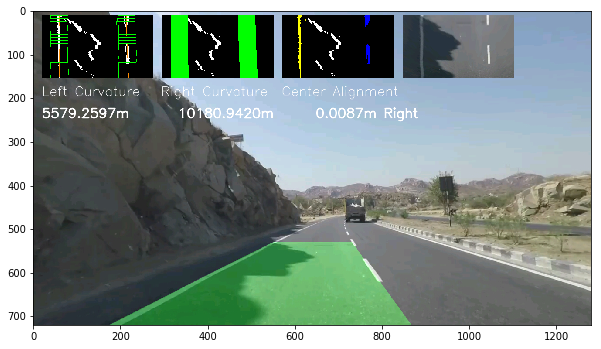

In [100]:
plt.figure(figsize=(10,10))
plt.imsave("img1rb.jpg",proc_img)
plt.imshow(proc_img)

In [106]:
from tkinter.ttk import *
from tkinter import *
from tkinter import filedialog
from PIL import Image,ImageTk 
from imageio import *
from tkinter.filedialog import askopenfilename
from imutils.video import FPS
from imutils.video import FileVideoStream
import time
import imutils

In [120]:


def inputImg():
    global panelA
    
    file = filedialog.askopenfilename()
    
    image = load_image(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)
    proc_img = ld.process_image(image)
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
        
    v.set("Image Selected")
def undistort():
    
    global panelA

    
    image = load_image("out/undist_img.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set("Undistorted Output ===>")   
def threshold():
    
    global panelA

    
    image = load_image("out/thres_img.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set("Thresholded Output ===>")  
def transform():
    
    global panelA

    
    image = load_image("out/thres_img_psp.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set("Transformed Output ===>")  
def linefit():
    
    global panelA

    
    image = load_image("out/drawn_lines.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set("Line Fitted Output ===>")  
        
def regionmark():
    
    global panelA

    
    image = load_image("out/drawn_lines_regions.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set("Region Marked Output ===>")     
def regionimg():
    
    global panelA

    
    image = load_image("out/warpedregion.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
        
    v.set("Lane line  Region Drawn ===>") 

def finaloutput():
    
    global panelA

    
    image = load_image("out/drawn_lane_area.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
        
    v.set("Final Output ===>") 
    
def linedrawn():
    
    global panelA

    
    image = load_image("out/warpedlines.jpg")
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=500,anchor=W,height=540,width=780)
    else:
        panelA.configure(image=image)
        panelA.image = image
        
    v.set("Lane Lines Drawn ===>") 
    
def combinedoutput():
    
    global panelA

    
    image = load_image("out/final_img.jpg")
    scale_percent = 70 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    image = Image.fromarray(image)
    image = ImageTk.PhotoImage(image)
    if panelA is None :
        panelA = Label(image=image)
        panelA.image = image
        panelA.place(x=500,y=450,anchor=W,height=510,width=720)
    else:
        panelA.configure(image=image)
        panelA.image = image
    v.set(" ")
def vplay():
    stream =  askopenfilename()
    ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)
    # import the necessary packages

    print("[INFO] starting video file thread...")
    fvs = FileVideoStream(stream).start()
    time.sleep(1.0)

    # start the FPS timer
    fps = FPS().start()

    # loop over frames from the video file stream
    while fvs.more():
        # grab the frame from the threaded video file stream, resize
        # it, and convert it to grayscale (while still retaining 3
        # channels)
        frame = fvs.read()
        print(frame.shape)
        frame = imutils.resize(frame, width=650)
        
        
        frame = ld.process_image(frame)
        frame = np.dstack([frame])
        #frame = np.dstack([frame, frame, frame])
        # display the size of the queue on the frame
       
        # show the frame and update the FPS counter
        print(frame.shape)
        cv2.imshow("Frame", frame)
        cv2.waitKey(1)
        fps.update()

    # stop the timer and display FPS information
    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

    # do a bit of cleanup
    cv2.destroyAllWindows()
    fvs.stop()

    
    
'''

def vplay():
    video_name =  askopenfilename()
    stream = cv2.VideoCapture(video_name)
    fps = FPS().start()
    while True:
        # grab the frame from the threaded video file stream
        (grabbed, frame) = stream.read()

        # if the frame was not grabbed, then we have reached the end
        # of the stream
        if not grabbed:
            break

        # resize the frame and convert it to grayscale (while still
        # retaining 3 channels)
        frame = imutils.resize(frame, width=1250)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = np.dstack([frame, frame, frame])

        # display a piece of text to the frame (so we can benchmark
        # fairly against the fast method)
        cv2.putText(frame, "Slow Method", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)	

        # show the frame and update the FPS counter
        cv2.imshow("Frame", frame)
        cv2.waitKey(1)
        fps.update()

    # stop the timer and display FPS information
    fps.stop()
    print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

    # do a bit of cleanup
    stream.release()
    cv2.destroyAllWindows()
'''
    
    
    
    
   

window = Tk()
window.geometry('1050x1200')
panelA=None

window.configure(background='black')
window.title("Road-lane Detection Software")
v = StringVar()
lbl = Label(window, text="Road-lane Detection  Software ",font=("Times New Roman",25,"bold"),fg="white",bg="black")
lbl.place(x=700,y=30,anchor=N)
lbl1 = Label(window, text=" ",font=("Times New Roman",18,"italic"),fg="red",bg="black",textvariable=v)
lbl1.place(x=380,y=130,anchor=N)

b1  = Button(window, text="Select Image", bg="grey", fg="cyan",activebackground="red",font=("Times New Roman",15),command=inputImg)
b1.place(y=60,x=20,anchor=W,height=60,width=170)
b2  = Button(window, text="Undistortion", bg="grey", fg="cyan",font=("Times New Roman",15),command=undistort)
b2.place(x=20,y=130,anchor=W,height=60,width=170)

b3  = Button(window, text="Thresholding", bg="grey",activebackground="red", fg="cyan",font=("Times New Roman",15),command=threshold)
b3.place(y=200,x=20,anchor=W,height=60,width=170)
b4  = Button(window, text="Perspective \n Transformation", bg="grey", fg="cyan",font=("Times New Roman",15),command=transform)
b4.place(x=20,y=270,anchor=W,height=60,width=170)

b5  = Button(window, text="Line Fitting", bg="grey", fg="cyan",font=("Times New Roman",15),command=linefit)
b5.place(y=340,x=20,anchor=W,height=60,width=170)
b8  = Button(window, text="Line Drawn \n Result", bg="grey", fg="cyan",font=("Times New Roman",15),command=linedrawn)
b8.place(x=20,y=410,anchor=W,height=60,width=170)
b6  = Button(window, text="Region Marking", bg="grey", fg="cyan",font=("Times New Roman",15),command=regionmark)
b6.place(x=20,y=480,anchor=W,height=60,width=170)
b9  = Button(window, text="Region Marked \n Result", bg="grey", fg="cyan",font=("Times New Roman",15),command=regionimg)
b9.place(x=20,y=550,anchor=W,height=60,width=170)
b7  = Button(window, text="Final Output", bg="grey", fg="cyan",font=("Times New Roman",15),command=finaloutput)
b7.place(x=20,y=620,anchor=W,height=60,width=170)

b10  = Button(window, text="Combined \n Output", bg="grey", fg="cyan",font=("Times New Roman",15),command=combinedoutput)
b10.place(x=20,y=690,anchor=W,height=60,width=170)
b11  = Button(window, text="Video \n Outputs", bg="grey", fg="cyan",font=("Times New Roman",15),command=vplay)
b11.place(x=210,y=690,anchor=W,height=60,width=170)
window.mainloop()

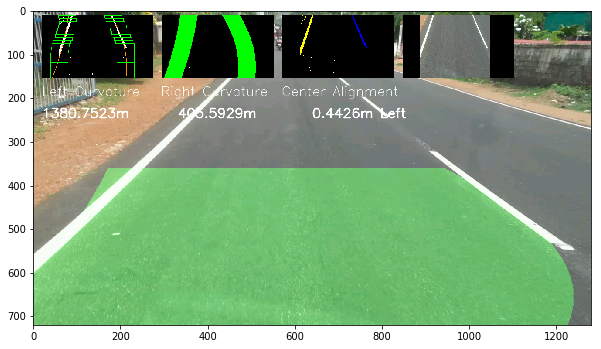

In [101]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [102]:
project_video_path = "videos/NVT5.mp4"
project_video_output_path = 'output_videos/NVT5_out1.mp4'

In [103]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

clip1 = VideoFileClip(project_video_path)
project_video_clip = clip1.fl_image(detector.process_image)
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14819.366728357758
Left Curvature   Right Curvature  Center Alignment 
4676.7511m       7824.6422m       0.0116m Right    
Moviepy - Building video output_videos/NVT5_out1.mp4.
Moviepy - Writing video output_videos/NVT5_out1.mp4



t:   0%|                                     | 0/963 [00:00<?, ?it/s, now=None]

[Previous lane] Found pct=0.5754456866596163
Non zeros found below thresholds, begining sliding window - pct=0.5754456866596163
[Sliding windows] Found pct=14819.366728357758
Left Curvature   Right Curvature  Center Alignment 
4676.7511m       7824.6422m       0.0116m Right    


t:   0%|                           | 2/963 [00:12<1:39:48,  6.23s/it, now=None]

[Previous lane] Found pct=0.5754456866596163
Non zeros found below thresholds, begining sliding window - pct=0.5754456866596163
[Sliding windows] Found pct=14819.366728357758
Left Curvature   Right Curvature  Center Alignment 
4676.7511m       7824.6422m       0.0116m Right    


t:   0%|                           | 3/963 [00:24<2:08:44,  8.05s/it, now=None]

[Previous lane] Found pct=0.6286706721742396
Non zeros found below thresholds, begining sliding window - pct=0.6286706721742396
[Sliding windows] Found pct=15453.59733383402
Left Curvature   Right Curvature  Center Alignment 
31139.6771m      4616.7998m       0.0171m Right    


t:   0%|                           | 4/963 [00:36<2:27:57,  9.26s/it, now=None]

[Previous lane] Found pct=0.6965114374624666
Non zeros found below thresholds, begining sliding window - pct=0.6965114374624666
[Sliding windows] Found pct=17244.354242870922
Left Curvature   Right Curvature  Center Alignment 
2819.7644m       4202.4252m       0.0140m Right    


t:   1%|▏                          | 5/963 [00:49<2:43:15, 10.23s/it, now=None]

[Previous lane] Found pct=0.7482163204487685
Non zeros found below thresholds, begining sliding window - pct=0.7482163204487685
[Sliding windows] Found pct=19142.711350688052
Left Curvature   Right Curvature  Center Alignment 
854.8846m        6160.9974m       0.0094m Left     


t:   1%|▏                          | 6/963 [01:02<2:58:23, 11.18s/it, now=None]

[Previous lane] Found pct=0.7721554229236632
Non zeros found below thresholds, begining sliding window - pct=0.7721554229236632
[Sliding windows] Found pct=20001.89597870156
Left Curvature   Right Curvature  Center Alignment 
869.4652m        3952.2251m       0.0173m Right    


t:   1%|▏                          | 7/963 [01:15<3:05:08, 11.62s/it, now=None]

[Previous lane] Found pct=0.8079779182619535
Non zeros found below thresholds, begining sliding window - pct=0.8079779182619535
[Sliding windows] Found pct=20258.396456237202
Left Curvature   Right Curvature  Center Alignment 
2019.8175m       3779.2802m       0.0560m Right    


t:   1%|▏                          | 8/963 [01:27<3:07:40, 11.79s/it, now=None]

[Previous lane] Found pct=0.8238048255448919
Non zeros found below thresholds, begining sliding window - pct=0.8238048255448919
[Sliding windows] Found pct=20492.418566687596
Left Curvature   Right Curvature  Center Alignment 
37889.6211m      6400.4774m       0.0832m Right    


t:   1%|▎                          | 9/963 [01:39<3:09:19, 11.91s/it, now=None]

[Previous lane] Found pct=0.8619571161860938
Left Curvature   Right Curvature  Center Alignment 
1552.9700m       6852.9108m       0.1014m Right    


t:   1%|▎                         | 10/963 [01:51<3:10:36, 12.00s/it, now=None]

[Previous lane] Found pct=0.8827339045643908
Left Curvature   Right Curvature  Center Alignment 
931.5081m        6371.2005m       0.1452m Right    


t:   1%|▎                         | 11/963 [02:03<3:10:17, 11.99s/it, now=None]

[Previous lane] Found pct=0.9016059879369231
Left Curvature   Right Curvature  Center Alignment 
537.0665m        4022.6038m       0.1657m Right    


t:   1%|▎                         | 12/963 [02:16<3:10:58, 12.05s/it, now=None]

[Previous lane] Found pct=0.9389767932489451
Left Curvature   Right Curvature  Center Alignment 
435.3066m        3683.4919m       0.1715m Right    


t:   1%|▎                         | 13/963 [02:28<3:11:13, 12.08s/it, now=None]

[Previous lane] Found pct=0.9597347063443582
Left Curvature   Right Curvature  Center Alignment 
550.3016m        5628.0943m       0.1395m Right    


t:   1%|▍                         | 14/963 [02:40<3:13:47, 12.25s/it, now=None]

[Previous lane] Found pct=0.9603287808009129
Left Curvature   Right Curvature  Center Alignment 
2752.2207m       3573.6961m       0.0698m Right    


t:   2%|▍                         | 15/963 [02:53<3:14:12, 12.29s/it, now=None]

[Previous lane] Found pct=0.9218950508098359
Left Curvature   Right Curvature  Center Alignment 
1536.8558m       4185.7151m       0.0312m Right    


t:   2%|▍                         | 16/963 [03:08<3:26:35, 13.09s/it, now=None]

[Previous lane] Found pct=0.8912921839482427
Left Curvature   Right Curvature  Center Alignment 
805.8655m        5057.8690m       0.0087m Right    


t:   2%|▍                         | 17/963 [03:23<3:34:54, 13.63s/it, now=None]

[Previous lane] Found pct=0.8823499840809692
Left Curvature   Right Curvature  Center Alignment 
626.5619m        2672.0818m       0.0161m Left     


t:   2%|▍                         | 18/963 [03:38<3:42:31, 14.13s/it, now=None]

[Previous lane] Found pct=0.8836728668438146
Left Curvature   Right Curvature  Center Alignment 
740.6967m        225126.2872m     0.0317m Right    


t:   2%|▌                         | 19/963 [03:53<3:48:01, 14.49s/it, now=None]

[Previous lane] Found pct=0.886094674556213
Left Curvature   Right Curvature  Center Alignment 
1432.2244m       4856.1131m       0.1042m Right    


t:   2%|▌                         | 20/963 [04:09<3:52:27, 14.79s/it, now=None]

[Previous lane] Found pct=0.8808077143979928
Left Curvature   Right Curvature  Center Alignment 
2464.2057m       6873.4337m       0.1519m Right    


t:   2%|▌                         | 21/963 [04:24<3:56:38, 15.07s/it, now=None]

[Previous lane] Found pct=0.8624399038461539
Left Curvature   Right Curvature  Center Alignment 
1665.4359m       11256.6191m      0.2183m Right    


t:   2%|▌                         | 22/963 [04:38<3:48:05, 14.54s/it, now=None]

[Previous lane] Found pct=0.8795825001514876
Left Curvature   Right Curvature  Center Alignment 
1458.8449m       9976.6880m       0.2408m Right    


t:   2%|▌                         | 23/963 [04:51<3:39:59, 14.04s/it, now=None]

[Previous lane] Found pct=0.879845498053337
Left Curvature   Right Curvature  Center Alignment 
1891.1892m       292260.7657m     0.2396m Right    


t:   2%|▋                         | 24/963 [05:04<3:35:11, 13.75s/it, now=None]

[Previous lane] Found pct=0.8458752697258227
Non zeros found below thresholds, begining sliding window - pct=0.8458752697258227
[Sliding windows] Found pct=29327.78328378929
Left Curvature   Right Curvature  Center Alignment 
2074.7716m       4992.9955m       0.2013m Right    


t:   3%|▋                         | 25/963 [05:17<3:34:44, 13.74s/it, now=None]

[Previous lane] Found pct=0.8304617402450294
Non zeros found below thresholds, begining sliding window - pct=0.8304617402450294
[Sliding windows] Found pct=28942.147151757235
Left Curvature   Right Curvature  Center Alignment 
1485.5209m       12714.7790m      0.2135m Right    


t:   3%|▋                         | 26/963 [05:32<3:40:34, 14.12s/it, now=None]

[Previous lane] Found pct=0.8411055336085781
Non zeros found below thresholds, begining sliding window - pct=0.8411055336085781
[Sliding windows] Found pct=28919.29462084534
Left Curvature   Right Curvature  Center Alignment 
1359.7953m       3054.8576m       0.2195m Right    


t:   3%|▋                         | 27/963 [05:48<3:46:49, 14.54s/it, now=None]

[Previous lane] Found pct=0.8526944490298183
Left Curvature   Right Curvature  Center Alignment 
1244.5619m       3261.4405m       0.2236m Right    


t:   3%|▊                         | 28/963 [06:04<3:52:20, 14.91s/it, now=None]

[Previous lane] Found pct=0.871276136433726
Left Curvature   Right Curvature  Center Alignment 
1128.2102m       4533.8547m       0.2400m Right    


t:   3%|▊                         | 29/963 [06:20<3:57:57, 15.29s/it, now=None]

[Previous lane] Found pct=0.8792139319380092
Left Curvature   Right Curvature  Center Alignment 
1526.9375m       4010.9163m       0.2348m Right    


t:   3%|▊                         | 30/963 [06:36<4:01:10, 15.51s/it, now=None]

[Previous lane] Found pct=0.8809224107547455
Left Curvature   Right Curvature  Center Alignment 
5420.6047m       3923.5130m       0.2225m Right    


t:   3%|▊                         | 31/963 [06:52<4:02:19, 15.60s/it, now=None]

[Previous lane] Found pct=0.8463151957414556
Non zeros found below thresholds, begining sliding window - pct=0.8463151957414556
[Sliding windows] Found pct=24583.149013801492
Left Curvature   Right Curvature  Center Alignment 
17110.5906m      4828.1269m       0.2119m Right    


t:   3%|▊                         | 32/963 [07:08<4:03:34, 15.70s/it, now=None]

[Previous lane] Found pct=0.8261090724121644
Non zeros found below thresholds, begining sliding window - pct=0.8261090724121644
[Sliding windows] Found pct=23402.155052138212
Left Curvature   Right Curvature  Center Alignment 
4899.3928m       8297.7087m       0.2265m Right    


t:   3%|▉                         | 33/963 [07:24<4:05:59, 15.87s/it, now=None]

[Previous lane] Found pct=0.8033094686600688
Non zeros found below thresholds, begining sliding window - pct=0.8033094686600688
[Sliding windows] Found pct=24028.873955920546
Left Curvature   Right Curvature  Center Alignment 
3509.5298m       4635.9300m       0.2602m Right    


t:   4%|▉                         | 34/963 [07:40<4:07:06, 15.96s/it, now=None]

[Previous lane] Found pct=0.7930498185527702
Non zeros found below thresholds, begining sliding window - pct=0.7930498185527702
[Sliding windows] Found pct=24728.24026288944
Left Curvature   Right Curvature  Center Alignment 
2439.7913m       122571.2908m     0.2501m Right    


t:   4%|▉                         | 35/963 [07:56<4:05:35, 15.88s/it, now=None]

[Previous lane] Found pct=0.7819447451248147
Non zeros found below thresholds, begining sliding window - pct=0.7819447451248147
[Sliding windows] Found pct=24180.183983080486
Left Curvature   Right Curvature  Center Alignment 
5726.4514m       5304.4531m       0.2831m Right    


t:   4%|▉                         | 36/963 [08:13<4:10:31, 16.22s/it, now=None]

[Previous lane] Found pct=0.7921982795332595
Non zeros found below thresholds, begining sliding window - pct=0.7921982795332595
[Sliding windows] Found pct=23723.04669108253
Left Curvature   Right Curvature  Center Alignment 
26642.9990m      6033.8783m       0.3206m Right    


t:   4%|▉                         | 37/963 [08:28<4:07:09, 16.01s/it, now=None]

[Previous lane] Found pct=0.7803282756664776
Non zeros found below thresholds, begining sliding window - pct=0.7803282756664776
[Sliding windows] Found pct=23146.949393788997
Left Curvature   Right Curvature  Center Alignment 
7575.7058m       5021.8770m       0.3241m Right    


t:   4%|█                         | 38/963 [08:45<4:07:48, 16.07s/it, now=None]

[Previous lane] Found pct=0.7341838486420066
Non zeros found below thresholds, begining sliding window - pct=0.7341838486420066
[Sliding windows] Found pct=22022.35056650825
Left Curvature   Right Curvature  Center Alignment 
6263.2357m       3114.0565m       0.3327m Right    


t:   4%|█                         | 39/963 [09:00<4:02:18, 15.73s/it, now=None]

[Previous lane] Found pct=0.6782696319343775
Non zeros found below thresholds, begining sliding window - pct=0.6782696319343775
[Sliding windows] Found pct=20782.213767987836
Left Curvature   Right Curvature  Center Alignment 
1205.8077m       2789.4967m       0.3268m Right    


t:   4%|█                         | 40/963 [09:12<3:48:15, 14.84s/it, now=None]

[Previous lane] Found pct=0.6803431826014402
Non zeros found below thresholds, begining sliding window - pct=0.6803431826014402
[Sliding windows] Found pct=19096.94968348116
Left Curvature   Right Curvature  Center Alignment 
720.1493m        9202.8534m       0.3322m Right    


t:   4%|█                         | 41/963 [09:25<3:38:35, 14.23s/it, now=None]

[Previous lane] Found pct=0.7054304140573885
Non zeros found below thresholds, begining sliding window - pct=0.7054304140573885
[Sliding windows] Found pct=18518.533077857745
Left Curvature   Right Curvature  Center Alignment 
1346.0065m       1054.0717m       0.4348m Right    


t:   4%|█▏                        | 42/963 [09:41<3:44:41, 14.64s/it, now=None]

[Previous lane] Found pct=0.7119308826522117
Non zeros found below thresholds, begining sliding window - pct=0.7119308826522117
[Sliding windows] Found pct=18389.850369082196
Left Curvature   Right Curvature  Center Alignment 
2099.7717m       1103.9284m       0.4344m Right    


t:   4%|█▏                        | 43/963 [09:55<3:43:24, 14.57s/it, now=None]

[Previous lane] Found pct=0.7410381576986138
Non zeros found below thresholds, begining sliding window - pct=0.7410381576986138
[Sliding windows] Found pct=18714.205600685647
Left Curvature   Right Curvature  Center Alignment 
72216.0784m      2062.1735m       0.4289m Right    


t:   5%|█▏                        | 44/963 [10:11<3:48:13, 14.90s/it, now=None]

[Previous lane] Found pct=0.7778396539882312
Non zeros found below thresholds, begining sliding window - pct=0.7778396539882312
[Sliding windows] Found pct=19450.697666648102
Left Curvature   Right Curvature  Center Alignment 
1406.0630m       2930.9744m       0.4496m Right    


t:   5%|█▏                        | 45/963 [10:26<3:49:25, 15.00s/it, now=None]

[Previous lane] Found pct=0.8109108272651308
Non zeros found below thresholds, begining sliding window - pct=0.8109108272651308
[Sliding windows] Found pct=18807.36230153993
Left Curvature   Right Curvature  Center Alignment 
928.6366m        6975.7058m       0.4535m Right    


t:   5%|█▏                        | 46/963 [10:41<3:50:30, 15.08s/it, now=None]

[Previous lane] Found pct=0.8345033345033345
Non zeros found below thresholds, begining sliding window - pct=0.8345033345033345
[Sliding windows] Found pct=17318.346525096524
Left Curvature   Right Curvature  Center Alignment 
859.9629m        31456.6230m      0.4426m Right    


t:   5%|█▎                        | 47/963 [10:57<3:54:07, 15.34s/it, now=None]

[Previous lane] Found pct=0.8584763781569258
Left Curvature   Right Curvature  Center Alignment 
1022.5296m       3944.2051m       0.4263m Right    


t:   5%|█▎                        | 48/963 [11:14<4:00:46, 15.79s/it, now=None]

[Previous lane] Found pct=0.8840179142674344
Left Curvature   Right Curvature  Center Alignment 
1871.8268m       3208.6535m       0.4148m Right    


t:   5%|█▎                        | 49/963 [11:31<4:06:41, 16.19s/it, now=None]

[Previous lane] Found pct=0.9056151682466924
Left Curvature   Right Curvature  Center Alignment 
4585.8895m       2926.7781m       0.4598m Right    


t:   5%|█▎                        | 50/963 [11:47<4:06:03, 16.17s/it, now=None]

[Previous lane] Found pct=0.9425901533414519
Left Curvature   Right Curvature  Center Alignment 
3012.1478m       1876.1837m       0.4479m Right    


t:   5%|█▍                        | 51/963 [12:03<4:02:55, 15.98s/it, now=None]

[Previous lane] Found pct=0.9861450107681263
Left Curvature   Right Curvature  Center Alignment 
737.9624m        4477.9770m       0.3605m Right    


t:   5%|█▍                        | 52/963 [12:18<4:00:45, 15.86s/it, now=None]

[Previous lane] Found pct=0.9992652809707772
Left Curvature   Right Curvature  Center Alignment 
807.1722m        6365.9803m       0.3989m Right    


t:   6%|█▍                        | 53/963 [12:34<3:58:59, 15.76s/it, now=None]

[Previous lane] Found pct=0.9979021151615372
Left Curvature   Right Curvature  Center Alignment 
1777.6516m       4936.0976m       0.4826m Right    


t:   6%|█▍                        | 54/963 [12:49<3:57:17, 15.66s/it, now=None]

[Previous lane] Found pct=0.9996000853151328
Left Curvature   Right Curvature  Center Alignment 
2576.1114m       5807.2177m       0.5087m Right    


t:   6%|█▍                        | 55/963 [13:04<3:54:14, 15.48s/it, now=None]

[Previous lane] Found pct=0.9994818935427574
Left Curvature   Right Curvature  Center Alignment 
4891.9855m       5144.7322m       0.5450m Right    


t:   6%|█▌                        | 56/963 [13:21<3:58:20, 15.77s/it, now=None]

[Previous lane] Found pct=0.9998365746036935
Left Curvature   Right Curvature  Center Alignment 
2536.8754m       7063.9906m       0.5551m Right    


t:   6%|█▌                        | 57/963 [13:35<3:48:51, 15.16s/it, now=None]

[Previous lane] Found pct=0.9980769730516359
Left Curvature   Right Curvature  Center Alignment 
2989.8147m       26230.0121m      0.5512m Right    


t:   6%|█▌                        | 58/963 [13:50<3:50:35, 15.29s/it, now=None]

[Previous lane] Found pct=0.9964714543192953
Left Curvature   Right Curvature  Center Alignment 
2956.0004m       11765.7681m      0.5728m Right    


t:   6%|█▌                        | 59/963 [14:07<3:55:32, 15.63s/it, now=None]

[Previous lane] Found pct=0.9978371309290277
Left Curvature   Right Curvature  Center Alignment 
1448.3507m       26805.5982m      0.5842m Right    


t:   6%|█▌                        | 60/963 [14:22<3:54:07, 15.56s/it, now=None]

[Previous lane] Found pct=0.9969176899935888
Left Curvature   Right Curvature  Center Alignment 
1593.7809m       6065.2610m       0.5930m Right    


t:   6%|█▋                        | 61/963 [14:38<3:54:36, 15.61s/it, now=None]

[Previous lane] Found pct=0.9966763606148733
Left Curvature   Right Curvature  Center Alignment 
2332.5726m       4250.2721m       0.5947m Right    


t:   6%|█▋                        | 62/963 [14:53<3:54:21, 15.61s/it, now=None]

[Previous lane] Found pct=0.9986562150055991
Left Curvature   Right Curvature  Center Alignment 
11175.3666m      4553.6666m       0.5849m Right    


t:   7%|█▋                        | 63/963 [15:09<3:53:26, 15.56s/it, now=None]

[Previous lane] Found pct=0.9978384812981643
Left Curvature   Right Curvature  Center Alignment 
9726.5455m       11167.7944m      0.5890m Right    


t:   7%|█▋                        | 64/963 [15:24<3:53:18, 15.57s/it, now=None]

[Previous lane] Found pct=0.9963034676993487
Left Curvature   Right Curvature  Center Alignment 
9385.0895m       4957.6631m       0.6097m Right    


t:   7%|█▊                        | 65/963 [15:41<3:56:25, 15.80s/it, now=None]

[Previous lane] Found pct=0.9970951548310677
Left Curvature   Right Curvature  Center Alignment 
21779.0289m      4141.8448m       0.6301m Right    


t:   7%|█▊                        | 66/963 [15:57<3:57:53, 15.91s/it, now=None]

[Previous lane] Found pct=0.9779494814662696
Left Curvature   Right Curvature  Center Alignment 
7825.9824m       6161.9937m       0.6514m Right    


t:   7%|█▊                        | 67/963 [16:14<4:01:27, 16.17s/it, now=None]

[Previous lane] Found pct=0.9775033872740753
Left Curvature   Right Curvature  Center Alignment 
2407.9235m       5666.6173m       0.6737m Right    


t:   7%|█▊                        | 68/963 [16:30<4:01:44, 16.21s/it, now=None]

[Previous lane] Found pct=0.9949062591674
Left Curvature   Right Curvature  Center Alignment 
4301.4137m       4725.8692m       0.6758m Right    


t:   7%|█▊                        | 69/963 [16:46<3:59:48, 16.09s/it, now=None]

[Previous lane] Found pct=0.9935621722118934
Left Curvature   Right Curvature  Center Alignment 
8851.6009m       3298.3954m       0.6865m Right    


t:   7%|█▉                        | 70/963 [17:01<3:57:23, 15.95s/it, now=None]

[Previous lane] Found pct=0.9784838248272923
Left Curvature   Right Curvature  Center Alignment 
4292.9243m       3337.5440m       0.7009m Right    


t:   7%|█▉                        | 71/963 [17:17<3:55:50, 15.86s/it, now=None]

[Previous lane] Found pct=0.9810440800361065
Left Curvature   Right Curvature  Center Alignment 
3788.7204m       417851.6122m     0.7015m Right    


t:   7%|█▉                        | 72/963 [17:33<3:53:49, 15.75s/it, now=None]

[Previous lane] Found pct=0.9887868620872329
Left Curvature   Right Curvature  Center Alignment 
31550.2106m      137168.5987m     0.6885m Right    


t:   8%|█▉                        | 73/963 [17:48<3:54:32, 15.81s/it, now=None]

[Previous lane] Found pct=0.9932138603440157
Left Curvature   Right Curvature  Center Alignment 
4999.7999m       11088.8205m      0.7046m Right    


t:   8%|█▉                        | 74/963 [18:04<3:52:44, 15.71s/it, now=None]

[Previous lane] Found pct=0.991537072473924
Left Curvature   Right Curvature  Center Alignment 
3080.8629m       5376.1416m       0.7236m Right    


t:   8%|██                        | 75/963 [18:20<3:53:16, 15.76s/it, now=None]

[Previous lane] Found pct=0.9820141013702275
Left Curvature   Right Curvature  Center Alignment 
7696.9409m       3009.9161m       0.7545m Right    


t:   8%|██                        | 76/963 [18:38<4:02:17, 16.39s/it, now=None]

[Previous lane] Found pct=0.9639255029617375
Left Curvature   Right Curvature  Center Alignment 
12123031.3309m   2791.8207m       0.7740m Right    


t:   8%|██                        | 77/963 [18:54<4:00:35, 16.29s/it, now=None]

[Previous lane] Found pct=0.8983037156704362
Left Curvature   Right Curvature  Center Alignment 
29604.8123m      3102.9178m       0.7818m Right    


t:   8%|██                        | 78/963 [19:10<3:57:55, 16.13s/it, now=None]

[Previous lane] Found pct=0.8742147184204622
Left Curvature   Right Curvature  Center Alignment 
4073.3026m       30013.2105m      0.7970m Right    


t:   8%|██▏                       | 79/963 [19:25<3:54:47, 15.94s/it, now=None]

[Previous lane] Found pct=0.7725248626985305
Non zeros found below thresholds, begining sliding window - pct=0.7725248626985305
[Sliding windows] Found pct=18221.486393548068
Left Curvature   Right Curvature  Center Alignment 
2788.8492m       14400.5424m      0.8105m Right    


t:   8%|██▏                       | 80/963 [19:42<4:01:27, 16.41s/it, now=None]

[Previous lane] Found pct=0.667433439829606
Non zeros found below thresholds, begining sliding window - pct=0.667433439829606
[Sliding windows] Found pct=18942.247838125666
Left Curvature   Right Curvature  Center Alignment 
17168.2851m      42097.4164m      0.8103m Right    


t:   8%|██▏                       | 81/963 [19:59<4:02:52, 16.52s/it, now=None]

[Previous lane] Found pct=0.6414712935254365
Non zeros found below thresholds, begining sliding window - pct=0.6414712935254365
[Sliding windows] Found pct=19447.678491448503
Left Curvature   Right Curvature  Center Alignment 
5945.2067m       176240.1971m     0.8242m Right    


t:   9%|██▏                       | 82/963 [20:15<4:00:11, 16.36s/it, now=None]

[Previous lane] Found pct=0.6431249885675612
Non zeros found below thresholds, begining sliding window - pct=0.6431249885675612
[Sliding windows] Found pct=20759.06082057473
Left Curvature   Right Curvature  Center Alignment 
4465.4503m       34645.0073m      0.8367m Right    


t:   9%|██▏                       | 83/963 [20:31<3:58:20, 16.25s/it, now=None]

[Previous lane] Found pct=0.65558549943493
Non zeros found below thresholds, begining sliding window - pct=0.65558549943493
[Sliding windows] Found pct=21948.463757280708
Left Curvature   Right Curvature  Center Alignment 
5287.3861m       6166.6644m       0.8385m Right    


t:   9%|██▎                       | 84/963 [20:48<3:59:46, 16.37s/it, now=None]

[Previous lane] Found pct=0.712401209874134
Non zeros found below thresholds, begining sliding window - pct=0.712401209874134
[Sliding windows] Found pct=21478.474953654015
Left Curvature   Right Curvature  Center Alignment 
13805.1824m      4168.2217m       0.8339m Right    


t:   9%|██▎                       | 85/963 [21:06<4:07:15, 16.90s/it, now=None]

[Previous lane] Found pct=0.7923230688686879
Non zeros found below thresholds, begining sliding window - pct=0.7923230688686879
[Sliding windows] Found pct=18612.890152777116
Left Curvature   Right Curvature  Center Alignment 
21148.3276m      3400.9386m       0.8484m Right    


t:   9%|██▎                       | 86/963 [21:21<3:59:50, 16.41s/it, now=None]

[Previous lane] Found pct=0.867442047865911
Left Curvature   Right Curvature  Center Alignment 
6406.2579m       4025.0080m       0.8572m Right    


t:   9%|██▎                       | 87/963 [21:36<3:53:27, 15.99s/it, now=None]

[Previous lane] Found pct=0.8904044364777056
Left Curvature   Right Curvature  Center Alignment 
38432.8191m      5400.0594m       0.8461m Right    


t:   9%|██▍                       | 88/963 [21:54<3:59:02, 16.39s/it, now=None]

[Previous lane] Found pct=0.9207378661421509
Left Curvature   Right Curvature  Center Alignment 
113728.3664m     11603.4416m      0.8732m Right    


t:   9%|██▍                       | 89/963 [22:11<4:01:01, 16.55s/it, now=None]

[Previous lane] Found pct=0.8354268487644453
Non zeros found below thresholds, begining sliding window - pct=0.8354268487644453
[Sliding windows] Found pct=20446.7681450692
Left Curvature   Right Curvature  Center Alignment 
4178.0273m       6528.0230m       0.8943m Right    


t:   9%|██▍                       | 90/963 [22:29<4:08:24, 17.07s/it, now=None]

[Previous lane] Found pct=0.7569099929128278
Non zeros found below thresholds, begining sliding window - pct=0.7569099929128278
[Sliding windows] Found pct=22849.907023962303
Left Curvature   Right Curvature  Center Alignment 
5722.3925m       4841.0536m       0.8999m Right    


t:   9%|██▍                       | 91/963 [22:47<4:12:41, 17.39s/it, now=None]

[Previous lane] Found pct=0.8013294844690193
Non zeros found below thresholds, begining sliding window - pct=0.8013294844690193
[Sliding windows] Found pct=21789.833163929095
Left Curvature   Right Curvature  Center Alignment 
8753.1233m       3080.4844m       0.8970m Right    


t:  10%|██▍                       | 92/963 [23:04<4:12:39, 17.40s/it, now=None]

[Previous lane] Found pct=0.8025187737996469
Non zeros found below thresholds, begining sliding window - pct=0.8025187737996469
[Sliding windows] Found pct=20378.352904886506
Left Curvature   Right Curvature  Center Alignment 
3808.2276m       2884.9413m       0.9057m Right    


t:  10%|██▌                       | 93/963 [23:21<4:09:51, 17.23s/it, now=None]

[Previous lane] Found pct=0.9597308568066109
Left Curvature   Right Curvature  Center Alignment 
3568.3410m       2485.3871m       0.9095m Right    


t:  10%|██▌                       | 94/963 [23:39<4:13:28, 17.50s/it, now=None]

[Previous lane] Found pct=0.8729578994126648
Left Curvature   Right Curvature  Center Alignment 
4214.3137m       26296.6423m      0.9090m Right    


t:  10%|██▌                       | 95/963 [23:57<4:12:49, 17.48s/it, now=None]

[Previous lane] Found pct=0.8571753364859949
Left Curvature   Right Curvature  Center Alignment 
4899.0291m       38505.1973m      0.9056m Right    


t:  10%|██▌                       | 96/963 [24:13<4:08:42, 17.21s/it, now=None]

[Previous lane] Found pct=0.839001897455777
Non zeros found below thresholds, begining sliding window - pct=0.839001897455777
[Sliding windows] Found pct=22669.429987962376
Left Curvature   Right Curvature  Center Alignment 
7946.1242m       23805.3746m      0.9171m Right    


t:  10%|██▌                       | 97/963 [24:30<4:06:41, 17.09s/it, now=None]

[Previous lane] Found pct=0.8987929433611885
Left Curvature   Right Curvature  Center Alignment 
8420.4833m       108841.6760m     0.9272m Right    


t:  10%|██▋                       | 98/963 [24:47<4:03:26, 16.89s/it, now=None]

[Previous lane] Found pct=0.8925209356049668
Left Curvature   Right Curvature  Center Alignment 
217738.2805m     11867.1420m      0.9287m Right    


t:  10%|██▋                       | 99/963 [25:03<3:59:53, 16.66s/it, now=None]

[Previous lane] Found pct=0.8724889691508574
Left Curvature   Right Curvature  Center Alignment 
27976.2575m      5150.2812m       0.9409m Right    


t:  10%|██▌                      | 100/963 [25:19<3:57:11, 16.49s/it, now=None]

[Previous lane] Found pct=0.8467660387251413
Non zeros found below thresholds, begining sliding window - pct=0.8467660387251413
[Sliding windows] Found pct=33622.67192239991
**** MAX DISTANCE BREACHED ****
y_smooth=[1201.62007192 1199.35692761 1200.22205247 1203.46552427] - y_new=[405.88324837 406.61948071 406.61414801 406.08053216] - distance=797.3849921091478 - max-distance=150
**** REVISED Poly right [ 2.97293367e-05 -1.94578451e-02  1.20251864e+03]
Left Curvature   Right Curvature  Center Alignment 
32338.2544m      7183.0988m       0.9479m Right    


t:  10%|██▌                      | 101/963 [25:36<3:58:36, 16.61s/it, now=None]

[Previous lane] Found pct=0.7988268684957427
Non zeros found below thresholds, begining sliding window - pct=0.7988268684957427
[Sliding windows] Found pct=33738.83485335856
**** MAX DISTANCE BREACHED ****
y_smooth=[1202.35872372 1199.47273152 1200.36762893 1204.11025181] - y_new=[408.05270782 408.95889998 408.42492669 406.77190717] - distance=797.3383446425466 - max-distance=150
**** REVISED Poly right [ 3.55965685e-05 -2.40027678e-02  1.20346987e+03]
Left Curvature   Right Curvature  Center Alignment 
15266.3824m      5999.1581m       0.9508m Right    


t:  11%|██▋                      | 102/963 [25:52<3:58:18, 16.61s/it, now=None]

[Previous lane] Found pct=0.8398636094493334
Non zeros found below thresholds, begining sliding window - pct=0.8398636094493334
[Sliding windows] Found pct=33391.544520897565
**** MAX DISTANCE BREACHED ****
y_smooth=[1201.98939782 1199.41482957 1200.2948407  1203.78788804] - y_new=[409.37823437 409.80625163 409.8110385  409.51571255] - distance=794.2721754931531 - max-distance=150
**** REVISED Poly right [ 3.26629526e-05 -2.17303064e-02  1.20299426e+03]
Left Curvature   Right Curvature  Center Alignment 
56924.4310m      6537.9604m       0.9567m Right    


t:  11%|██▋                      | 103/963 [26:10<4:02:44, 16.94s/it, now=None]

[Previous lane] Found pct=0.8322284949938037
Non zeros found below thresholds, begining sliding window - pct=0.8322284949938037
[Sliding windows] Found pct=34442.31366917796
**** MAX DISTANCE BREACHED ****
y_smooth=[1202.17406077 1199.44378054 1200.33123481 1203.94906993] - y_new=[411.0754122  411.37065033 412.58179986 414.65957963] - distance=791.0986485667888 - max-distance=150
**** REVISED Poly right [ 3.41297605e-05 -2.28665371e-02  1.20323206e+03]
Left Curvature   Right Curvature  Center Alignment 
19712.9020m      6256.9810m       0.9697m Right    


t:  11%|██▋                      | 104/963 [26:28<4:06:09, 17.19s/it, now=None]

[Previous lane] Found pct=0.8364342553997727
Non zeros found below thresholds, begining sliding window - pct=0.8364342553997727
[Sliding windows] Found pct=33541.700682076545
**** MAX DISTANCE BREACHED ****
y_smooth=[1202.08172929 1199.42930505 1200.31303776 1203.86847898] - y_new=[412.47928144 412.8905938  413.65884506 414.81749755] - distance=789.6024478556893 - max-distance=150
**** REVISED Poly right [ 3.33963566e-05 -2.22984217e-02  1.20311316e+03]
Left Curvature   Right Curvature  Center Alignment 
43759.5039m      6394.3854m       0.9696m Right    


t:  11%|██▋                      | 105/963 [26:46<4:10:12, 17.50s/it, now=None]

[Previous lane] Found pct=0.8998338058461237
Left Curvature   Right Curvature  Center Alignment 
24545.7469m      8349.5102m       1.0033m Right    


t:  11%|██▊                      | 106/963 [27:02<4:04:37, 17.13s/it, now=None]

[Previous lane] Found pct=0.9573346897253306
Left Curvature   Right Curvature  Center Alignment 
24468.5583m      7825.2886m       1.0043m Right    


t:  11%|██▊                      | 107/963 [27:18<4:00:14, 16.84s/it, now=None]

[Previous lane] Found pct=0.9630580216266251
Left Curvature   Right Curvature  Center Alignment 
13573.7271m      2354.5688m       1.0121m Right    


t:  11%|██▊                      | 108/963 [27:34<3:55:46, 16.55s/it, now=None]

[Previous lane] Found pct=0.9924798446286217
Left Curvature   Right Curvature  Center Alignment 
12048.0169m      964.3602m        1.0188m Right    


t:  11%|██▊                      | 109/963 [27:51<3:54:54, 16.50s/it, now=None]

[Previous lane] Found pct=0.9951032573983394
Left Curvature   Right Curvature  Center Alignment 
13544.0522m      906.6136m        1.0086m Right    


t:  11%|██▊                      | 110/963 [28:07<3:53:07, 16.40s/it, now=None]

[Previous lane] Found pct=0.9908474186501093
Left Curvature   Right Curvature  Center Alignment 
13000.3567m      19388.9250m      0.9857m Right    


t:  12%|██▉                      | 111/963 [28:23<3:50:22, 16.22s/it, now=None]

[Previous lane] Found pct=0.9919881698596275
Left Curvature   Right Curvature  Center Alignment 
18378.7089m      1614.6000m       0.9389m Right    


t:  12%|██▉                      | 112/963 [28:39<3:48:28, 16.11s/it, now=None]

[Previous lane] Found pct=0.9661898839137645
Left Curvature   Right Curvature  Center Alignment 
11921.5776m      2181.7785m       0.9664m Right    


t:  12%|██▉                      | 113/963 [28:57<3:57:09, 16.74s/it, now=None]

[Previous lane] Found pct=0.9538075913105754
Left Curvature   Right Curvature  Center Alignment 
14631.0547m      5324.3377m       0.9843m Right    


t:  12%|██▉                      | 114/963 [29:13<3:53:39, 16.51s/it, now=None]

[Previous lane] Found pct=0.9348417187655056
Left Curvature   Right Curvature  Center Alignment 
21783.5726m      13537.4054m      0.9886m Right    


t:  12%|██▉                      | 115/963 [29:28<3:50:13, 16.29s/it, now=None]

[Previous lane] Found pct=0.9353461804029879
Left Curvature   Right Curvature  Center Alignment 
17676.6805m      38362.0134m      0.9928m Right    


t:  12%|███                      | 116/963 [29:45<3:51:28, 16.40s/it, now=None]

[Previous lane] Found pct=0.8911296276764055
Left Curvature   Right Curvature  Center Alignment 
11926.9528m      3410.6044m       1.0001m Right    


t:  12%|███                      | 117/963 [30:01<3:50:59, 16.38s/it, now=None]

[Previous lane] Found pct=0.9068115428874922
Left Curvature   Right Curvature  Center Alignment 
11899.7916m      5012.4773m       0.9955m Right    


t:  12%|███                      | 118/963 [30:17<3:48:45, 16.24s/it, now=None]

[Previous lane] Found pct=0.9234428684697383
Left Curvature   Right Curvature  Center Alignment 
20250.3538m      4759.4464m       1.0382m Right    


t:  12%|███                      | 119/963 [30:33<3:46:44, 16.12s/it, now=None]

[Previous lane] Found pct=0.9392322481691906
Left Curvature   Right Curvature  Center Alignment 
21553.9963m      72020.5917m      1.0222m Right    


t:  12%|███                      | 120/963 [30:49<3:46:27, 16.12s/it, now=None]

[Previous lane] Found pct=0.9689068061929065
Left Curvature   Right Curvature  Center Alignment 
38964.2403m      17786.4270m      1.0265m Right    


t:  13%|███▏                     | 121/963 [31:07<3:51:38, 16.51s/it, now=None]

[Previous lane] Found pct=0.9656185468247717
Left Curvature   Right Curvature  Center Alignment 
27121.4471m      1941.5141m       1.0413m Right    


t:  13%|███▏                     | 122/963 [31:23<3:49:39, 16.38s/it, now=None]

[Previous lane] Found pct=0.9764742028222179
Left Curvature   Right Curvature  Center Alignment 
18556.0484m      1679.5871m       1.0433m Right    


t:  13%|███▏                     | 123/963 [31:39<3:46:44, 16.20s/it, now=None]

[Previous lane] Found pct=0.9782522919809679
Left Curvature   Right Curvature  Center Alignment 
41752.1616m      3816.9565m       1.0427m Right    


t:  13%|███▏                     | 124/963 [31:55<3:45:15, 16.11s/it, now=None]

[Previous lane] Found pct=0.983820695234243
Left Curvature   Right Curvature  Center Alignment 
46734.0869m      3596.1573m       1.0538m Right    


t:  13%|███▏                     | 125/963 [32:11<3:45:17, 16.13s/it, now=None]

[Previous lane] Found pct=0.9748524259730288
Left Curvature   Right Curvature  Center Alignment 
26977.8201m      688232.7980m     1.0570m Right    


t:  13%|███▎                     | 126/963 [32:27<3:44:30, 16.09s/it, now=None]

[Previous lane] Found pct=0.9805439181992474
Left Curvature   Right Curvature  Center Alignment 
9521.6942m       4617.8617m       1.0460m Right    


t:  13%|███▎                     | 127/963 [32:43<3:43:34, 16.05s/it, now=None]

[Previous lane] Found pct=0.9819234901209771
Left Curvature   Right Curvature  Center Alignment 
12293.2324m      14638.8057m      1.0670m Right    


t:  13%|███▎                     | 128/963 [32:59<3:44:51, 16.16s/it, now=None]

[Previous lane] Found pct=0.9829322409967571
Left Curvature   Right Curvature  Center Alignment 
30686.9145m      6435.7026m       1.0629m Right    


t:  13%|███▎                     | 129/963 [33:16<3:46:14, 16.28s/it, now=None]

[Previous lane] Found pct=0.9828520087280195
Left Curvature   Right Curvature  Center Alignment 
12609.4315m      47387.9410m      1.0688m Right    


t:  13%|███▎                     | 130/963 [33:32<3:44:42, 16.19s/it, now=None]

[Previous lane] Found pct=0.9892049894365178
Left Curvature   Right Curvature  Center Alignment 
5840.0937m       172979.6438m     1.0715m Right    


t:  14%|███▍                     | 131/963 [33:47<3:42:59, 16.08s/it, now=None]

[Previous lane] Found pct=0.9897547866980181
Left Curvature   Right Curvature  Center Alignment 
3526.8968m       15432.6205m      1.0733m Right    


t:  14%|███▍                     | 132/963 [34:06<3:51:31, 16.72s/it, now=None]

[Previous lane] Found pct=0.9900529994623243
Left Curvature   Right Curvature  Center Alignment 
2319.5730m       3805.9528m       1.0681m Right    


t:  14%|███▍                     | 133/963 [34:22<3:50:34, 16.67s/it, now=None]

[Previous lane] Found pct=0.9789237668161435
Left Curvature   Right Curvature  Center Alignment 
2011.4431m       28615.9897m      1.0802m Right    


t:  14%|███▍                     | 134/963 [34:38<3:47:24, 16.46s/it, now=None]

[Previous lane] Found pct=0.974270369290978
Left Curvature   Right Curvature  Center Alignment 
1312.5735m       16811.7572m      1.0817m Right    


t:  14%|███▌                     | 135/963 [34:54<3:46:37, 16.42s/it, now=None]

[Previous lane] Found pct=0.9807999270306016
Left Curvature   Right Curvature  Center Alignment 
1123.6791m       5699.8940m       1.1054m Right    


t:  14%|███▌                     | 136/963 [35:11<3:44:46, 16.31s/it, now=None]

[Previous lane] Found pct=0.9361261087543387
Left Curvature   Right Curvature  Center Alignment 
4517.2414m       4405.3926m       1.0989m Right    


t:  14%|███▌                     | 137/963 [35:27<3:45:59, 16.42s/it, now=None]

[Previous lane] Found pct=0.9065680440464935
Left Curvature   Right Curvature  Center Alignment 
8830.9828m       3979.9208m       1.0914m Right    


t:  14%|███▌                     | 138/963 [35:43<3:44:18, 16.31s/it, now=None]

[Previous lane] Found pct=0.9011502106821546
Left Curvature   Right Curvature  Center Alignment 
119932.3432m     3179.2666m       1.0941m Right    


t:  14%|███▌                     | 139/963 [36:01<3:49:50, 16.74s/it, now=None]

[Previous lane] Found pct=0.8815307445189652
Left Curvature   Right Curvature  Center Alignment 
9806.1242m       15556.0465m      1.0950m Right    


t:  15%|███▋                     | 140/963 [36:18<3:49:01, 16.70s/it, now=None]

[Previous lane] Found pct=0.902917661717371
Left Curvature   Right Curvature  Center Alignment 
8147.4549m       6382.7180m       1.1043m Right    


t:  15%|███▋                     | 141/963 [36:34<3:46:52, 16.56s/it, now=None]

[Previous lane] Found pct=0.9156738644825019
Left Curvature   Right Curvature  Center Alignment 
7898.2755m       8370.0397m       1.1280m Right    


t:  15%|███▋                     | 142/963 [36:50<3:44:27, 16.40s/it, now=None]

[Previous lane] Found pct=0.9249392835458409
Left Curvature   Right Curvature  Center Alignment 
5864.7523m       13545.1022m      1.1513m Right    


t:  15%|███▋                     | 143/963 [37:06<3:41:43, 16.22s/it, now=None]

[Previous lane] Found pct=0.936641621527171
Left Curvature   Right Curvature  Center Alignment 
8980.6479m       3115.0091m       1.1569m Right    


t:  15%|███▋                     | 144/963 [37:22<3:39:47, 16.10s/it, now=None]

[Previous lane] Found pct=0.9427205209075186
Left Curvature   Right Curvature  Center Alignment 
7057.8118m       2803.8397m       1.1575m Right    


t:  15%|███▊                     | 145/963 [37:38<3:39:38, 16.11s/it, now=None]

[Previous lane] Found pct=0.9517796030116359
Left Curvature   Right Curvature  Center Alignment 
4733.5018m       2286.0521m       1.1654m Right    


t:  15%|███▊                     | 146/963 [37:53<3:37:48, 16.00s/it, now=None]

[Previous lane] Found pct=0.95759767933245
Left Curvature   Right Curvature  Center Alignment 
3520.4513m       2296.2292m       1.1705m Right    


t:  15%|███▊                     | 147/963 [38:09<3:37:14, 15.97s/it, now=None]

[Previous lane] Found pct=0.9557301201611024
Left Curvature   Right Curvature  Center Alignment 
3207.5109m       104600.3264m     1.1588m Right    


t:  15%|███▊                     | 148/963 [38:25<3:37:34, 16.02s/it, now=None]

[Previous lane] Found pct=0.9647015339124007
Left Curvature   Right Curvature  Center Alignment 
3740.2005m       1836.0538m       1.0894m Right    


t:  15%|███▊                     | 149/963 [38:42<3:38:28, 16.10s/it, now=None]

[Previous lane] Found pct=0.9740493092580047
Left Curvature   Right Curvature  Center Alignment 
4764.8892m       1407.3651m       1.0838m Right    


t:  16%|███▉                     | 150/963 [38:58<3:37:52, 16.08s/it, now=None]

[Previous lane] Found pct=0.9738909805205435
Left Curvature   Right Curvature  Center Alignment 
5212.5317m       2939.4201m       1.1209m Right    


t:  16%|███▉                     | 151/963 [39:16<3:48:03, 16.85s/it, now=None]

[Previous lane] Found pct=0.9764990588867976
Left Curvature   Right Curvature  Center Alignment 
6925.1853m       27603.4197m      1.1518m Right    


t:  16%|███▉                     | 152/963 [39:33<3:45:21, 16.67s/it, now=None]

[Previous lane] Found pct=0.9616976956125505
Left Curvature   Right Curvature  Center Alignment 
10176.8638m      4089.6754m       1.1544m Right    


t:  16%|███▉                     | 153/963 [39:49<3:44:22, 16.62s/it, now=None]

[Previous lane] Found pct=0.9678190666404118
Left Curvature   Right Curvature  Center Alignment 
23344.7107m      3269.1043m       1.1576m Right    


t:  16%|███▉                     | 154/963 [40:05<3:41:58, 16.46s/it, now=None]

[Previous lane] Found pct=0.9695414911916483
Left Curvature   Right Curvature  Center Alignment 
8382.5743m       3617.1125m       1.1646m Right    


t:  16%|████                     | 155/963 [40:22<3:41:16, 16.43s/it, now=None]

[Previous lane] Found pct=0.9623115577889447
Left Curvature   Right Curvature  Center Alignment 
5403.9317m       1823.6902m       1.1346m Right    


t:  16%|████                     | 156/963 [40:38<3:39:17, 16.30s/it, now=None]

[Previous lane] Found pct=0.9621640646604822
Left Curvature   Right Curvature  Center Alignment 
7472.1367m       2949.5944m       1.1651m Right    


t:  16%|████                     | 157/963 [40:54<3:39:17, 16.32s/it, now=None]

[Previous lane] Found pct=0.9635899927131406
Left Curvature   Right Curvature  Center Alignment 
10090.0197m      17721.7945m      1.2039m Right    


t:  16%|████                     | 158/963 [41:11<3:42:27, 16.58s/it, now=None]

[Previous lane] Found pct=0.9622259776735772
Left Curvature   Right Curvature  Center Alignment 
34904.3050m      6917.5072m       1.2049m Right    


t:  17%|████▏                    | 159/963 [41:27<3:40:07, 16.43s/it, now=None]

[Previous lane] Found pct=0.9488622521073917
Left Curvature   Right Curvature  Center Alignment 
18292.9857m      4913.6888m       1.2073m Right    


t:  17%|████▏                    | 160/963 [41:43<3:37:00, 16.21s/it, now=None]

[Previous lane] Found pct=0.9366237805030974
Left Curvature   Right Curvature  Center Alignment 
5063.7726m       3737.5651m       1.2013m Right    


t:  17%|████▏                    | 161/963 [41:59<3:37:07, 16.24s/it, now=None]

[Previous lane] Found pct=0.9267729267729268
Left Curvature   Right Curvature  Center Alignment 
5810.4415m       13804.3350m      1.2053m Right    


t:  17%|████▏                    | 162/963 [42:15<3:35:15, 16.12s/it, now=None]

[Previous lane] Found pct=0.912092771853963
Left Curvature   Right Curvature  Center Alignment 
10517.7539m      16123.1634m      1.2116m Right    


t:  17%|████▏                    | 163/963 [42:31<3:33:38, 16.02s/it, now=None]

[Previous lane] Found pct=0.8856104010577347
Left Curvature   Right Curvature  Center Alignment 
12795.0233m      17613.6281m      1.2181m Right    


t:  17%|████▎                    | 164/963 [42:47<3:33:25, 16.03s/it, now=None]

[Previous lane] Found pct=0.9132673094542123
Left Curvature   Right Curvature  Center Alignment 
24987.5621m      19736.0050m      1.2259m Right    


t:  17%|████▎                    | 165/963 [43:03<3:33:37, 16.06s/it, now=None]

[Previous lane] Found pct=0.9263462156086072
Left Curvature   Right Curvature  Center Alignment 
8670.8569m       4890.8485m       1.2366m Right    


t:  17%|████▎                    | 166/963 [43:19<3:33:21, 16.06s/it, now=None]

[Previous lane] Found pct=0.9441408206949947
Left Curvature   Right Curvature  Center Alignment 
27795.3086m      7028.9240m       1.2155m Right    


t:  17%|████▎                    | 167/963 [43:35<3:32:54, 16.05s/it, now=None]

[Previous lane] Found pct=0.9477164605137964
Left Curvature   Right Curvature  Center Alignment 
14227.4641m      5095.7475m       1.2105m Right    


t:  17%|████▎                    | 168/963 [43:51<3:32:53, 16.07s/it, now=None]

[Previous lane] Found pct=0.936799608514803
Left Curvature   Right Curvature  Center Alignment 
23858.3936m      4767.3950m       1.1927m Right    


t:  18%|████▍                    | 169/963 [44:07<3:32:59, 16.09s/it, now=None]

[Previous lane] Found pct=0.9446815613152436
Left Curvature   Right Curvature  Center Alignment 
111166.8771m     8928.8120m       1.1789m Right    


t:  18%|████▍                    | 170/963 [44:25<3:37:21, 16.45s/it, now=None]

[Previous lane] Found pct=0.9493482734964556
Left Curvature   Right Curvature  Center Alignment 
22960.4280m      14111.6244m      1.1800m Right    


t:  18%|████▍                    | 171/963 [44:53<4:25:08, 20.09s/it, now=None]

[Previous lane] Found pct=0.9628821913028307
Left Curvature   Right Curvature  Center Alignment 
25990.3164m      97391.6236m      1.1869m Right    


t:  18%|████▍                    | 172/963 [45:10<4:11:53, 19.11s/it, now=None]

[Previous lane] Found pct=0.9664337145277425
Left Curvature   Right Curvature  Center Alignment 
13901.8649m      11754.8353m      1.1842m Right    


t:  18%|████▍                    | 173/963 [45:26<3:59:11, 18.17s/it, now=None]

[Previous lane] Found pct=0.9757040189330612
Left Curvature   Right Curvature  Center Alignment 
8451.8960m       5723.6788m       1.1758m Right    


t:  18%|████▌                    | 174/963 [45:42<3:49:45, 17.47s/it, now=None]

[Previous lane] Found pct=0.9640664340297717
Left Curvature   Right Curvature  Center Alignment 
7536.3816m       4913.5780m       1.1667m Right    


t:  18%|████▌                    | 175/963 [45:58<3:45:39, 17.18s/it, now=None]

[Previous lane] Found pct=0.9673317457748596
Left Curvature   Right Curvature  Center Alignment 
6778.1842m       7597.1384m       1.1591m Right    


t:  18%|████▌                    | 176/963 [46:15<3:44:54, 17.15s/it, now=None]

[Previous lane] Found pct=0.9663838120104439
Left Curvature   Right Curvature  Center Alignment 
6332.0444m       15571.5832m      1.1484m Right    


t:  18%|████▌                    | 177/963 [46:32<3:40:40, 16.85s/it, now=None]

[Previous lane] Found pct=0.9611447900193287
Left Curvature   Right Curvature  Center Alignment 
10951.8034m      26071.2376m      1.1562m Right    


t:  18%|████▌                    | 178/963 [46:48<3:37:26, 16.62s/it, now=None]

[Previous lane] Found pct=0.9641980013550135
Left Curvature   Right Curvature  Center Alignment 
7573.5891m       9476.8728m       1.1450m Right    


t:  19%|████▋                    | 179/963 [47:04<3:34:19, 16.40s/it, now=None]

[Previous lane] Found pct=0.9766483800848773
Left Curvature   Right Curvature  Center Alignment 
8257.2824m       13562.0449m      1.1551m Right    


t:  19%|████▋                    | 180/963 [47:20<3:33:29, 16.36s/it, now=None]

[Previous lane] Found pct=0.9753088957875043
Left Curvature   Right Curvature  Center Alignment 
7565.4954m       20733.0703m      1.1648m Right    


t:  19%|████▋                    | 181/963 [47:36<3:31:19, 16.21s/it, now=None]

[Previous lane] Found pct=0.9730786392707648
Left Curvature   Right Curvature  Center Alignment 
9607.4496m       25655.1251m      1.1632m Right    


t:  19%|████▋                    | 182/963 [47:52<3:30:16, 16.15s/it, now=None]

[Previous lane] Found pct=0.9662248447751992
Left Curvature   Right Curvature  Center Alignment 
10237.0438m      10027.4621m      1.1595m Right    


t:  19%|████▊                    | 183/963 [48:08<3:29:56, 16.15s/it, now=None]

[Previous lane] Found pct=0.9687594853954097
Left Curvature   Right Curvature  Center Alignment 
6909.0072m       2540.7963m       1.1470m Right    


t:  19%|████▊                    | 184/963 [48:25<3:32:02, 16.33s/it, now=None]

[Previous lane] Found pct=0.9807322219388347
Left Curvature   Right Curvature  Center Alignment 
7168.4291m       16185.8983m      1.1444m Right    


t:  19%|████▊                    | 185/963 [48:41<3:30:46, 16.26s/it, now=None]

[Previous lane] Found pct=0.9744381464899319
Left Curvature   Right Curvature  Center Alignment 
6132.6855m       2632.2145m       1.1825m Right    


t:  19%|████▊                    | 186/963 [48:57<3:29:46, 16.20s/it, now=None]

[Previous lane] Found pct=0.9783854450375858
Left Curvature   Right Curvature  Center Alignment 
8695.3605m       3850.7207m       1.1602m Right    


t:  19%|████▊                    | 187/963 [49:13<3:28:07, 16.09s/it, now=None]

[Previous lane] Found pct=0.9814557758209344
Left Curvature   Right Curvature  Center Alignment 
8476.6063m       4087.4137m       1.1433m Right    


t:  20%|████▉                    | 188/963 [49:30<3:33:29, 16.53s/it, now=None]

[Previous lane] Found pct=0.9818329659983309
Left Curvature   Right Curvature  Center Alignment 
5279.9142m       2706.7801m       1.1218m Right    


t:  20%|████▉                    | 189/963 [49:47<3:36:00, 16.74s/it, now=None]

[Previous lane] Found pct=0.9802021080082581
Left Curvature   Right Curvature  Center Alignment 
7666.1820m       2788.7589m       1.1070m Right    


t:  20%|████▉                    | 190/963 [50:04<3:35:08, 16.70s/it, now=None]

[Previous lane] Found pct=0.9893548617560906
Left Curvature   Right Curvature  Center Alignment 
11645.2532m      2852.9987m       1.0865m Right    


t:  20%|████▉                    | 191/963 [50:20<3:32:34, 16.52s/it, now=None]

[Previous lane] Found pct=0.9953400977076287
Left Curvature   Right Curvature  Center Alignment 
9527.3740m       3473.6036m       1.0532m Right    


t:  20%|████▉                    | 192/963 [50:36<3:30:50, 16.41s/it, now=None]

[Previous lane] Found pct=0.9930753663472558
Left Curvature   Right Curvature  Center Alignment 
8679.0131m       5216.1157m       1.0370m Right    


t:  20%|█████                    | 193/963 [50:52<3:28:20, 16.23s/it, now=None]

[Previous lane] Found pct=0.991637293524086
Left Curvature   Right Curvature  Center Alignment 
21389.1224m      6827.5635m       1.0311m Right    


t:  20%|█████                    | 194/963 [51:10<3:32:33, 16.58s/it, now=None]

[Previous lane] Found pct=0.9931335271751286
Left Curvature   Right Curvature  Center Alignment 
114234.6193m     41424.6813m      1.0262m Right    


t:  20%|█████                    | 195/963 [51:26<3:30:25, 16.44s/it, now=None]

[Previous lane] Found pct=0.9950738916256158
Left Curvature   Right Curvature  Center Alignment 
60584.8505m      9289.2314m       1.0157m Right    


t:  20%|█████                    | 196/963 [51:42<3:29:23, 16.38s/it, now=None]

[Previous lane] Found pct=0.997198691228542
Left Curvature   Right Curvature  Center Alignment 
12099.1272m      5037.4622m       1.0040m Right    


t:  20%|█████                    | 197/963 [51:58<3:27:22, 16.24s/it, now=None]

[Previous lane] Found pct=0.9965182205283836
Left Curvature   Right Curvature  Center Alignment 
10124.9258m      4692.5272m       0.9884m Right    


t:  21%|█████▏                   | 198/963 [52:14<3:25:43, 16.14s/it, now=None]

[Previous lane] Found pct=0.9972632731253421
Left Curvature   Right Curvature  Center Alignment 
197110.4423m     3500.6289m       0.9588m Right    


t:  21%|█████▏                   | 199/963 [52:30<3:25:36, 16.15s/it, now=None]

[Previous lane] Found pct=0.9994190191987746
Left Curvature   Right Curvature  Center Alignment 
344278.0157m     6689.4075m       0.9248m Right    


t:  21%|█████▏                   | 200/963 [52:46<3:25:19, 16.15s/it, now=None]

[Previous lane] Found pct=0.9911485625265544
Left Curvature   Right Curvature  Center Alignment 
23588.3839m      25244.4241m      0.9113m Right    


t:  21%|█████▏                   | 201/963 [53:02<3:24:33, 16.11s/it, now=None]

[Previous lane] Found pct=0.9933197463768116
Left Curvature   Right Curvature  Center Alignment 
21026.9116m      8479.8551m       0.8895m Right    


t:  21%|█████▏                   | 202/963 [53:18<3:23:02, 16.01s/it, now=None]

[Previous lane] Found pct=0.9939967373572594
Left Curvature   Right Curvature  Center Alignment 
24931.2621m      7147.7289m       0.8701m Right    


t:  21%|█████▎                   | 203/963 [53:34<3:22:50, 16.01s/it, now=None]

[Previous lane] Found pct=0.9930633347694959
Left Curvature   Right Curvature  Center Alignment 
12169.3555m      5746.2073m       0.8669m Right    


t:  21%|█████▎                   | 204/963 [53:50<3:22:36, 16.02s/it, now=None]

[Previous lane] Found pct=0.996866889569548
Left Curvature   Right Curvature  Center Alignment 
37533.9223m      4116.3306m       0.8445m Right    


t:  21%|█████▎                   | 205/963 [54:06<3:22:26, 16.02s/it, now=None]

[Previous lane] Found pct=0.9988992845349477
Left Curvature   Right Curvature  Center Alignment 
109869.8077m     6485.6577m       0.8182m Right    


t:  21%|█████▎                   | 206/963 [54:22<3:22:23, 16.04s/it, now=None]

[Previous lane] Found pct=0.9989758672303773
Left Curvature   Right Curvature  Center Alignment 
58539.8188m      3070.1150m       0.7920m Right    


t:  21%|█████▎                   | 207/963 [54:39<3:26:28, 16.39s/it, now=None]

[Previous lane] Found pct=0.9995924189932749
Left Curvature   Right Curvature  Center Alignment 
17155.9082m      34718.7975m      0.7833m Right    


t:  22%|█████▍                   | 208/963 [54:56<3:28:06, 16.54s/it, now=None]

[Previous lane] Found pct=0.9989012909830949
Left Curvature   Right Curvature  Center Alignment 
81700.2769m      15554.2160m      0.7732m Right    


t:  22%|█████▍                   | 209/963 [55:13<3:28:02, 16.55s/it, now=None]

[Previous lane] Found pct=0.9979813084112149
Left Curvature   Right Curvature  Center Alignment 
16524.8696m      17147.3062m      0.7662m Right    


t:  22%|█████▍                   | 210/963 [55:29<3:26:33, 16.46s/it, now=None]

[Previous lane] Found pct=0.9979362531529465
Left Curvature   Right Curvature  Center Alignment 
38644.6057m      12170.5300m      0.7528m Right    


t:  22%|█████▍                   | 211/963 [55:45<3:25:01, 16.36s/it, now=None]

[Previous lane] Found pct=0.9976703716178287
Left Curvature   Right Curvature  Center Alignment 
16114.0095m      7241.2001m       0.7316m Right    


t:  22%|█████▌                   | 212/963 [56:02<3:27:39, 16.59s/it, now=None]

[Previous lane] Found pct=0.9984822268767265
Left Curvature   Right Curvature  Center Alignment 
2148953.5055m    8615.9053m       0.7153m Right    


t:  22%|█████▌                   | 213/963 [56:19<3:28:50, 16.71s/it, now=None]

[Previous lane] Found pct=0.9986104249011858
Left Curvature   Right Curvature  Center Alignment 
124216.4598m     4087.3954m       0.6933m Right    


t:  22%|█████▌                   | 214/963 [56:35<3:25:13, 16.44s/it, now=None]

[Previous lane] Found pct=0.999102843984569
Left Curvature   Right Curvature  Center Alignment 
22113.7076m      13736.4293m      0.6958m Right    


t:  22%|█████▌                   | 215/963 [56:51<3:23:03, 16.29s/it, now=None]

[Previous lane] Found pct=0.99305979679085
Left Curvature   Right Curvature  Center Alignment 
9457.4243m       14864.4522m      0.6729m Right    


t:  22%|█████▌                   | 216/963 [57:07<3:22:17, 16.25s/it, now=None]

[Previous lane] Found pct=0.9934227834780321
Left Curvature   Right Curvature  Center Alignment 
9781.6308m       31983.6997m      0.6682m Right    


t:  23%|█████▋                   | 217/963 [57:23<3:21:50, 16.23s/it, now=None]

[Previous lane] Found pct=0.995683855079087
Left Curvature   Right Curvature  Center Alignment 
21803.1283m      8519.0163m       0.6562m Right    


t:  23%|█████▋                   | 218/963 [57:39<3:20:45, 16.17s/it, now=None]

[Previous lane] Found pct=0.9979553807132875
Left Curvature   Right Curvature  Center Alignment 
16356.4614m      4914.1540m       0.6487m Right    


t:  23%|█████▋                   | 219/963 [57:55<3:19:07, 16.06s/it, now=None]

[Previous lane] Found pct=0.9942738019843783
Left Curvature   Right Curvature  Center Alignment 
9346.8027m       3291.2222m       0.6415m Right    


t:  23%|█████▋                   | 220/963 [58:11<3:19:05, 16.08s/it, now=None]

[Previous lane] Found pct=0.9943409954458488
Left Curvature   Right Curvature  Center Alignment 
12173.3211m      6323.2104m       0.6134m Right    


t:  23%|█████▋                   | 221/963 [58:27<3:18:28, 16.05s/it, now=None]

[Previous lane] Found pct=0.9963963036371593
Left Curvature   Right Curvature  Center Alignment 
24510.4401m      14231.2315m      0.5997m Right    


t:  23%|█████▊                   | 222/963 [58:43<3:17:53, 16.02s/it, now=None]

[Previous lane] Found pct=0.9986584255665756
Left Curvature   Right Curvature  Center Alignment 
93206.7817m      6794.6191m       0.6044m Right    


t:  23%|█████▊                   | 223/963 [58:59<3:17:03, 15.98s/it, now=None]

[Previous lane] Found pct=0.9965984080549697
Left Curvature   Right Curvature  Center Alignment 
68532.3481m      3079.7929m       0.5990m Right    


t:  23%|█████▊                   | 224/963 [59:16<3:18:58, 16.15s/it, now=None]

[Previous lane] Found pct=0.9959773146926932
Left Curvature   Right Curvature  Center Alignment 
10517.4442m      6919.5403m       0.5648m Right    


t:  23%|█████▊                   | 225/963 [59:31<3:17:54, 16.09s/it, now=None]

[Previous lane] Found pct=0.9953025007942632
Left Curvature   Right Curvature  Center Alignment 
9204.9328m       8942.7621m       0.5450m Right    


t:  23%|█████▊                   | 226/963 [59:48<3:19:09, 16.21s/it, now=None]

[Previous lane] Found pct=0.9994573167854278
Left Curvature   Right Curvature  Center Alignment 
10615.3256m      3799.1879m       0.5372m Right    


t:  24%|█████▍                 | 227/963 [1:00:06<3:25:34, 16.76s/it, now=None]

[Previous lane] Found pct=0.9998970239934095
Left Curvature   Right Curvature  Center Alignment 
15088.7491m      8113.1252m       0.5226m Right    


t:  24%|█████▍                 | 228/963 [1:00:22<3:23:50, 16.64s/it, now=None]

[Previous lane] Found pct=0.9995121951219512
Left Curvature   Right Curvature  Center Alignment 
22553.7527m      6078.0800m       0.5080m Right    


t:  24%|█████▍                 | 229/963 [1:00:39<3:22:35, 16.56s/it, now=None]

[Previous lane] Found pct=0.9995435179549604
Left Curvature   Right Curvature  Center Alignment 
37156.0269m      12393.3741m      0.5112m Right    


t:  24%|█████▍                 | 230/963 [1:00:55<3:19:31, 16.33s/it, now=None]

[Previous lane] Found pct=0.9997170011555786
Left Curvature   Right Curvature  Center Alignment 
57666.1180m      3420.0583m       0.5204m Right    


t:  24%|█████▌                 | 231/963 [1:01:12<3:21:53, 16.55s/it, now=None]

[Previous lane] Found pct=0.9999767333643556
Left Curvature   Right Curvature  Center Alignment 
63003.6976m      15661.8720m      0.4998m Right    


t:  24%|█████▌                 | 232/963 [1:01:28<3:20:55, 16.49s/it, now=None]

[Previous lane] Found pct=0.9997980115357856
Left Curvature   Right Curvature  Center Alignment 
235421.8128m     19408.6862m      0.4889m Right    


t:  24%|█████▌                 | 233/963 [1:01:44<3:18:25, 16.31s/it, now=None]

[Previous lane] Found pct=0.9998561702943715
Left Curvature   Right Curvature  Center Alignment 
26034.2842m      1122696.5399m    0.4816m Right    


t:  24%|█████▌                 | 234/963 [1:02:00<3:16:54, 16.21s/it, now=None]

[Previous lane] Found pct=0.9996940726577438
Left Curvature   Right Curvature  Center Alignment 
32599.5832m      5394.4185m       0.4776m Right    


t:  24%|█████▌                 | 235/963 [1:02:16<3:15:34, 16.12s/it, now=None]

[Previous lane] Found pct=0.9995773680595911
Left Curvature   Right Curvature  Center Alignment 
24041.8454m      7923.7548m       0.4557m Right    


t:  25%|█████▋                 | 236/963 [1:02:32<3:15:28, 16.13s/it, now=None]

[Previous lane] Found pct=0.9998149078505513
Left Curvature   Right Curvature  Center Alignment 
236368.6109m     4988.0302m       0.4600m Right    


t:  25%|█████▋                 | 237/963 [1:02:48<3:14:31, 16.08s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
148948.8796m     2823.3676m       0.4628m Right    


t:  25%|█████▋                 | 238/963 [1:03:04<3:14:15, 16.08s/it, now=None]

[Previous lane] Found pct=0.9993288590604027
Left Curvature   Right Curvature  Center Alignment 
13006.3685m      11802.1248m      0.4339m Right    


t:  25%|█████▋                 | 239/963 [1:03:20<3:14:55, 16.15s/it, now=None]

[Previous lane] Found pct=0.9983567271482369
Left Curvature   Right Curvature  Center Alignment 
10234.5538m      4961.4301m       0.4314m Right    


t:  25%|█████▋                 | 240/963 [1:03:36<3:14:35, 16.15s/it, now=None]

[Previous lane] Found pct=0.9997898767276803
Left Curvature   Right Curvature  Center Alignment 
5486.4487m       5991.0113m       0.4208m Right    


t:  25%|█████▊                 | 241/963 [1:03:52<3:12:58, 16.04s/it, now=None]

[Previous lane] Found pct=0.9995826991997644
Left Curvature   Right Curvature  Center Alignment 
5397.4856m       3444.0246m       0.4145m Right    


t:  25%|█████▊                 | 242/963 [1:04:08<3:12:25, 16.01s/it, now=None]

[Previous lane] Found pct=0.9977452085682075
Left Curvature   Right Curvature  Center Alignment 
6108.1278m       7745.0841m       0.4063m Right    


t:  25%|█████▊                 | 243/963 [1:04:24<3:12:40, 16.06s/it, now=None]

[Previous lane] Found pct=0.9971808888779937
Left Curvature   Right Curvature  Center Alignment 
6933.1812m       25026.6229m      0.4149m Right    


t:  25%|█████▊                 | 244/963 [1:04:40<3:12:44, 16.08s/it, now=None]

[Previous lane] Found pct=0.9966509580652106
Left Curvature   Right Curvature  Center Alignment 
7435.6342m       9872.5965m       0.4113m Right    


t:  25%|█████▊                 | 245/963 [1:04:56<3:12:14, 16.06s/it, now=None]

[Previous lane] Found pct=0.9978873735358325
Left Curvature   Right Curvature  Center Alignment 
10459.5261m      151031.6335m     0.4013m Right    


t:  26%|█████▉                 | 246/963 [1:05:15<3:21:53, 16.89s/it, now=None]

[Previous lane] Found pct=0.9982702415008982
Left Curvature   Right Curvature  Center Alignment 
18278.0970m      18783.0930m      0.3978m Right    


t:  26%|█████▉                 | 247/963 [1:05:32<3:19:49, 16.74s/it, now=None]

[Previous lane] Found pct=0.9988859676485005
Left Curvature   Right Curvature  Center Alignment 
26486.5306m      65974.4554m      0.4001m Right    


t:  26%|█████▉                 | 248/963 [1:05:48<3:18:48, 16.68s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
34805.5844m      21798.3574m      0.3933m Right    


t:  26%|█████▉                 | 249/963 [1:06:06<3:22:14, 17.00s/it, now=None]

[Previous lane] Found pct=0.9998248423581223
Left Curvature   Right Curvature  Center Alignment 
29592.4850m      13055.2926m      0.3906m Right    


t:  26%|█████▉                 | 250/963 [1:06:22<3:18:33, 16.71s/it, now=None]

[Previous lane] Found pct=0.9987432352714868
Left Curvature   Right Curvature  Center Alignment 
11197.5521m      7062.2870m       0.3844m Right    


t:  26%|█████▉                 | 251/963 [1:06:38<3:15:26, 16.47s/it, now=None]

[Previous lane] Found pct=0.997785814451251
Left Curvature   Right Curvature  Center Alignment 
10644.7231m      3623.8412m       0.4114m Right    


t:  26%|██████                 | 252/963 [1:06:54<3:13:58, 16.37s/it, now=None]

[Previous lane] Found pct=0.9973864001100463
Left Curvature   Right Curvature  Center Alignment 
9842.7239m       3777.5369m       0.4059m Right    


t:  26%|██████                 | 253/963 [1:07:10<3:12:03, 16.23s/it, now=None]

[Previous lane] Found pct=0.9984030800866275
Left Curvature   Right Curvature  Center Alignment 
7995.4911m       5172.7134m       0.3969m Right    


t:  26%|██████                 | 254/963 [1:07:26<3:10:34, 16.13s/it, now=None]

[Previous lane] Found pct=0.9998048907388137
Left Curvature   Right Curvature  Center Alignment 
7491.2048m       10986.2010m      0.3894m Right    


t:  26%|██████                 | 255/963 [1:07:42<3:09:03, 16.02s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7418.0416m       5190.3045m       0.3929m Right    


t:  27%|██████                 | 256/963 [1:07:58<3:10:07, 16.13s/it, now=None]

[Previous lane] Found pct=0.9998501947468291
Left Curvature   Right Curvature  Center Alignment 
8119.7268m       8666.5094m       0.3856m Right    


t:  27%|██████▏                | 257/963 [1:08:14<3:09:15, 16.08s/it, now=None]

[Previous lane] Found pct=0.9992168942024068
Left Curvature   Right Curvature  Center Alignment 
12642.8317m      3240.7162m       0.3837m Right    


t:  27%|██████▏                | 258/963 [1:08:30<3:07:53, 15.99s/it, now=None]

[Previous lane] Found pct=0.9993558029272315
Left Curvature   Right Curvature  Center Alignment 
9020.4382m       29217.7138m      0.3990m Right    


t:  27%|██████▏                | 259/963 [1:08:46<3:07:25, 15.97s/it, now=None]

[Previous lane] Found pct=0.9998326519878553
Left Curvature   Right Curvature  Center Alignment 
16579.2271m      3924.0658m       0.4174m Right    


t:  27%|██████▏                | 260/963 [1:09:02<3:07:40, 16.02s/it, now=None]

[Previous lane] Found pct=0.9996777608985867
Left Curvature   Right Curvature  Center Alignment 
140808.9161m     38474.8220m      0.4081m Right    


t:  27%|██████▏                | 261/963 [1:09:18<3:07:30, 16.03s/it, now=None]

[Previous lane] Found pct=0.9997608279700817
Left Curvature   Right Curvature  Center Alignment 
92193.2690m      12335.2979m      0.4084m Right    


t:  27%|██████▎                | 262/963 [1:09:34<3:06:05, 15.93s/it, now=None]

[Previous lane] Found pct=0.9993888637392485
Left Curvature   Right Curvature  Center Alignment 
44598.4324m      9305.0322m       0.4011m Right    


t:  27%|██████▎                | 263/963 [1:09:49<3:05:44, 15.92s/it, now=None]

[Previous lane] Found pct=0.9994093180084173
Left Curvature   Right Curvature  Center Alignment 
194307.4588m     31695.8603m      0.3949m Right    


t:  27%|██████▎                | 264/963 [1:10:06<3:06:38, 16.02s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
31919.6861m      15544.0635m      0.3925m Right    


t:  28%|██████▎                | 265/963 [1:10:24<3:13:44, 16.65s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10520.6622m      11419.9558m      0.3884m Right    


t:  28%|██████▎                | 266/963 [1:10:40<3:11:08, 16.45s/it, now=None]

[Previous lane] Found pct=0.9999255841643102
Left Curvature   Right Curvature  Center Alignment 
8243.5534m       3870.7867m       0.4095m Right    


t:  28%|██████▍                | 267/963 [1:10:56<3:11:17, 16.49s/it, now=None]

[Previous lane] Found pct=0.9993405868776789
Left Curvature   Right Curvature  Center Alignment 
8404.0301m       3475.1689m       0.4078m Right    


t:  28%|██████▍                | 268/963 [1:11:14<3:14:40, 16.81s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9295.8579m       12363.4023m      0.3983m Right    


t:  28%|██████▍                | 269/963 [1:11:30<3:11:25, 16.55s/it, now=None]

[Previous lane] Found pct=0.9999552051603655
Left Curvature   Right Curvature  Center Alignment 
13231.3866m      6323.6304m       0.3985m Right    


t:  28%|██████▍                | 270/963 [1:11:46<3:08:30, 16.32s/it, now=None]

[Previous lane] Found pct=0.9999525323966393
Left Curvature   Right Curvature  Center Alignment 
15569.0862m      10420.1620m      0.3984m Right    


t:  28%|██████▍                | 271/963 [1:12:02<3:06:56, 16.21s/it, now=None]

[Previous lane] Found pct=0.9987273388395408
Left Curvature   Right Curvature  Center Alignment 
6986.8934m       5933.7528m       0.3958m Right    


t:  28%|██████▍                | 272/963 [1:12:18<3:06:41, 16.21s/it, now=None]

[Previous lane] Found pct=0.9995365574396161
Left Curvature   Right Curvature  Center Alignment 
13209.9755m      4229.9624m       0.3928m Right    


t:  28%|██████▌                | 273/963 [1:12:34<3:05:20, 16.12s/it, now=None]

[Previous lane] Found pct=0.9994724347137959
Left Curvature   Right Curvature  Center Alignment 
17779.4155m      5039.4055m       0.4163m Right    


t:  28%|██████▌                | 274/963 [1:12:50<3:04:10, 16.04s/it, now=None]

[Previous lane] Found pct=0.9994954209450766
Left Curvature   Right Curvature  Center Alignment 
26376.0051m      7841.3105m       0.4114m Right    


t:  29%|██████▌                | 275/963 [1:13:05<3:03:06, 15.97s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
41182.5818m      91769.4431m      0.4062m Right    


t:  29%|██████▌                | 276/963 [1:13:22<3:03:49, 16.06s/it, now=None]

[Previous lane] Found pct=0.9998606627807064
Left Curvature   Right Curvature  Center Alignment 
64442.4419m      3710.9009m       0.4132m Right    


t:  29%|██████▌                | 277/963 [1:13:38<3:02:57, 16.00s/it, now=None]

[Previous lane] Found pct=0.9999764589561901
Left Curvature   Right Curvature  Center Alignment 
27407.9939m      4018.0524m       0.4158m Right    


t:  29%|██████▋                | 278/963 [1:13:54<3:02:55, 16.02s/it, now=None]

[Previous lane] Found pct=0.9994804166563575
Left Curvature   Right Curvature  Center Alignment 
9400.5729m       3626.4714m       0.4143m Right    


t:  29%|██████▋                | 279/963 [1:14:09<3:02:19, 15.99s/it, now=None]

[Previous lane] Found pct=0.9994998157215816
Left Curvature   Right Curvature  Center Alignment 
40715.0236m      8990.6602m       0.3952m Right    


t:  29%|██████▋                | 280/963 [1:14:26<3:02:59, 16.08s/it, now=None]

[Previous lane] Found pct=0.9999232834675873
Left Curvature   Right Curvature  Center Alignment 
18330.4660m      3907.3113m       0.4163m Right    


t:  29%|██████▋                | 281/963 [1:14:42<3:02:50, 16.09s/it, now=None]

[Previous lane] Found pct=0.9982446820795898
Left Curvature   Right Curvature  Center Alignment 
23622.3468m      7167.4157m       0.4122m Right    


t:  29%|██████▋                | 282/963 [1:14:58<3:02:06, 16.04s/it, now=None]

[Previous lane] Found pct=0.9987578741904002
Left Curvature   Right Curvature  Center Alignment 
8061.7161m       6904.4877m       0.4119m Right    


t:  29%|██████▊                | 283/963 [1:15:14<3:01:37, 16.03s/it, now=None]

[Previous lane] Found pct=0.9980768819846578
Left Curvature   Right Curvature  Center Alignment 
8908.1100m       4923.8588m       0.4065m Right    


t:  29%|██████▊                | 284/963 [1:15:32<3:10:13, 16.81s/it, now=None]

[Previous lane] Found pct=0.9978362220883803
Left Curvature   Right Curvature  Center Alignment 
9491.6952m       6138.8855m       0.4038m Right    


t:  30%|██████▊                | 285/963 [1:15:48<3:06:54, 16.54s/it, now=None]

[Previous lane] Found pct=0.9993636577893
Left Curvature   Right Curvature  Center Alignment 
172978.9213m     8923.8842m       0.3973m Right    


t:  30%|██████▊                | 286/963 [1:16:06<3:11:51, 17.00s/it, now=None]

[Previous lane] Found pct=0.9996527605535989
Left Curvature   Right Curvature  Center Alignment 
17869.4225m      10115.9720m      0.3915m Right    


t:  30%|██████▊                | 287/963 [1:16:23<3:09:10, 16.79s/it, now=None]

[Previous lane] Found pct=0.9988153663902521
Left Curvature   Right Curvature  Center Alignment 
7363.7721m       8140.6769m       0.4029m Right    


t:  30%|██████▉                | 288/963 [1:16:39<3:06:11, 16.55s/it, now=None]

[Previous lane] Found pct=0.9993322280556323
Left Curvature   Right Curvature  Center Alignment 
9136.2412m       1925.8763m       0.4373m Right    


t:  30%|██████▉                | 289/963 [1:16:55<3:04:23, 16.41s/it, now=None]

[Previous lane] Found pct=0.9993091855297396
Left Curvature   Right Curvature  Center Alignment 
9151.3322m       1925.8763m       0.4373m Right    


t:  30%|██████▉                | 290/963 [1:17:11<3:02:29, 16.27s/it, now=None]

[Previous lane] Found pct=0.9996683103730403
Left Curvature   Right Curvature  Center Alignment 
6119.5356m       3690.2146m       0.4183m Right    


t:  30%|██████▉                | 291/963 [1:17:27<3:01:25, 16.20s/it, now=None]

[Previous lane] Found pct=0.9986268089151791
Left Curvature   Right Curvature  Center Alignment 
17280.2593m      5084.9384m       0.4240m Right    


t:  30%|██████▉                | 292/963 [1:17:43<3:00:58, 16.18s/it, now=None]

[Previous lane] Found pct=0.9995635189105432
Left Curvature   Right Curvature  Center Alignment 
16163.6291m      6635.2623m       0.4294m Right    


t:  30%|██████▉                | 293/963 [1:17:59<2:59:50, 16.11s/it, now=None]

[Previous lane] Found pct=0.9997224149895906
Left Curvature   Right Curvature  Center Alignment 
6794.7059m       290484.1658m     0.4287m Right    


t:  31%|███████                | 294/963 [1:18:16<3:01:22, 16.27s/it, now=None]

[Previous lane] Found pct=0.9983631358349248
Left Curvature   Right Curvature  Center Alignment 
5870.2091m       6786.9657m       0.4262m Right    


t:  31%|███████                | 295/963 [1:18:31<2:59:17, 16.10s/it, now=None]

[Previous lane] Found pct=0.9998769018661677
Left Curvature   Right Curvature  Center Alignment 
6254.6310m       12776.4564m      0.4353m Right    


t:  31%|███████                | 296/963 [1:18:47<2:57:51, 16.00s/it, now=None]

[Previous lane] Found pct=0.9996729736042981
Left Curvature   Right Curvature  Center Alignment 
8291.0541m       2038.8986m       0.4743m Right    


t:  31%|███████                | 297/963 [1:19:03<2:56:58, 15.94s/it, now=None]

[Previous lane] Found pct=0.9992181741014586
Left Curvature   Right Curvature  Center Alignment 
71851.0044m      2209.2419m       0.4683m Right    


t:  31%|███████                | 298/963 [1:19:19<2:56:33, 15.93s/it, now=None]

[Previous lane] Found pct=0.9994845139396022
Left Curvature   Right Curvature  Center Alignment 
24318.4823m      2888.9494m       0.4579m Right    


t:  31%|███████▏               | 299/963 [1:19:35<2:56:51, 15.98s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6382.2944m       3841.0340m       0.4521m Right    


t:  31%|███████▏               | 300/963 [1:19:51<2:56:31, 15.98s/it, now=None]

[Previous lane] Found pct=0.9986069560848615
Left Curvature   Right Curvature  Center Alignment 
4552.8714m       2655.0947m       0.4597m Right    


t:  31%|███████▏               | 301/963 [1:20:07<2:56:20, 15.98s/it, now=None]

[Previous lane] Found pct=0.9959214030373551
Left Curvature   Right Curvature  Center Alignment 
3675.7713m       3932.1381m       0.4616m Right    


t:  31%|███████▏               | 302/963 [1:20:23<2:55:38, 15.94s/it, now=None]

[Previous lane] Found pct=0.9931763647270546
Left Curvature   Right Curvature  Center Alignment 
3680.1494m       75906.3204m      0.4616m Right    


t:  31%|███████▏               | 303/963 [1:20:41<3:04:28, 16.77s/it, now=None]

[Previous lane] Found pct=0.9942504258943782
Left Curvature   Right Curvature  Center Alignment 
3047.9511m       6534.7579m       0.4650m Right    


t:  32%|███████▎               | 304/963 [1:20:58<3:05:03, 16.85s/it, now=None]

[Previous lane] Found pct=0.9923050961862977
Left Curvature   Right Curvature  Center Alignment 
3367.3236m       4144.6180m       0.5016m Right    


t:  32%|███████▎               | 305/963 [1:21:16<3:06:21, 16.99s/it, now=None]

[Previous lane] Found pct=0.9924369213821156
Left Curvature   Right Curvature  Center Alignment 
2732.9704m       3189.6729m       0.5109m Right    


t:  32%|███████▎               | 306/963 [1:21:32<3:03:06, 16.72s/it, now=None]

[Previous lane] Found pct=0.9918560684755059
Left Curvature   Right Curvature  Center Alignment 
3643.5217m       5206.2906m       0.5132m Right    


t:  32%|███████▎               | 307/963 [1:21:48<3:01:07, 16.57s/it, now=None]

[Previous lane] Found pct=0.9929043463526223
Left Curvature   Right Curvature  Center Alignment 
3918.9741m       8949.7143m       0.5140m Right    


t:  32%|███████▎               | 308/963 [1:22:04<2:59:46, 16.47s/it, now=None]

[Previous lane] Found pct=0.9981610040917659
Left Curvature   Right Curvature  Center Alignment 
5840.6609m       12303.3253m      0.5183m Right    


t:  32%|███████▍               | 309/963 [1:22:20<2:57:20, 16.27s/it, now=None]

[Previous lane] Found pct=0.9998513821460419
Left Curvature   Right Curvature  Center Alignment 
5368.2711m       32775.3710m      0.5122m Right    


t:  32%|███████▍               | 310/963 [1:22:36<2:55:40, 16.14s/it, now=None]

[Previous lane] Found pct=0.9995389344262295
Left Curvature   Right Curvature  Center Alignment 
4584.0155m       15815.9450m      0.5153m Right    


t:  32%|███████▍               | 311/963 [1:22:52<2:55:00, 16.10s/it, now=None]

[Previous lane] Found pct=0.9993689690531906
Left Curvature   Right Curvature  Center Alignment 
2603.2228m       1707.6792m       0.4942m Right    


t:  32%|███████▍               | 312/963 [1:23:08<2:53:54, 16.03s/it, now=None]

[Previous lane] Found pct=0.9994475748536074
Left Curvature   Right Curvature  Center Alignment 
2347.1147m       10775.6259m      0.5177m Right    


t:  33%|███████▍               | 313/963 [1:23:24<2:53:50, 16.05s/it, now=None]

[Previous lane] Found pct=0.9987116657404133
Left Curvature   Right Curvature  Center Alignment 
4150.9841m       3974.5059m       0.5337m Right    


t:  33%|███████▍               | 314/963 [1:23:40<2:54:04, 16.09s/it, now=None]

[Previous lane] Found pct=0.9975865431496831
Left Curvature   Right Curvature  Center Alignment 
5405.9258m       5132.8129m       0.5337m Right    


t:  33%|███████▌               | 315/963 [1:23:57<2:56:44, 16.37s/it, now=None]

[Previous lane] Found pct=0.9974339622641509
Left Curvature   Right Curvature  Center Alignment 
28882.9246m      5180.9308m       0.5441m Right    


t:  33%|███████▌               | 316/963 [1:24:13<2:55:12, 16.25s/it, now=None]

[Previous lane] Found pct=0.993277221957546
Left Curvature   Right Curvature  Center Alignment 
8238.1147m       4210.7333m       0.5346m Right    


t:  33%|███████▌               | 317/963 [1:24:29<2:55:22, 16.29s/it, now=None]

[Previous lane] Found pct=0.9978181818181818
Left Curvature   Right Curvature  Center Alignment 
5443.7548m       4714.6690m       0.5257m Right    


t:  33%|███████▌               | 318/963 [1:24:45<2:54:15, 16.21s/it, now=None]

[Previous lane] Found pct=0.9980191034407901
Left Curvature   Right Curvature  Center Alignment 
7944.1082m       26800.2576m      0.5575m Right    


t:  33%|███████▌               | 319/963 [1:25:02<2:55:25, 16.34s/it, now=None]

[Previous lane] Found pct=0.9972826086956522
Left Curvature   Right Curvature  Center Alignment 
14147.1938m      5620.0803m       0.5505m Right    


t:  33%|███████▋               | 320/963 [1:25:18<2:55:06, 16.34s/it, now=None]

[Previous lane] Found pct=0.9960715032892443
Left Curvature   Right Curvature  Center Alignment 
5865.3894m       5220.3009m       0.5455m Right    


t:  33%|███████▋               | 321/963 [1:25:35<2:54:08, 16.27s/it, now=None]

[Previous lane] Found pct=0.9959587085438173
Left Curvature   Right Curvature  Center Alignment 
3634.8427m       8760.0676m       0.5408m Right    


t:  33%|███████▋               | 322/963 [1:25:54<3:04:11, 17.24s/it, now=None]

[Previous lane] Found pct=0.999295678647703
Left Curvature   Right Curvature  Center Alignment 
3692.5556m       5718.5810m       0.5492m Right    


t:  34%|███████▋               | 323/963 [1:26:12<3:05:39, 17.41s/it, now=None]

[Previous lane] Found pct=0.999575531764373
Left Curvature   Right Curvature  Center Alignment 
4011.7108m       6500.0984m       0.5513m Right    


t:  34%|███████▋               | 324/963 [1:26:28<3:01:53, 17.08s/it, now=None]

[Previous lane] Found pct=0.9995317775203924
Left Curvature   Right Curvature  Center Alignment 
4724.9521m       393967.3517m     0.5543m Right    


t:  34%|███████▊               | 325/963 [1:26:44<2:57:37, 16.70s/it, now=None]

[Previous lane] Found pct=0.9980018747841531
Left Curvature   Right Curvature  Center Alignment 
6819.6192m       14359.8387m      0.5671m Right    


t:  34%|███████▊               | 326/963 [1:27:00<2:55:22, 16.52s/it, now=None]

[Previous lane] Found pct=0.9949572706785371
Left Curvature   Right Curvature  Center Alignment 
9751.9938m       14856.9167m      0.5797m Right    


t:  34%|███████▊               | 327/963 [1:27:17<2:55:05, 16.52s/it, now=None]

[Previous lane] Found pct=0.9962944416624937
Left Curvature   Right Curvature  Center Alignment 
13329.8088m      4285.5914m       0.5952m Right    


t:  34%|███████▊               | 328/963 [1:27:33<2:53:40, 16.41s/it, now=None]

[Previous lane] Found pct=0.9986342755452552
Left Curvature   Right Curvature  Center Alignment 
19545.2759m      14458.7415m      0.5804m Right    


t:  34%|███████▊               | 329/963 [1:27:49<2:53:03, 16.38s/it, now=None]

[Previous lane] Found pct=0.9996568217403428
Left Curvature   Right Curvature  Center Alignment 
73352.4183m      6564.5221m       0.5774m Right    


t:  34%|███████▉               | 330/963 [1:28:05<2:52:36, 16.36s/it, now=None]

[Previous lane] Found pct=0.9990218380345769
Left Curvature   Right Curvature  Center Alignment 
24549.8094m      8758.4086m       0.5720m Right    


t:  34%|███████▉               | 331/963 [1:28:22<2:52:21, 16.36s/it, now=None]

[Previous lane] Found pct=0.9944880538755201
Left Curvature   Right Curvature  Center Alignment 
23753.5492m      2600.1438m       0.5698m Right    


t:  34%|███████▉               | 332/963 [1:28:38<2:51:46, 16.33s/it, now=None]

[Previous lane] Found pct=0.9993300194510482
Left Curvature   Right Curvature  Center Alignment 
14640.0685m      4384.6935m       0.5748m Right    


t:  35%|███████▉               | 333/963 [1:28:52<2:45:45, 15.79s/it, now=None]

[Previous lane] Found pct=0.9963118428559785
Left Curvature   Right Curvature  Center Alignment 
53686.6522m      7719.3159m       0.5920m Right    


t:  35%|███████▉               | 334/963 [1:29:09<2:46:40, 15.90s/it, now=None]

[Previous lane] Found pct=0.9961842680551691
Left Curvature   Right Curvature  Center Alignment 
11838.7651m      3019.5934m       0.6013m Right    


t:  35%|████████               | 335/963 [1:29:25<2:47:59, 16.05s/it, now=None]

[Previous lane] Found pct=0.9937015221321513
Left Curvature   Right Curvature  Center Alignment 
7983.9377m       2861.7180m       0.5977m Right    


t:  35%|████████               | 336/963 [1:29:41<2:48:26, 16.12s/it, now=None]

[Previous lane] Found pct=0.9943076952965633
Left Curvature   Right Curvature  Center Alignment 
4890.0510m       5241.4422m       0.5865m Right    


t:  35%|████████               | 337/963 [1:29:58<2:48:48, 16.18s/it, now=None]

[Previous lane] Found pct=0.9962934865069903
Left Curvature   Right Curvature  Center Alignment 
4689.2022m       9757.5192m       0.5743m Right    


t:  35%|████████               | 338/963 [1:30:14<2:48:19, 16.16s/it, now=None]

[Previous lane] Found pct=0.9992410227218823
Left Curvature   Right Curvature  Center Alignment 
4388.4785m       14909.4362m      0.5641m Right    


t:  35%|████████               | 339/963 [1:30:30<2:49:32, 16.30s/it, now=None]

[Previous lane] Found pct=0.9985831345786006
Left Curvature   Right Curvature  Center Alignment 
4923.4184m       1699.6432m       0.5419m Right    


t:  35%|████████               | 340/963 [1:30:47<2:49:21, 16.31s/it, now=None]

[Previous lane] Found pct=0.9989711698941448
Left Curvature   Right Curvature  Center Alignment 
4129.1156m       38369.6403m      0.5652m Right    


t:  35%|████████▏              | 341/963 [1:31:06<2:59:16, 17.29s/it, now=None]

[Previous lane] Found pct=0.9985078704579367
Left Curvature   Right Curvature  Center Alignment 
5416.5253m       3978.9743m       0.5916m Right    


t:  36%|████████▏              | 342/963 [1:31:23<2:57:56, 17.19s/it, now=None]

[Previous lane] Found pct=0.9995437956204379
Left Curvature   Right Curvature  Center Alignment 
6086.5212m       8149.4196m       0.5599m Right    


t:  36%|████████▏              | 343/963 [1:31:40<2:57:11, 17.15s/it, now=None]

[Previous lane] Found pct=0.99844872285265
Left Curvature   Right Curvature  Center Alignment 
9953.0938m       1937216.4953m    0.5651m Right    


t:  36%|████████▏              | 344/963 [1:31:56<2:53:56, 16.86s/it, now=None]

[Previous lane] Found pct=0.9990201663438533
Left Curvature   Right Curvature  Center Alignment 
10411.3711m      53030.0739m      0.5525m Right    


t:  36%|████████▏              | 345/963 [1:32:13<2:51:15, 16.63s/it, now=None]

[Previous lane] Found pct=0.9972925933088378
Left Curvature   Right Curvature  Center Alignment 
11612.7879m      22690.2038m      0.5375m Right    


t:  36%|████████▎              | 346/963 [1:32:29<2:49:15, 16.46s/it, now=None]

[Previous lane] Found pct=0.9977591607038272
Left Curvature   Right Curvature  Center Alignment 
13419.6742m      3312.6871m       0.5215m Right    


t:  36%|████████▎              | 347/963 [1:32:45<2:48:00, 16.36s/it, now=None]

[Previous lane] Found pct=0.9963210378545841
Left Curvature   Right Curvature  Center Alignment 
36321.4744m      7300.3757m       0.5456m Right    


t:  36%|████████▎              | 348/963 [1:33:01<2:46:22, 16.23s/it, now=None]

[Previous lane] Found pct=0.9981522792311679
Left Curvature   Right Curvature  Center Alignment 
953314.1772m     5141.4538m       0.5439m Right    


t:  36%|████████▎              | 349/963 [1:33:17<2:45:14, 16.15s/it, now=None]

[Previous lane] Found pct=0.9981698233666738
Left Curvature   Right Curvature  Center Alignment 
8456.5975m       6385.9320m       0.5375m Right    


t:  36%|████████▎              | 350/963 [1:33:32<2:43:59, 16.05s/it, now=None]

[Previous lane] Found pct=0.9977323795584324
Left Curvature   Right Curvature  Center Alignment 
8270.6038m       6578.9224m       0.5288m Right    


t:  36%|████████▍              | 351/963 [1:33:49<2:44:50, 16.16s/it, now=None]

[Previous lane] Found pct=0.9988905719954769
Left Curvature   Right Curvature  Center Alignment 
6350.7952m       6177.8428m       0.5210m Right    


t:  37%|████████▍              | 352/963 [1:34:05<2:43:17, 16.04s/it, now=None]

[Previous lane] Found pct=0.9985944230333258
Left Curvature   Right Curvature  Center Alignment 
9006.1786m       6284.6890m       0.5120m Right    


t:  37%|████████▍              | 353/963 [1:34:21<2:42:31, 15.99s/it, now=None]

[Previous lane] Found pct=0.9996146249819355
Left Curvature   Right Curvature  Center Alignment 
68662.0494m      6587.3400m       0.5008m Right    


t:  37%|████████▍              | 354/963 [1:34:36<2:39:48, 15.74s/it, now=None]

[Previous lane] Found pct=0.9979978772674643
Left Curvature   Right Curvature  Center Alignment 
9094.7425m       2719.3387m       0.4799m Right    


t:  37%|████████▍              | 355/963 [1:34:49<2:32:00, 15.00s/it, now=None]

[Previous lane] Found pct=0.9981331533963113
Left Curvature   Right Curvature  Center Alignment 
7769.6252m       10093.0326m      0.5186m Right    


t:  37%|████████▌              | 356/963 [1:35:02<2:24:41, 14.30s/it, now=None]

[Previous lane] Found pct=0.9971790031030966
Left Curvature   Right Curvature  Center Alignment 
11576.4747m      53165.2659m      0.5140m Right    


t:  37%|████████▌              | 357/963 [1:35:14<2:19:42, 13.83s/it, now=None]

[Previous lane] Found pct=0.9983279663116176
Left Curvature   Right Curvature  Center Alignment 
10142.0609m      15590.8682m      0.5228m Right    


t:  37%|████████▌              | 358/963 [1:35:28<2:18:09, 13.70s/it, now=None]

[Previous lane] Found pct=0.9997452986373477
Left Curvature   Right Curvature  Center Alignment 
10866.4546m      7328.5015m       0.5375m Right    


t:  37%|████████▌              | 359/963 [1:35:41<2:16:35, 13.57s/it, now=None]

[Previous lane] Found pct=0.9994777593605958
Left Curvature   Right Curvature  Center Alignment 
39405.9114m      7209.5364m       0.5441m Right    


t:  37%|████████▌              | 360/963 [1:35:54<2:13:38, 13.30s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
64141.6843m      45182.0153m      0.5396m Right    


t:  37%|████████▌              | 361/963 [1:36:10<2:23:44, 14.33s/it, now=None]

[Previous lane] Found pct=0.999707145646232
Left Curvature   Right Curvature  Center Alignment 
61016.3511m      5640.4346m       0.5397m Right    


t:  38%|████████▋              | 362/963 [1:36:23<2:19:01, 13.88s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13409.9247m      4928.1910m       0.5539m Right    


t:  38%|████████▋              | 363/963 [1:36:36<2:15:33, 13.56s/it, now=None]

[Previous lane] Found pct=0.9996298151253185
Left Curvature   Right Curvature  Center Alignment 
10939.2109m      16886.0069m      0.5475m Right    


t:  38%|████████▋              | 364/963 [1:36:49<2:13:50, 13.41s/it, now=None]

[Previous lane] Found pct=0.998674564055834
Left Curvature   Right Curvature  Center Alignment 
6853.3446m       22693.0200m      0.5394m Right    


t:  38%|████████▋              | 365/963 [1:37:02<2:11:59, 13.24s/it, now=None]

[Previous lane] Found pct=0.9985644996411249
Left Curvature   Right Curvature  Center Alignment 
5420.5136m       54438.7616m      0.5345m Right    


t:  38%|████████▋              | 366/963 [1:37:15<2:11:25, 13.21s/it, now=None]

[Previous lane] Found pct=0.9998128961339664
Left Curvature   Right Curvature  Center Alignment 
5207.2260m       28488.5769m      0.5314m Right    


t:  38%|████████▊              | 367/963 [1:37:28<2:10:01, 13.09s/it, now=None]

[Previous lane] Found pct=0.9986470161874849
Left Curvature   Right Curvature  Center Alignment 
6665.2647m       5817.4692m       0.5392m Right    


t:  38%|████████▊              | 368/963 [1:37:41<2:08:25, 12.95s/it, now=None]

[Previous lane] Found pct=0.9988918332931823
Left Curvature   Right Curvature  Center Alignment 
6383.1750m       47650.7973m      0.5542m Right    


t:  38%|████████▊              | 369/963 [1:37:53<2:07:17, 12.86s/it, now=None]

[Previous lane] Found pct=0.9993315508021391
Left Curvature   Right Curvature  Center Alignment 
8884.1574m       2925.7931m       0.5755m Right    


t:  38%|████████▊              | 370/963 [1:38:06<2:06:54, 12.84s/it, now=None]

[Previous lane] Found pct=0.9998940183984061
Left Curvature   Right Curvature  Center Alignment 
63965.1470m      5275.7004m       0.5725m Right    


t:  39%|████████▊              | 371/963 [1:38:19<2:06:46, 12.85s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
27715.6789m      4979.3959m       0.5753m Right    


t:  39%|████████▉              | 372/963 [1:38:31<2:05:26, 12.73s/it, now=None]

[Previous lane] Found pct=0.9999795759977125
Left Curvature   Right Curvature  Center Alignment 
12879.8744m      5666.7891m       0.5709m Right    


t:  39%|████████▉              | 373/963 [1:38:44<2:05:04, 12.72s/it, now=None]

[Previous lane] Found pct=0.9997830426104313
Left Curvature   Right Curvature  Center Alignment 
43333.7902m      4031.0799m       0.5659m Right    


t:  39%|████████▉              | 374/963 [1:38:57<2:04:52, 12.72s/it, now=None]

[Previous lane] Found pct=0.9997896852288926
Left Curvature   Right Curvature  Center Alignment 
20282.1367m      7472.9573m       0.5529m Right    


t:  39%|████████▉              | 375/963 [1:39:10<2:05:56, 12.85s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6149.2750m       3880.0124m       0.5372m Right    


t:  39%|████████▉              | 376/963 [1:39:23<2:06:47, 12.96s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4257.6099m       3933.3927m       0.5614m Right    


t:  39%|█████████              | 377/963 [1:39:35<2:04:06, 12.71s/it, now=None]

[Previous lane] Found pct=0.9997429360981984
Left Curvature   Right Curvature  Center Alignment 
4129.8217m       3754.1263m       0.5661m Right    


t:  39%|█████████              | 378/963 [1:39:47<2:01:36, 12.47s/it, now=None]

[Previous lane] Found pct=0.9989828922476047
Left Curvature   Right Curvature  Center Alignment 
3877.3400m       4578.8397m       0.5681m Right    


t:  39%|█████████              | 379/963 [1:39:59<2:00:57, 12.43s/it, now=None]

[Previous lane] Found pct=0.9966689639329198
Left Curvature   Right Curvature  Center Alignment 
4544.9357m       3625.2789m       0.5735m Right    


t:  39%|█████████              | 380/963 [1:40:12<1:59:49, 12.33s/it, now=None]

[Previous lane] Found pct=0.9752786911540621
Left Curvature   Right Curvature  Center Alignment 
4995.9615m       2785.7520m       0.5794m Right    


t:  40%|█████████              | 381/963 [1:40:24<1:59:08, 12.28s/it, now=None]

[Previous lane] Found pct=0.9231677304467877
Left Curvature   Right Curvature  Center Alignment 
7510.4198m       4340.8136m       0.5792m Right    


t:  40%|█████████              | 382/963 [1:40:36<1:58:19, 12.22s/it, now=None]

[Previous lane] Found pct=0.9028585778261415
Left Curvature   Right Curvature  Center Alignment 
8629.2220m       15275.2242m      0.5737m Right    


t:  40%|█████████▏             | 383/963 [1:40:48<1:58:03, 12.21s/it, now=None]

[Previous lane] Found pct=0.9070428921821218
Left Curvature   Right Curvature  Center Alignment 
16275.8151m      10174.2792m      0.5767m Right    


t:  40%|█████████▏             | 384/963 [1:41:01<1:59:30, 12.38s/it, now=None]

[Previous lane] Found pct=0.9121671814520859
Left Curvature   Right Curvature  Center Alignment 
67088.9235m      3222.3136m       0.6033m Right    


t:  40%|█████████▏             | 385/963 [1:41:14<2:01:58, 12.66s/it, now=None]

[Previous lane] Found pct=0.9239708339662768
Left Curvature   Right Curvature  Center Alignment 
89024.4057m      11366.0358m      0.5881m Right    


t:  40%|█████████▏             | 386/963 [1:41:26<2:00:38, 12.54s/it, now=None]

[Previous lane] Found pct=0.9334258745141588
Left Curvature   Right Curvature  Center Alignment 
26468.7409m      154759.5659m     0.5819m Right    


t:  40%|█████████▏             | 387/963 [1:41:39<1:59:50, 12.48s/it, now=None]

[Previous lane] Found pct=0.9377637330406645
Left Curvature   Right Curvature  Center Alignment 
38389.9619m      20414.6716m      0.5783m Right    


t:  40%|█████████▎             | 388/963 [1:41:51<1:58:50, 12.40s/it, now=None]

[Previous lane] Found pct=0.9371604526644046
Left Curvature   Right Curvature  Center Alignment 
19307.9771m      7759.2881m       0.5782m Right    


t:  40%|█████████▎             | 389/963 [1:42:03<1:58:17, 12.36s/it, now=None]

[Previous lane] Found pct=0.9389626753144816
Left Curvature   Right Curvature  Center Alignment 
14795.3557m      32904.6014m      0.5681m Right    


t:  40%|█████████▎             | 390/963 [1:42:15<1:57:30, 12.30s/it, now=None]

[Previous lane] Found pct=0.9405906370844045
Left Curvature   Right Curvature  Center Alignment 
70401.6113m      6658.1166m       0.5552m Right    


t:  41%|█████████▎             | 391/963 [1:42:28<1:57:17, 12.30s/it, now=None]

[Previous lane] Found pct=0.9505731568038577
Left Curvature   Right Curvature  Center Alignment 
182945.5168m     12099.8946m      0.5615m Right    


t:  41%|█████████▎             | 392/963 [1:42:40<1:56:40, 12.26s/it, now=None]

[Previous lane] Found pct=0.9740053923889106
Left Curvature   Right Curvature  Center Alignment 
70927.1553m      4891.4582m       0.5616m Right    


t:  41%|█████████▍             | 393/963 [1:42:52<1:56:12, 12.23s/it, now=None]

[Previous lane] Found pct=0.9958585858585859
Left Curvature   Right Curvature  Center Alignment 
96301.3181m      6823.9296m       0.5522m Right    


t:  41%|█████████▍             | 394/963 [1:43:04<1:56:05, 12.24s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
24409.7655m      15876.9930m      0.5408m Right    


t:  41%|█████████▍             | 395/963 [1:43:17<1:56:06, 12.27s/it, now=None]

[Previous lane] Found pct=0.9995621533714191
Left Curvature   Right Curvature  Center Alignment 
14980.1623m      14741.6580m      0.5360m Right    


t:  41%|█████████▍             | 396/963 [1:43:29<1:55:40, 12.24s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7582.6945m       22466.6155m      0.5273m Right    


t:  41%|█████████▍             | 397/963 [1:43:41<1:54:59, 12.19s/it, now=None]

[Previous lane] Found pct=0.9998342959946974
Left Curvature   Right Curvature  Center Alignment 
6392.7038m       3415.3560m       0.5118m Right    


t:  41%|█████████▌             | 398/963 [1:43:53<1:54:27, 12.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6101.3387m       4194.2864m       0.5470m Right    


t:  41%|█████████▌             | 399/963 [1:44:05<1:54:46, 12.21s/it, now=None]

[Previous lane] Found pct=0.9999793439643063
Left Curvature   Right Curvature  Center Alignment 
19944.5972m      2322.6387m       0.5573m Right    


t:  42%|█████████▌             | 400/963 [1:44:17<1:54:24, 12.19s/it, now=None]

[Previous lane] Found pct=0.9996204023734842
Left Curvature   Right Curvature  Center Alignment 
34331.3025m      31529.3856m      0.5362m Right    


t:  42%|█████████▌             | 401/963 [1:44:30<1:54:30, 12.22s/it, now=None]

[Previous lane] Found pct=0.9994348229784829
Left Curvature   Right Curvature  Center Alignment 
9897.3327m       10696.8341m      0.5420m Right    


t:  42%|█████████▌             | 402/963 [1:44:42<1:54:43, 12.27s/it, now=None]

[Previous lane] Found pct=0.9991446228856147
Left Curvature   Right Curvature  Center Alignment 
7329.6046m       4102.4770m       0.5387m Right    


t:  42%|█████████▋             | 403/963 [1:44:54<1:54:36, 12.28s/it, now=None]

[Previous lane] Found pct=0.9985481931810448
Left Curvature   Right Curvature  Center Alignment 
6590.0438m       13971.8036m      0.5287m Right    


t:  42%|█████████▋             | 404/963 [1:45:06<1:53:52, 12.22s/it, now=None]

[Previous lane] Found pct=0.9984627738900999
Left Curvature   Right Curvature  Center Alignment 
7334.3410m       5627.6065m       0.5097m Right    


t:  42%|█████████▋             | 405/963 [1:45:19<1:53:29, 12.20s/it, now=None]

[Previous lane] Found pct=0.9987592212421323
Left Curvature   Right Curvature  Center Alignment 
13884.7839m      55436.2166m      0.5135m Right    


t:  42%|█████████▋             | 406/963 [1:45:31<1:53:01, 12.17s/it, now=None]

[Previous lane] Found pct=0.9985393620448931
Left Curvature   Right Curvature  Center Alignment 
21930.5291m      7176.5010m       0.5072m Right    


t:  42%|█████████▋             | 407/963 [1:45:43<1:53:47, 12.28s/it, now=None]

[Previous lane] Found pct=0.999513263567778
Left Curvature   Right Curvature  Center Alignment 
21029.5991m      14317.5498m      0.4934m Right    


t:  42%|█████████▋             | 408/963 [1:45:55<1:53:31, 12.27s/it, now=None]

[Previous lane] Found pct=0.9987862414596426
Left Curvature   Right Curvature  Center Alignment 
11799.3944m      7605.2340m       0.4910m Right    


t:  42%|█████████▊             | 409/963 [1:46:08<1:54:30, 12.40s/it, now=None]

[Previous lane] Found pct=0.9992636982799173
Left Curvature   Right Curvature  Center Alignment 
8686.0896m       5012.4748m       0.4875m Right    


t:  43%|█████████▊             | 410/963 [1:46:21<1:55:52, 12.57s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9212.5291m       8039.6554m       0.4740m Right    


t:  43%|█████████▊             | 411/963 [1:46:34<1:55:41, 12.58s/it, now=None]

[Previous lane] Found pct=0.9974359566653577
Left Curvature   Right Curvature  Center Alignment 
7358.5688m       8386.2947m       0.4662m Right    


t:  43%|█████████▊             | 412/963 [1:46:46<1:55:23, 12.57s/it, now=None]

[Previous lane] Found pct=0.9999768497083064
Left Curvature   Right Curvature  Center Alignment 
5929.3430m       24801.4460m      0.4708m Right    


t:  43%|█████████▊             | 413/963 [1:46:58<1:53:54, 12.43s/it, now=None]

[Previous lane] Found pct=0.9997438251179472
Left Curvature   Right Curvature  Center Alignment 
4424.5253m       6660.8509m       0.4881m Right    


t:  43%|█████████▉             | 414/963 [1:47:11<1:52:57, 12.34s/it, now=None]

[Previous lane] Found pct=0.999317462615566
Left Curvature   Right Curvature  Center Alignment 
7731.3268m       16861.2249m      0.4808m Right    


t:  43%|█████████▉             | 415/963 [1:47:23<1:53:10, 12.39s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
18896.8710m      45400.9226m      0.4791m Right    


t:  43%|█████████▉             | 416/963 [1:47:35<1:52:09, 12.30s/it, now=None]

[Previous lane] Found pct=0.9989132287759973
Left Curvature   Right Curvature  Center Alignment 
14649.1590m      16301.9820m      0.4797m Right    


t:  43%|█████████▉             | 417/963 [1:47:47<1:51:28, 12.25s/it, now=None]

[Previous lane] Found pct=0.9987603874936871
Left Curvature   Right Curvature  Center Alignment 
5852.3587m       38757.1601m      0.4762m Right    


t:  43%|█████████▉             | 418/963 [1:47:59<1:50:50, 12.20s/it, now=None]

[Previous lane] Found pct=0.9998299319727891
Left Curvature   Right Curvature  Center Alignment 
4417.0615m       6023.5172m       0.4713m Right    


t:  44%|██████████             | 419/963 [1:48:12<1:50:46, 12.22s/it, now=None]

[Previous lane] Found pct=0.9995544508019886
Left Curvature   Right Curvature  Center Alignment 
4484.2060m       27034.1488m      0.4681m Right    


t:  44%|██████████             | 420/963 [1:48:24<1:50:30, 12.21s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5631.6832m       3222.1120m       0.5005m Right    


t:  44%|██████████             | 421/963 [1:48:36<1:50:12, 12.20s/it, now=None]

[Previous lane] Found pct=0.9998700482987156
Left Curvature   Right Curvature  Center Alignment 
8504.7567m       5496.6807m       0.4967m Right    


t:  44%|██████████             | 422/963 [1:48:48<1:49:46, 12.18s/it, now=None]

[Previous lane] Found pct=0.999934223508518
Left Curvature   Right Curvature  Center Alignment 
8960.7764m       7585.8096m       0.4877m Right    


t:  44%|██████████             | 423/963 [1:49:00<1:49:55, 12.21s/it, now=None]

[Previous lane] Found pct=0.9999773566107375
Left Curvature   Right Curvature  Center Alignment 
7880.0994m       9220.0500m       0.4851m Right    


t:  44%|██████████▏            | 424/963 [1:49:13<1:49:31, 12.19s/it, now=None]

[Previous lane] Found pct=0.9996611154144074
Left Curvature   Right Curvature  Center Alignment 
12279.5040m      46691.8768m      0.4777m Right    


t:  44%|██████████▏            | 425/963 [1:49:25<1:48:52, 12.14s/it, now=None]

[Previous lane] Found pct=0.9996685195573461
Left Curvature   Right Curvature  Center Alignment 
13092.3935m      3987.3233m       0.4718m Right    


t:  44%|██████████▏            | 426/963 [1:49:37<1:48:29, 12.12s/it, now=None]

[Previous lane] Found pct=0.9999751528102172
Left Curvature   Right Curvature  Center Alignment 
22916.0897m      36182.1309m      0.4703m Right    


t:  44%|██████████▏            | 427/963 [1:49:49<1:48:34, 12.15s/it, now=None]

[Previous lane] Found pct=0.9989773348871501
Left Curvature   Right Curvature  Center Alignment 
15042.3631m      3810.2306m       0.4954m Right    


t:  44%|██████████▏            | 428/963 [1:50:01<1:48:20, 12.15s/it, now=None]

[Previous lane] Found pct=0.9976687964082197
Left Curvature   Right Curvature  Center Alignment 
7759.8648m       2757.1711m       0.4906m Right    


t:  45%|██████████▏            | 429/963 [1:50:13<1:48:26, 12.18s/it, now=None]

[Previous lane] Found pct=0.9984599156118144
Left Curvature   Right Curvature  Center Alignment 
5593.4508m       5221.8376m       0.4703m Right    


t:  45%|██████████▎            | 430/963 [1:50:25<1:48:04, 12.17s/it, now=None]

[Previous lane] Found pct=0.9989040135025536
Left Curvature   Right Curvature  Center Alignment 
5108.7090m       9004.3396m       0.4623m Right    


t:  45%|██████████▎            | 431/963 [1:50:38<1:48:15, 12.21s/it, now=None]

[Previous lane] Found pct=0.9989005076379629
Left Curvature   Right Curvature  Center Alignment 
5814.4269m       4785.2857m       0.4575m Right    


t:  45%|██████████▎            | 432/963 [1:50:50<1:47:53, 12.19s/it, now=None]

[Previous lane] Found pct=0.9972433150389695
Left Curvature   Right Curvature  Center Alignment 
4654.3024m       31316.0928m      0.4474m Right    


t:  45%|██████████▎            | 433/963 [1:51:02<1:48:44, 12.31s/it, now=None]

[Previous lane] Found pct=0.9971853438613096
Left Curvature   Right Curvature  Center Alignment 
3923.0185m       76628.2607m      0.4382m Right    


t:  45%|██████████▎            | 434/963 [1:51:15<1:48:00, 12.25s/it, now=None]

[Previous lane] Found pct=0.9962183880879225
Left Curvature   Right Curvature  Center Alignment 
3103.9455m       1660.2480m       0.4812m Right    


t:  45%|██████████▍            | 435/963 [1:51:27<1:48:23, 12.32s/it, now=None]

[Previous lane] Found pct=0.999394455907419
Left Curvature   Right Curvature  Center Alignment 
2916.9698m       2425.9761m       0.4650m Right    


t:  45%|██████████▍            | 436/963 [1:51:40<1:51:08, 12.65s/it, now=None]

[Previous lane] Found pct=0.9994706978319783
Left Curvature   Right Curvature  Center Alignment 
3018.5327m       7594.2425m       0.4514m Right    


t:  45%|██████████▍            | 437/963 [1:51:53<1:50:14, 12.57s/it, now=None]

[Previous lane] Found pct=0.998842129639376
Left Curvature   Right Curvature  Center Alignment 
3034.0489m       5629.1002m       0.4546m Right    


t:  45%|██████████▍            | 438/963 [1:52:05<1:48:56, 12.45s/it, now=None]

[Previous lane] Found pct=0.9994029586714724
Left Curvature   Right Curvature  Center Alignment 
4584.2464m       7506.9704m       0.4600m Right    


t:  46%|██████████▍            | 439/963 [1:52:17<1:48:09, 12.38s/it, now=None]

[Previous lane] Found pct=0.9981936499849471
Left Curvature   Right Curvature  Center Alignment 
3735.4491m       8992.1538m       0.4555m Right    


t:  46%|██████████▌            | 440/963 [1:52:29<1:47:09, 12.29s/it, now=None]

[Previous lane] Found pct=0.9987816703548075
Left Curvature   Right Curvature  Center Alignment 
5308.1763m       3874.1301m       0.4500m Right    


t:  46%|██████████▌            | 441/963 [1:52:42<1:46:45, 12.27s/it, now=None]

[Previous lane] Found pct=0.9990386511536186
Left Curvature   Right Curvature  Center Alignment 
15550.6435m      2860.6889m       0.4894m Right    


t:  46%|██████████▌            | 442/963 [1:52:54<1:46:17, 12.24s/it, now=None]

[Previous lane] Found pct=0.9992301231802911
Left Curvature   Right Curvature  Center Alignment 
5802.0880m       4829.6587m       0.4697m Right    


t:  46%|██████████▌            | 443/963 [1:53:06<1:45:24, 12.16s/it, now=None]

[Previous lane] Found pct=0.998532876895034
Left Curvature   Right Curvature  Center Alignment 
5199.9591m       739974.5048m     0.4511m Right    


t:  46%|██████████▌            | 444/963 [1:53:18<1:44:58, 12.14s/it, now=None]

[Previous lane] Found pct=0.9974596722977264
Left Curvature   Right Curvature  Center Alignment 
5028.6612m       796628.5887m     0.4422m Right    


t:  46%|██████████▋            | 445/963 [1:53:30<1:44:46, 12.14s/it, now=None]

[Previous lane] Found pct=0.9988895551557954
Left Curvature   Right Curvature  Center Alignment 
4653.0145m       13134.6315m      0.4335m Right    


t:  46%|██████████▋            | 446/963 [1:53:42<1:44:09, 12.09s/it, now=None]

[Previous lane] Found pct=0.9994485294117647
Left Curvature   Right Curvature  Center Alignment 
3890.1906m       15395.4096m      0.4237m Right    


t:  46%|██████████▋            | 447/963 [1:53:54<1:44:12, 12.12s/it, now=None]

[Previous lane] Found pct=0.9995051342323394
Left Curvature   Right Curvature  Center Alignment 
5742.8626m       14361.6304m      0.4055m Right    


t:  47%|██████████▋            | 448/963 [1:54:06<1:43:35, 12.07s/it, now=None]

[Previous lane] Found pct=0.9959376615702784
Left Curvature   Right Curvature  Center Alignment 
13939.2546m      4874.6497m       0.3897m Right    


t:  47%|██████████▋            | 449/963 [1:54:18<1:43:37, 12.10s/it, now=None]

[Previous lane] Found pct=0.9947023782456459
Left Curvature   Right Curvature  Center Alignment 
99052.1421m      1755.7596m       0.4334m Right    


t:  47%|██████████▋            | 450/963 [1:54:30<1:43:37, 12.12s/it, now=None]

[Previous lane] Found pct=0.9958043149532512
Left Curvature   Right Curvature  Center Alignment 
8001.1570m       4018.2679m       0.4000m Right    


t:  47%|██████████▊            | 451/963 [1:54:43<1:43:56, 12.18s/it, now=None]

[Previous lane] Found pct=0.9978039735648139
Left Curvature   Right Curvature  Center Alignment 
11244.5047m      28864.7401m      0.3927m Right    


t:  47%|██████████▊            | 452/963 [1:54:55<1:43:29, 12.15s/it, now=None]

[Previous lane] Found pct=0.9990807055050775
Left Curvature   Right Curvature  Center Alignment 
12011.7487m      90063.6785m      0.3959m Right    


t:  47%|██████████▊            | 453/963 [1:55:07<1:43:10, 12.14s/it, now=None]

[Previous lane] Found pct=0.9989746160506767
Left Curvature   Right Curvature  Center Alignment 
45184.1465m      182535.1940m     0.3945m Right    


t:  47%|██████████▊            | 454/963 [1:55:19<1:42:51, 12.12s/it, now=None]

[Previous lane] Found pct=0.9970076944998575
Left Curvature   Right Curvature  Center Alignment 
15554.5649m      4732.4822m       0.3997m Right    


t:  47%|██████████▊            | 455/963 [1:55:31<1:43:12, 12.19s/it, now=None]

[Previous lane] Found pct=0.9967544773997915
Left Curvature   Right Curvature  Center Alignment 
14536.1614m      2014.5075m       0.3648m Right    


t:  47%|██████████▉            | 456/963 [1:55:44<1:43:03, 12.20s/it, now=None]

[Previous lane] Found pct=0.9991116441246364
Left Curvature   Right Curvature  Center Alignment 
6088.6186m       2126.0801m       0.4533m Right    


t:  47%|██████████▉            | 457/963 [1:55:56<1:43:28, 12.27s/it, now=None]

[Previous lane] Found pct=0.9979950516167563
Left Curvature   Right Curvature  Center Alignment 
5281.4497m       234160.2374m     0.4211m Right    


t:  48%|██████████▉            | 458/963 [1:56:08<1:43:34, 12.31s/it, now=None]

[Previous lane] Found pct=0.9741254017317967
Left Curvature   Right Curvature  Center Alignment 
6389.5417m       619584.5251m     0.4209m Right    


t:  48%|██████████▉            | 459/963 [1:56:21<1:43:45, 12.35s/it, now=None]

[Previous lane] Found pct=0.9507237014756647
Left Curvature   Right Curvature  Center Alignment 
8704.9352m       45846.0037m      0.4200m Right    


t:  48%|██████████▉            | 460/963 [1:56:33<1:42:53, 12.27s/it, now=None]

[Previous lane] Found pct=0.9402049877588282
Left Curvature   Right Curvature  Center Alignment 
8221.6126m       21732.6665m      0.4196m Right    


t:  48%|███████████            | 461/963 [1:56:46<1:44:21, 12.47s/it, now=None]

[Previous lane] Found pct=0.9311322797142239
Left Curvature   Right Curvature  Center Alignment 
6447.3541m       2641.5133m       0.4127m Right    


t:  48%|███████████            | 462/963 [1:56:58<1:44:09, 12.47s/it, now=None]

[Previous lane] Found pct=0.921817727424192
Left Curvature   Right Curvature  Center Alignment 
4817.8111m       42768.3041m      0.4225m Right    


t:  48%|███████████            | 463/963 [1:57:11<1:43:29, 12.42s/it, now=None]

[Previous lane] Found pct=0.9157290015847861
Left Curvature   Right Curvature  Center Alignment 
3829.1952m       5108.7284m       0.4388m Right    


t:  48%|███████████            | 464/963 [1:57:23<1:42:32, 12.33s/it, now=None]

[Previous lane] Found pct=0.9197171381031614
Left Curvature   Right Curvature  Center Alignment 
3608.5403m       2224.7173m       0.4492m Right    


t:  48%|███████████            | 465/963 [1:57:35<1:41:51, 12.27s/it, now=None]

[Previous lane] Found pct=0.9281986043814192
Left Curvature   Right Curvature  Center Alignment 
3654.2317m       5164.8107m       0.4237m Right    


t:  48%|███████████▏           | 466/963 [1:57:47<1:41:36, 12.27s/it, now=None]

[Previous lane] Found pct=0.9268779733354217
Left Curvature   Right Curvature  Center Alignment 
5974.2524m       5954.1308m       0.4124m Right    


t:  48%|███████████▏           | 467/963 [1:57:59<1:41:38, 12.29s/it, now=None]

[Previous lane] Found pct=0.9343122590431246
Left Curvature   Right Curvature  Center Alignment 
15057.0434m      17394.3731m      0.3993m Right    


t:  49%|███████████▏           | 468/963 [1:58:12<1:41:03, 12.25s/it, now=None]

[Previous lane] Found pct=0.9453689839572192
Left Curvature   Right Curvature  Center Alignment 
78694.8214m      5045.4122m       0.3965m Right    


t:  49%|███████████▏           | 469/963 [1:58:24<1:40:26, 12.20s/it, now=None]

[Previous lane] Found pct=0.9562466287705904
Left Curvature   Right Curvature  Center Alignment 
63917.6048m      20930.7702m      0.4053m Right    


t:  49%|███████████▏           | 470/963 [1:58:36<1:40:10, 12.19s/it, now=None]

[Previous lane] Found pct=0.9585354562106237
Left Curvature   Right Curvature  Center Alignment 
28342.4853m      3197.6213m       0.4362m Right    


t:  49%|███████████▏           | 471/963 [1:58:48<1:40:07, 12.21s/it, now=None]

[Previous lane] Found pct=0.9943932396184176
Left Curvature   Right Curvature  Center Alignment 
9716.2386m       9962.6779m       0.4250m Right    


t:  49%|███████████▎           | 472/963 [1:59:00<1:39:31, 12.16s/it, now=None]

[Previous lane] Found pct=0.996309963099631
Left Curvature   Right Curvature  Center Alignment 
6283.8046m       7419.8500m       0.4322m Right    


t:  49%|███████████▎           | 473/963 [1:59:12<1:39:26, 12.18s/it, now=None]

[Previous lane] Found pct=0.9968676098410986
Left Curvature   Right Curvature  Center Alignment 
4567.1378m       8655.7022m       0.4371m Right    


t:  49%|███████████▎           | 474/963 [1:59:25<1:39:36, 12.22s/it, now=None]

[Previous lane] Found pct=0.9961053089643168
Left Curvature   Right Curvature  Center Alignment 
3913.1579m       7543.1651m       0.4334m Right    


t:  49%|███████████▎           | 475/963 [1:59:37<1:39:45, 12.26s/it, now=None]

[Previous lane] Found pct=0.9980261698824573
Left Curvature   Right Curvature  Center Alignment 
5774.1941m       31797.7415m      0.4296m Right    


t:  49%|███████████▎           | 476/963 [1:59:49<1:39:15, 12.23s/it, now=None]

[Previous lane] Found pct=0.9743634009495037
Left Curvature   Right Curvature  Center Alignment 
8355.0967m       5339.2915m       0.4251m Right    


t:  50%|███████████▍           | 477/963 [2:00:01<1:38:43, 12.19s/it, now=None]

[Previous lane] Found pct=0.9722490088931748
Left Curvature   Right Curvature  Center Alignment 
13859.4179m      4417.1504m       0.4231m Right    


t:  50%|███████████▍           | 478/963 [2:00:13<1:38:14, 12.15s/it, now=None]

[Previous lane] Found pct=0.9888528922801484
Left Curvature   Right Curvature  Center Alignment 
17800.9701m      14649.8134m      0.4017m Right    


t:  50%|███████████▍           | 479/963 [2:00:26<1:38:33, 12.22s/it, now=None]

[Previous lane] Found pct=0.9914499544737836
Left Curvature   Right Curvature  Center Alignment 
25706.8197m      8319.8578m       0.4136m Right    


t:  50%|███████████▍           | 480/963 [2:00:38<1:38:02, 12.18s/it, now=None]

[Previous lane] Found pct=0.9972072239806368
Left Curvature   Right Curvature  Center Alignment 
30650.4138m      14516.7059m      0.4025m Right    


t:  50%|███████████▍           | 481/963 [2:00:50<1:37:13, 12.10s/it, now=None]

[Previous lane] Found pct=0.9976712157255541
Left Curvature   Right Curvature  Center Alignment 
4685.9429m       2404.3831m       0.4019m Right    


t:  50%|███████████▌           | 482/963 [2:01:03<1:38:58, 12.35s/it, now=None]

[Previous lane] Found pct=0.9908242732670214
Left Curvature   Right Curvature  Center Alignment 
4918.2650m       3383.2186m       0.4076m Right    


t:  50%|███████████▌           | 483/963 [2:01:15<1:38:57, 12.37s/it, now=None]

[Previous lane] Found pct=0.98928786569236
Left Curvature   Right Curvature  Center Alignment 
3792.1372m       25721.9400m      0.4208m Right    


t:  50%|███████████▌           | 484/963 [2:01:27<1:38:07, 12.29s/it, now=None]

[Previous lane] Found pct=0.9902253735122816
Left Curvature   Right Curvature  Center Alignment 
2898.5490m       3875.0961m       0.4314m Right    


t:  50%|███████████▌           | 485/963 [2:01:39<1:37:23, 12.22s/it, now=None]

[Previous lane] Found pct=0.9964350767629456
Left Curvature   Right Curvature  Center Alignment 
3010.9690m       4471.5635m       0.4276m Right    


t:  50%|███████████▌           | 486/963 [2:01:52<1:38:25, 12.38s/it, now=None]

[Previous lane] Found pct=0.997339745229447
Left Curvature   Right Curvature  Center Alignment 
3218.8524m       4368.9369m       0.4248m Right    


t:  51%|███████████▋           | 487/963 [2:02:05<1:39:36, 12.56s/it, now=None]

[Previous lane] Found pct=0.9931132686084142
Left Curvature   Right Curvature  Center Alignment 
7375.5931m       33750.9961m      0.4039m Right    


t:  51%|███████████▋           | 488/963 [2:02:17<1:38:17, 12.42s/it, now=None]

[Previous lane] Found pct=0.9952637419145308
Left Curvature   Right Curvature  Center Alignment 
177136.1185m     17246.7511m      0.3972m Right    


t:  51%|███████████▋           | 489/963 [2:02:29<1:37:36, 12.36s/it, now=None]

[Previous lane] Found pct=0.9923115634086335
Left Curvature   Right Curvature  Center Alignment 
68074.4382m      3984.8124m       0.3919m Right    


t:  51%|███████████▋           | 490/963 [2:02:41<1:36:44, 12.27s/it, now=None]

[Previous lane] Found pct=0.9907993258364877
Left Curvature   Right Curvature  Center Alignment 
46477.1375m      29847.4901m      0.3952m Right    


t:  51%|███████████▋           | 491/963 [2:02:54<1:36:19, 12.24s/it, now=None]

[Previous lane] Found pct=0.9931286740692358
Left Curvature   Right Curvature  Center Alignment 
14592.7926m      5661.2067m       0.4011m Right    


t:  51%|███████████▊           | 492/963 [2:03:06<1:35:36, 12.18s/it, now=None]

[Previous lane] Found pct=0.9968669150981463
Left Curvature   Right Curvature  Center Alignment 
8906.3288m       2368.6212m       0.4206m Right    


t:  51%|███████████▊           | 493/963 [2:03:18<1:35:12, 12.15s/it, now=None]

[Previous lane] Found pct=0.9948609979172326
Left Curvature   Right Curvature  Center Alignment 
8692.9149m       3875.4606m       0.4077m Right    


t:  51%|███████████▊           | 494/963 [2:03:30<1:34:55, 12.14s/it, now=None]

[Previous lane] Found pct=0.9962199920420886
Left Curvature   Right Curvature  Center Alignment 
5969.0372m       4541.6120m       0.4018m Right    


t:  51%|███████████▊           | 495/963 [2:03:42<1:35:11, 12.20s/it, now=None]

[Previous lane] Found pct=0.9963469084021107
Left Curvature   Right Curvature  Center Alignment 
10190.2095m      4110.5533m       0.4031m Right    


t:  52%|███████████▊           | 496/963 [2:03:54<1:34:50, 12.18s/it, now=None]

[Previous lane] Found pct=0.9973712371469781
Left Curvature   Right Curvature  Center Alignment 
13897.3970m      322216.1940m     0.3997m Right    


t:  52%|███████████▊           | 497/963 [2:04:06<1:34:27, 12.16s/it, now=None]

[Previous lane] Found pct=0.9977240657289818
Left Curvature   Right Curvature  Center Alignment 
24910.7340m      11302.1882m      0.3953m Right    


t:  52%|███████████▉           | 498/963 [2:04:19<1:34:05, 12.14s/it, now=None]

[Previous lane] Found pct=0.9928734321550741
Left Curvature   Right Curvature  Center Alignment 
57391.2840m      5745.0848m       0.3987m Right    


t:  52%|███████████▉           | 499/963 [2:04:31<1:34:08, 12.17s/it, now=None]

[Previous lane] Found pct=0.9961678482467906
Left Curvature   Right Curvature  Center Alignment 
15197.7163m      2462.5709m       0.4194m Right    


t:  52%|███████████▉           | 500/963 [2:04:43<1:33:48, 12.16s/it, now=None]

[Previous lane] Found pct=0.9967542106200645
Left Curvature   Right Curvature  Center Alignment 
20059.2153m      2788.3775m       0.4044m Right    


t:  52%|███████████▉           | 501/963 [2:04:55<1:33:28, 12.14s/it, now=None]

[Previous lane] Found pct=0.9970344595796841
Left Curvature   Right Curvature  Center Alignment 
21684.6393m      32696.5231m      0.3823m Right    


t:  52%|███████████▉           | 502/963 [2:05:07<1:33:33, 12.18s/it, now=None]

[Previous lane] Found pct=0.9968464396906699
Left Curvature   Right Curvature  Center Alignment 
7537.7027m       5796.1326m       0.3840m Right    


t:  52%|████████████           | 503/963 [2:05:20<1:33:39, 12.22s/it, now=None]

[Previous lane] Found pct=0.9991591692592281
Left Curvature   Right Curvature  Center Alignment 
5080.8327m       4362.5146m       0.3837m Right    


t:  52%|████████████           | 504/963 [2:05:32<1:33:25, 12.21s/it, now=None]

[Previous lane] Found pct=0.9979482147237896
Left Curvature   Right Curvature  Center Alignment 
5912.2471m       5421.9997m       0.3682m Right    


t:  52%|████████████           | 505/963 [2:05:44<1:33:04, 12.19s/it, now=None]

[Previous lane] Found pct=0.9945027486256871
Left Curvature   Right Curvature  Center Alignment 
6463.1758m       27070.6095m      0.3696m Right    


t:  53%|████████████           | 506/963 [2:05:56<1:32:42, 12.17s/it, now=None]

[Previous lane] Found pct=0.9974518876148327
Left Curvature   Right Curvature  Center Alignment 
7309.2482m       2537.2175m       0.3908m Right    


t:  53%|████████████           | 507/963 [2:06:09<1:33:55, 12.36s/it, now=None]

[Previous lane] Found pct=0.9960313271832978
Left Curvature   Right Curvature  Center Alignment 
4393.7432m       3938.1737m       0.3758m Right    


t:  53%|████████████▏          | 508/963 [2:06:21<1:33:19, 12.31s/it, now=None]

[Previous lane] Found pct=0.9937592990576954
Left Curvature   Right Curvature  Center Alignment 
5007.4559m       26796.8426m      0.3588m Right    


t:  53%|████████████▏          | 509/963 [2:06:33<1:32:47, 12.26s/it, now=None]

[Previous lane] Found pct=0.9951620805095125
Left Curvature   Right Curvature  Center Alignment 
5795.1630m       61208.4417m      0.3629m Right    


t:  53%|████████████▏          | 510/963 [2:06:45<1:32:44, 12.28s/it, now=None]

[Previous lane] Found pct=0.9901296814579016
Left Curvature   Right Curvature  Center Alignment 
6347.1564m       24133.1870m      0.3610m Right    


t:  53%|████████████▏          | 511/963 [2:06:58<1:33:57, 12.47s/it, now=None]

[Previous lane] Found pct=0.9826892772302843
Left Curvature   Right Curvature  Center Alignment 
5255.1842m       613495.5245m     0.3571m Right    


t:  53%|████████████▏          | 512/963 [2:07:11<1:33:39, 12.46s/it, now=None]

[Previous lane] Found pct=0.9866512326675368
Left Curvature   Right Curvature  Center Alignment 
4762.0717m       5949.2264m       0.3595m Right    


t:  53%|████████████▎          | 513/963 [2:07:23<1:32:56, 12.39s/it, now=None]

[Previous lane] Found pct=0.9918642894235763
Left Curvature   Right Curvature  Center Alignment 
4698.7541m       4228.8616m       0.3762m Right    


t:  53%|████████████▎          | 514/963 [2:07:35<1:32:14, 12.33s/it, now=None]

[Previous lane] Found pct=0.9895075931891394
Left Curvature   Right Curvature  Center Alignment 
4097.8315m       2288.4255m       0.3821m Right    


t:  53%|████████████▎          | 515/963 [2:07:47<1:31:44, 12.29s/it, now=None]

[Previous lane] Found pct=0.9913634095002496
Left Curvature   Right Curvature  Center Alignment 
4506.9877m       2162.8084m       0.3773m Right    


t:  54%|████████████▎          | 516/963 [2:08:00<1:31:09, 12.24s/it, now=None]

[Previous lane] Found pct=0.9976134687147444
Left Curvature   Right Curvature  Center Alignment 
4561.8781m       3338.1230m       0.3691m Right    


t:  54%|████████████▎          | 517/963 [2:08:12<1:30:54, 12.23s/it, now=None]

[Previous lane] Found pct=0.9985635787409654
Left Curvature   Right Curvature  Center Alignment 
4835.1296m       3641.0970m       0.3698m Right    


t:  54%|████████████▎          | 518/963 [2:08:24<1:30:29, 12.20s/it, now=None]

[Previous lane] Found pct=0.9981663936630565
Left Curvature   Right Curvature  Center Alignment 
4461.2013m       7813.4406m       0.3671m Right    


t:  54%|████████████▍          | 519/963 [2:08:36<1:30:35, 12.24s/it, now=None]

[Previous lane] Found pct=0.9973861271116704
Left Curvature   Right Curvature  Center Alignment 
6171.0928m       6146.5247m       0.3622m Right    


t:  54%|████████████▍          | 520/963 [2:08:48<1:30:06, 12.20s/it, now=None]

[Previous lane] Found pct=0.9980892027863777
Left Curvature   Right Curvature  Center Alignment 
4655.1268m       3786.8370m       0.3935m Right    


t:  54%|████████████▍          | 521/963 [2:09:00<1:29:31, 12.15s/it, now=None]

[Previous lane] Found pct=0.9987572207774275
Left Curvature   Right Curvature  Center Alignment 
5078.8391m       2839.3937m       0.3964m Right    


t:  54%|████████████▍          | 522/963 [2:09:12<1:29:11, 12.13s/it, now=None]

[Previous lane] Found pct=0.9981888406397975
Left Curvature   Right Curvature  Center Alignment 
5069.1672m       4964.8958m       0.3935m Right    


t:  54%|████████████▍          | 523/963 [2:09:25<1:29:25, 12.20s/it, now=None]

[Previous lane] Found pct=0.996780719117743
Left Curvature   Right Curvature  Center Alignment 
7850.8180m       5632.0405m       0.3900m Right    


t:  54%|████████████▌          | 524/963 [2:09:37<1:29:14, 12.20s/it, now=None]

[Previous lane] Found pct=0.9957457180208725
Left Curvature   Right Curvature  Center Alignment 
7416.5441m       4272.7037m       0.4002m Right    


t:  55%|████████████▌          | 525/963 [2:09:49<1:29:03, 12.20s/it, now=None]

[Previous lane] Found pct=0.9961129150766751
Left Curvature   Right Curvature  Center Alignment 
12628.4873m      16985.4980m      0.4006m Right    


t:  55%|████████████▌          | 526/963 [2:10:01<1:28:51, 12.20s/it, now=None]

[Previous lane] Found pct=0.9984863650789776
Left Curvature   Right Curvature  Center Alignment 
79292.1016m      10436.2886m      0.4046m Right    


t:  55%|████████████▌          | 527/963 [2:10:13<1:28:01, 12.11s/it, now=None]

[Previous lane] Found pct=0.9997874350495984
Left Curvature   Right Curvature  Center Alignment 
14600.0527m      2954.6029m       0.4279m Right    


t:  55%|████████████▌          | 528/963 [2:10:25<1:27:40, 12.09s/it, now=None]

[Previous lane] Found pct=0.9987284449104334
Left Curvature   Right Curvature  Center Alignment 
9231.6361m       2372.9254m       0.4445m Right    


t:  55%|████████████▋          | 529/963 [2:10:38<1:27:33, 12.11s/it, now=None]

[Previous lane] Found pct=0.9964552555612158
Left Curvature   Right Curvature  Center Alignment 
68478.3570m      4883.7610m       0.4421m Right    


t:  55%|████████████▋          | 530/963 [2:10:50<1:27:24, 12.11s/it, now=None]

[Previous lane] Found pct=0.9945392633196296
Left Curvature   Right Curvature  Center Alignment 
15612.4997m      5311.0158m       0.4450m Right    


t:  55%|████████████▋          | 531/963 [2:11:03<1:29:07, 12.38s/it, now=None]

[Previous lane] Found pct=0.9982412333080013
Left Curvature   Right Curvature  Center Alignment 
19038.1347m      5404.0652m       0.4539m Right    


t:  55%|████████████▋          | 532/963 [2:11:15<1:28:55, 12.38s/it, now=None]

[Previous lane] Found pct=0.9987872686085624
Left Curvature   Right Curvature  Center Alignment 
12365.0252m      20114.8831m      0.4559m Right    


t:  55%|████████████▋          | 533/963 [2:11:27<1:28:08, 12.30s/it, now=None]

[Previous lane] Found pct=0.9982911585009012
Left Curvature   Right Curvature  Center Alignment 
9671.4612m       6860.5063m       0.4612m Right    


t:  55%|████████████▊          | 534/963 [2:11:39<1:27:24, 12.22s/it, now=None]

[Previous lane] Found pct=0.9987145027462896
Left Curvature   Right Curvature  Center Alignment 
10310.2840m      7376.7763m       0.4774m Right    


t:  56%|████████████▊          | 535/963 [2:11:52<1:27:30, 12.27s/it, now=None]

[Previous lane] Found pct=0.9974192679697493
Left Curvature   Right Curvature  Center Alignment 
17912.7213m      1534.5720m       0.5251m Right    


t:  56%|████████████▊          | 536/963 [2:12:04<1:26:46, 12.19s/it, now=None]

[Previous lane] Found pct=0.998273964918337
Left Curvature   Right Curvature  Center Alignment 
26793.2661m      1855.4909m       0.5053m Right    


t:  56%|████████████▊          | 537/963 [2:12:17<1:28:52, 12.52s/it, now=None]

[Previous lane] Found pct=0.9995031860892105
Left Curvature   Right Curvature  Center Alignment 
346188.7743m     7874.3400m       0.4744m Right    


t:  56%|████████████▊          | 538/963 [2:12:29<1:28:21, 12.48s/it, now=None]

[Previous lane] Found pct=0.9986205084411746
Left Curvature   Right Curvature  Center Alignment 
14282.2977m      4063.8030m       0.4712m Right    


t:  56%|████████████▊          | 539/963 [2:12:42<1:28:10, 12.48s/it, now=None]

[Previous lane] Found pct=0.9990332381916951
Left Curvature   Right Curvature  Center Alignment 
17983.3253m      5234.0157m       0.4701m Right    


t:  56%|████████████▉          | 540/963 [2:12:54<1:27:04, 12.35s/it, now=None]

[Previous lane] Found pct=0.9931373275074675
Left Curvature   Right Curvature  Center Alignment 
30494.8445m      6783.3073m       0.4656m Right    


t:  56%|████████████▉          | 541/963 [2:13:06<1:26:07, 12.25s/it, now=None]

[Previous lane] Found pct=0.957469805911932
Left Curvature   Right Curvature  Center Alignment 
6396.7717m       8391.4800m       0.4729m Right    


t:  56%|████████████▉          | 542/963 [2:13:18<1:25:33, 12.19s/it, now=None]

[Previous lane] Found pct=0.9525338384071695
Left Curvature   Right Curvature  Center Alignment 
4580.9889m       4719.5132m       0.4790m Right    


t:  56%|████████████▉          | 543/963 [2:13:30<1:25:40, 12.24s/it, now=None]

[Previous lane] Found pct=0.9289922130685024
Left Curvature   Right Curvature  Center Alignment 
5028.3451m       2751.3174m       0.4822m Right    


t:  56%|████████████▉          | 544/963 [2:13:43<1:25:38, 12.26s/it, now=None]

[Previous lane] Found pct=0.9040222582482583
Left Curvature   Right Curvature  Center Alignment 
6082.8269m       2627.8947m       0.4697m Right    


t:  57%|█████████████          | 545/963 [2:13:55<1:25:20, 12.25s/it, now=None]

[Previous lane] Found pct=0.9127548601232812
Left Curvature   Right Curvature  Center Alignment 
36910.5461m      5173.1579m       0.4473m Right    


t:  57%|█████████████          | 546/963 [2:14:07<1:24:58, 12.23s/it, now=None]

[Previous lane] Found pct=0.8942246518532482
Left Curvature   Right Curvature  Center Alignment 
24025.7176m      3023.1711m       0.4438m Right    


t:  57%|█████████████          | 547/963 [2:14:19<1:24:25, 12.18s/it, now=None]

[Previous lane] Found pct=0.8875151285032867
Left Curvature   Right Curvature  Center Alignment 
5906.7470m       6985.5452m       0.4331m Right    


t:  57%|█████████████          | 548/963 [2:14:31<1:23:25, 12.06s/it, now=None]

[Previous lane] Found pct=0.8858586845060794
Left Curvature   Right Curvature  Center Alignment 
130149.8062m     8031.3897m       0.4437m Right    


t:  57%|█████████████          | 549/963 [2:14:43<1:23:37, 12.12s/it, now=None]

[Previous lane] Found pct=0.8068159126711189
Non zeros found below thresholds, begining sliding window - pct=0.8068159126711189
[Sliding windows] Found pct=18848.704222227152
Left Curvature   Right Curvature  Center Alignment 
3917.5635m       47111.4286m      0.4472m Right    


t:  57%|█████████████▏         | 550/963 [2:14:55<1:24:07, 12.22s/it, now=None]

[Previous lane] Found pct=0.761919705433168
Non zeros found below thresholds, begining sliding window - pct=0.761919705433168
[Sliding windows] Found pct=19598.083202577458
Left Curvature   Right Curvature  Center Alignment 
7496.0146m       7727.2102m       0.4474m Right    


t:  57%|█████████████▏         | 551/963 [2:15:08<1:23:45, 12.20s/it, now=None]

[Previous lane] Found pct=0.7356362985502058
Non zeros found below thresholds, begining sliding window - pct=0.7356362985502058
[Sliding windows] Found pct=19757.77686295567
Left Curvature   Right Curvature  Center Alignment 
6320.4856m       31659.2134m      0.4443m Right    


t:  57%|█████████████▏         | 552/963 [2:15:20<1:24:07, 12.28s/it, now=None]

[Previous lane] Found pct=0.7289736036053612
Non zeros found below thresholds, begining sliding window - pct=0.7289736036053612
[Sliding windows] Found pct=19668.339856019666
Left Curvature   Right Curvature  Center Alignment 
6353.1611m       10299.0118m      0.4366m Right    


t:  57%|█████████████▏         | 553/963 [2:15:33<1:24:36, 12.38s/it, now=None]

[Previous lane] Found pct=0.7245876942594355
Non zeros found below thresholds, begining sliding window - pct=0.7245876942594355
[Sliding windows] Found pct=18781.87095623216
Left Curvature   Right Curvature  Center Alignment 
6395.2312m       4694.6433m       0.4347m Right    


t:  58%|█████████████▏         | 554/963 [2:15:45<1:24:41, 12.42s/it, now=None]

[Previous lane] Found pct=0.699955464127415
Non zeros found below thresholds, begining sliding window - pct=0.699955464127415
[Sliding windows] Found pct=17366.803257480966
Left Curvature   Right Curvature  Center Alignment 
1356.1019m       9799.3401m       0.4067m Right    


t:  58%|█████████████▎         | 555/963 [2:15:58<1:24:34, 12.44s/it, now=None]

[Previous lane] Found pct=0.6978284581060982
Non zeros found below thresholds, begining sliding window - pct=0.6978284581060982
[Sliding windows] Found pct=18017.830659395142
Left Curvature   Right Curvature  Center Alignment 
890.9151m        22870.2143m      0.3884m Right    


t:  58%|█████████████▎         | 556/963 [2:16:10<1:24:48, 12.50s/it, now=None]

[Previous lane] Found pct=0.7088449491746892
Non zeros found below thresholds, begining sliding window - pct=0.7088449491746892
[Sliding windows] Found pct=18732.21225572145
Left Curvature   Right Curvature  Center Alignment 
25970.7017m      8453.5233m       0.4142m Right    


t:  58%|█████████████▎         | 557/963 [2:16:23<1:24:39, 12.51s/it, now=None]

[Previous lane] Found pct=0.702071460877431
Non zeros found below thresholds, begining sliding window - pct=0.702071460877431
[Sliding windows] Found pct=20286.36620533695
Left Curvature   Right Curvature  Center Alignment 
3231.7600m       15396.3674m      0.4387m Right    


t:  58%|█████████████▎         | 558/963 [2:16:35<1:24:03, 12.45s/it, now=None]

[Previous lane] Found pct=0.7458331793488303
Non zeros found below thresholds, begining sliding window - pct=0.7458331793488303
[Sliding windows] Found pct=20418.270797146975
Left Curvature   Right Curvature  Center Alignment 
2726.5291m       11510.6661m      0.4532m Right    


t:  58%|█████████████▎         | 559/963 [2:16:48<1:23:46, 12.44s/it, now=None]

[Previous lane] Found pct=0.7646389577025415
Non zeros found below thresholds, begining sliding window - pct=0.7646389577025415
[Sliding windows] Found pct=20398.618075052756
Left Curvature   Right Curvature  Center Alignment 
1425.4985m       15016.6393m      0.4698m Right    


t:  58%|█████████████▎         | 560/963 [2:17:00<1:23:38, 12.45s/it, now=None]

[Previous lane] Found pct=0.7754034873891761
Non zeros found below thresholds, begining sliding window - pct=0.7754034873891761
[Sliding windows] Found pct=18443.8573787572
Left Curvature   Right Curvature  Center Alignment 
6506.7793m       27803.6054m      0.3989m Right    


t:  58%|█████████████▍         | 561/963 [2:17:12<1:22:46, 12.35s/it, now=None]

[Previous lane] Found pct=0.8172052088389861
Non zeros found below thresholds, begining sliding window - pct=0.8172052088389861
[Sliding windows] Found pct=18122.06278888162
Left Curvature   Right Curvature  Center Alignment 
38443.4344m      20766.3177m      0.3830m Right    


t:  58%|█████████████▍         | 562/963 [2:17:25<1:24:12, 12.60s/it, now=None]

[Previous lane] Found pct=0.8672025037342628
Left Curvature   Right Curvature  Center Alignment 
14493.4070m      6116.2101m       0.3709m Right    


t:  58%|█████████████▍         | 563/963 [2:17:38<1:23:19, 12.50s/it, now=None]

[Previous lane] Found pct=0.8471591864178853
Non zeros found below thresholds, begining sliding window - pct=0.8471591864178853
[Sliding windows] Found pct=18283.04156160699
Left Curvature   Right Curvature  Center Alignment 
7176.1903m       7791.3597m       0.3741m Right    


t:  59%|█████████████▍         | 564/963 [2:17:50<1:22:54, 12.47s/it, now=None]

[Previous lane] Found pct=0.8960435089467348
Left Curvature   Right Curvature  Center Alignment 
11008.7586m      2220.4301m       0.4048m Right    


t:  59%|█████████████▍         | 565/963 [2:18:03<1:22:50, 12.49s/it, now=None]

[Previous lane] Found pct=0.8912610577107188
Left Curvature   Right Curvature  Center Alignment 
101622.4447m     1983.1864m       0.4110m Right    


t:  59%|█████████████▌         | 566/963 [2:18:15<1:21:58, 12.39s/it, now=None]

[Previous lane] Found pct=0.9194293941575418
Left Curvature   Right Curvature  Center Alignment 
225175.6197m     3726.7806m       0.3936m Right    


t:  59%|█████████████▌         | 567/963 [2:18:27<1:21:52, 12.41s/it, now=None]

[Previous lane] Found pct=0.9614796386549481
Left Curvature   Right Curvature  Center Alignment 
66071.0111m      3755.4945m       0.3920m Right    


t:  59%|█████████████▌         | 568/963 [2:18:39<1:21:06, 12.32s/it, now=None]

[Previous lane] Found pct=0.9803164801235045
Left Curvature   Right Curvature  Center Alignment 
305292.8010m     4048.3920m       0.3850m Right    


t:  59%|█████████████▌         | 569/963 [2:18:52<1:20:45, 12.30s/it, now=None]

[Previous lane] Found pct=0.9958783660010991
Left Curvature   Right Curvature  Center Alignment 
12949.8911m      5317.1726m       0.3780m Right    


t:  59%|█████████████▌         | 570/963 [2:19:04<1:20:27, 12.28s/it, now=None]

[Previous lane] Found pct=0.9989499553172475
Left Curvature   Right Curvature  Center Alignment 
7368.5715m       50432.1976m      0.3796m Right    


t:  59%|█████████████▋         | 571/963 [2:19:16<1:20:06, 12.26s/it, now=None]

[Previous lane] Found pct=0.9973693701338651
Left Curvature   Right Curvature  Center Alignment 
6765.4354m       2318.7223m       0.4077m Right    


t:  59%|█████████████▋         | 572/963 [2:19:28<1:19:20, 12.17s/it, now=None]

[Previous lane] Found pct=0.9966711184643291
Left Curvature   Right Curvature  Center Alignment 
6962.3768m       2145.3566m       0.4001m Right    


t:  60%|█████████████▋         | 573/963 [2:19:40<1:19:18, 12.20s/it, now=None]

[Previous lane] Found pct=0.9968281430219147
Left Curvature   Right Curvature  Center Alignment 
11666.0759m      3073.2916m       0.3809m Right    


t:  60%|█████████████▋         | 574/963 [2:19:52<1:18:58, 12.18s/it, now=None]

[Previous lane] Found pct=0.9993720811585103
Left Curvature   Right Curvature  Center Alignment 
40572.0654m      4039.5741m       0.3681m Right    


t:  60%|█████████████▋         | 575/963 [2:20:04<1:18:31, 12.14s/it, now=None]

[Previous lane] Found pct=0.9990585923909707
Left Curvature   Right Curvature  Center Alignment 
36959.9124m      3287.6612m       0.3678m Right    


t:  60%|█████████████▊         | 576/963 [2:20:17<1:18:17, 12.14s/it, now=None]

[Previous lane] Found pct=0.9996983733706776
Left Curvature   Right Curvature  Center Alignment 
15921.9198m      9671.2928m       0.3609m Right    


t:  60%|█████████████▊         | 577/963 [2:20:29<1:18:20, 12.18s/it, now=None]

[Previous lane] Found pct=0.9998266522210184
Left Curvature   Right Curvature  Center Alignment 
19513.5827m      22829.9142m      0.3606m Right    


t:  60%|█████████████▊         | 578/963 [2:20:41<1:18:14, 12.19s/it, now=None]

[Previous lane] Found pct=0.979858498282349
Left Curvature   Right Curvature  Center Alignment 
8814.0867m       5064.9227m       0.3717m Right    


t:  60%|█████████████▊         | 579/963 [2:20:53<1:17:36, 12.13s/it, now=None]

[Previous lane] Found pct=0.9626102154232862
Left Curvature   Right Curvature  Center Alignment 
8179.2194m       4826.3189m       0.3708m Right    


t:  60%|█████████████▊         | 580/963 [2:21:06<1:18:11, 12.25s/it, now=None]

[Previous lane] Found pct=0.9580751483190507
Left Curvature   Right Curvature  Center Alignment 
6314.2545m       6004.5879m       0.3708m Right    


t:  60%|█████████████▉         | 581/963 [2:21:18<1:18:23, 12.31s/it, now=None]

[Previous lane] Found pct=0.9393927755266644
Left Curvature   Right Curvature  Center Alignment 
6722.7149m       7155.6725m       0.3683m Right    


t:  60%|█████████████▉         | 582/963 [2:21:30<1:18:05, 12.30s/it, now=None]

[Previous lane] Found pct=0.9292185614659386
Left Curvature   Right Curvature  Center Alignment 
7751.6275m       4932.5710m       0.3685m Right    


t:  61%|█████████████▉         | 583/963 [2:21:42<1:17:27, 12.23s/it, now=None]

[Previous lane] Found pct=0.8918487287594226
Left Curvature   Right Curvature  Center Alignment 
8107.6770m       6039.0913m       0.3704m Right    


t:  61%|█████████████▉         | 584/963 [2:21:54<1:16:58, 12.18s/it, now=None]

[Previous lane] Found pct=0.8884919225989704
Left Curvature   Right Curvature  Center Alignment 
9437.7942m       22335.3452m      0.3654m Right    


t:  61%|█████████████▉         | 585/963 [2:22:07<1:17:07, 12.24s/it, now=None]

[Previous lane] Found pct=0.8647249049512739
Left Curvature   Right Curvature  Center Alignment 
14062.5697m      3865.7889m       0.3776m Right    


t:  61%|█████████████▉         | 586/963 [2:22:19<1:16:37, 12.19s/it, now=None]

[Previous lane] Found pct=0.8752202666003276
Left Curvature   Right Curvature  Center Alignment 
52587.5613m      3557.8968m       0.3668m Right    


t:  61%|██████████████         | 587/963 [2:22:32<1:17:42, 12.40s/it, now=None]

[Previous lane] Found pct=0.8629618853651441
Left Curvature   Right Curvature  Center Alignment 
18704.7068m      3955.3847m       0.3587m Right    


t:  61%|██████████████         | 588/963 [2:22:44<1:17:24, 12.39s/it, now=None]

[Previous lane] Found pct=0.8511203532364743
Left Curvature   Right Curvature  Center Alignment 
8925.3495m       5521.7165m       0.3509m Right    


t:  61%|██████████████         | 589/963 [2:22:56<1:17:00, 12.35s/it, now=None]

[Previous lane] Found pct=0.8617523860528279
Left Curvature   Right Curvature  Center Alignment 
15025.4835m      13090.7488m      0.3514m Right    


t:  61%|██████████████         | 590/963 [2:23:09<1:16:47, 12.35s/it, now=None]

[Previous lane] Found pct=0.8855076027706054
Left Curvature   Right Curvature  Center Alignment 
25269.4807m      7311.8080m       0.3541m Right    


t:  61%|██████████████         | 591/963 [2:23:21<1:16:24, 12.32s/it, now=None]

[Previous lane] Found pct=0.8856930937860558
Left Curvature   Right Curvature  Center Alignment 
34614.0296m      9163.9742m       0.3573m Right    


t:  61%|██████████████▏        | 592/963 [2:23:33<1:15:53, 12.27s/it, now=None]

[Previous lane] Found pct=0.9109041457182889
Left Curvature   Right Curvature  Center Alignment 
8180.6812m       8791.1324m       0.3628m Right    


t:  62%|██████████████▏        | 593/963 [2:23:45<1:15:43, 12.28s/it, now=None]

[Previous lane] Found pct=0.9383605126373844
Left Curvature   Right Curvature  Center Alignment 
9428.7938m       2344.8863m       0.3829m Right    


t:  62%|██████████████▏        | 594/963 [2:23:58<1:15:06, 12.21s/it, now=None]

[Previous lane] Found pct=0.9602692964157027
Left Curvature   Right Curvature  Center Alignment 
9749.1067m       12318.2445m      0.3525m Right    


t:  62%|██████████████▏        | 595/963 [2:24:10<1:14:42, 12.18s/it, now=None]

[Previous lane] Found pct=0.9713884630303478
Left Curvature   Right Curvature  Center Alignment 
10627.7775m      8624.6524m       0.3613m Right    


t:  62%|██████████████▏        | 596/963 [2:24:22<1:14:38, 12.20s/it, now=None]

[Previous lane] Found pct=0.9745089845382365
Left Curvature   Right Curvature  Center Alignment 
5386.3543m       11555.7073m      0.3682m Right    


t:  62%|██████████████▎        | 597/963 [2:24:34<1:14:41, 12.24s/it, now=None]

[Previous lane] Found pct=0.9774513288314971
Left Curvature   Right Curvature  Center Alignment 
5103.2154m       6010.0981m       0.3807m Right    


t:  62%|██████████████▎        | 598/963 [2:24:46<1:14:22, 12.23s/it, now=None]

[Previous lane] Found pct=0.9828758445945946
Left Curvature   Right Curvature  Center Alignment 
4130.3604m       3640.1355m       0.3880m Right    


t:  62%|██████████████▎        | 599/963 [2:24:59<1:14:05, 12.21s/it, now=None]

[Previous lane] Found pct=0.9693215829730628
Left Curvature   Right Curvature  Center Alignment 
4073.3187m       28602.5791m      0.4083m Right    


t:  62%|██████████████▎        | 600/963 [2:25:11<1:13:46, 12.19s/it, now=None]

[Previous lane] Found pct=0.966329494241362
Left Curvature   Right Curvature  Center Alignment 
4011.5266m       1757.4047m       0.4429m Right    


t:  62%|██████████████▎        | 601/963 [2:25:23<1:13:07, 12.12s/it, now=None]

[Previous lane] Found pct=0.9407069351230425
Left Curvature   Right Curvature  Center Alignment 
5883.6873m       1983.4881m       0.4343m Right    


t:  63%|██████████████▍        | 602/963 [2:25:35<1:12:53, 12.11s/it, now=None]

[Previous lane] Found pct=0.9435630957706734
Left Curvature   Right Curvature  Center Alignment 
5740.2857m       3753.2126m       0.4269m Right    


t:  63%|██████████████▍        | 603/963 [2:25:47<1:13:01, 12.17s/it, now=None]

[Previous lane] Found pct=0.9479938711516533
Left Curvature   Right Curvature  Center Alignment 
9655.1898m       3621.1810m       0.4241m Right    


t:  63%|██████████████▍        | 604/963 [2:26:00<1:13:49, 12.34s/it, now=None]

[Previous lane] Found pct=0.9547578548106438
Left Curvature   Right Curvature  Center Alignment 
12847.5270m      3797.4905m       0.4240m Right    


t:  63%|██████████████▍        | 605/963 [2:26:12<1:13:40, 12.35s/it, now=None]

[Previous lane] Found pct=0.9673677634319033
Left Curvature   Right Curvature  Center Alignment 
39156.0318m      7076.4140m       0.4190m Right    


t:  63%|██████████████▍        | 606/963 [2:26:24<1:12:51, 12.25s/it, now=None]

[Previous lane] Found pct=0.9789300342017481
Left Curvature   Right Curvature  Center Alignment 
6019.5719m       11661.5182m      0.4304m Right    


t:  63%|██████████████▍        | 607/963 [2:26:36<1:12:28, 12.21s/it, now=None]

[Previous lane] Found pct=0.9958296526080079
Left Curvature   Right Curvature  Center Alignment 
3676.5187m       12574.2645m      0.4484m Right    


t:  63%|██████████████▌        | 608/963 [2:26:48<1:12:05, 12.18s/it, now=None]

[Previous lane] Found pct=0.9994051513889715
Left Curvature   Right Curvature  Center Alignment 
3525.5767m       4923.1288m       0.4560m Right    


t:  63%|██████████████▌        | 609/963 [2:27:01<1:12:04, 12.22s/it, now=None]

[Previous lane] Found pct=0.9997102792907637
Left Curvature   Right Curvature  Center Alignment 
4138.5717m       4747.3427m       0.4543m Right    


t:  63%|██████████████▌        | 610/963 [2:27:13<1:11:30, 12.15s/it, now=None]

[Previous lane] Found pct=0.9999800574345884
Left Curvature   Right Curvature  Center Alignment 
6592.8902m       4319.2401m       0.4534m Right    


t:  63%|██████████████▌        | 611/963 [2:27:25<1:11:26, 12.18s/it, now=None]

[Previous lane] Found pct=0.9981361669308882
Left Curvature   Right Curvature  Center Alignment 
9964.9369m       4739.5450m       0.4543m Right    


t:  64%|██████████████▌        | 612/963 [2:27:38<1:11:55, 12.30s/it, now=None]

[Previous lane] Found pct=0.9972424222207397
Left Curvature   Right Curvature  Center Alignment 
14082.7266m      8671.9333m       0.4505m Right    


t:  64%|██████████████▋        | 613/963 [2:27:51<1:12:54, 12.50s/it, now=None]

[Previous lane] Found pct=0.9982884137018189
Left Curvature   Right Curvature  Center Alignment 
16529.5000m      4949.0529m       0.4576m Right    


t:  64%|██████████████▋        | 614/963 [2:28:03<1:11:57, 12.37s/it, now=None]

[Previous lane] Found pct=0.9968397881568337
Left Curvature   Right Curvature  Center Alignment 
9696.5738m       1734.1706m       0.4819m Right    


t:  64%|██████████████▋        | 615/963 [2:28:15<1:11:30, 12.33s/it, now=None]

[Previous lane] Found pct=0.9988716922487386
Left Curvature   Right Curvature  Center Alignment 
6726.1855m       6784.6787m       0.4576m Right    


t:  64%|██████████████▋        | 616/963 [2:28:27<1:11:04, 12.29s/it, now=None]

[Previous lane] Found pct=0.9981462409886714
Left Curvature   Right Curvature  Center Alignment 
4538.8471m       4801.8368m       0.4682m Right    


t:  64%|██████████████▋        | 617/963 [2:28:39<1:10:56, 12.30s/it, now=None]

[Previous lane] Found pct=0.9990649266170671
Left Curvature   Right Curvature  Center Alignment 
4613.9620m       4155.5787m       0.4758m Right    


t:  64%|██████████████▊        | 618/963 [2:28:52<1:10:29, 12.26s/it, now=None]

[Previous lane] Found pct=0.9989696696503316
Left Curvature   Right Curvature  Center Alignment 
4986.7135m       7519.0674m       0.4805m Right    


t:  64%|██████████████▊        | 619/963 [2:29:04<1:09:58, 12.20s/it, now=None]

[Previous lane] Found pct=0.9999084961339617
Left Curvature   Right Curvature  Center Alignment 
8410.3189m       7116.5636m       0.4794m Right    


t:  64%|██████████████▊        | 620/963 [2:29:16<1:09:28, 12.15s/it, now=None]

[Previous lane] Found pct=0.9993778415888969
Left Curvature   Right Curvature  Center Alignment 
40613.5040m      3749.4640m       0.4760m Right    


t:  64%|██████████████▊        | 621/963 [2:29:28<1:09:31, 12.20s/it, now=None]

[Previous lane] Found pct=0.9970416318740308
Left Curvature   Right Curvature  Center Alignment 
6416.4988m       5514.1553m       0.4895m Right    


t:  65%|██████████████▊        | 622/963 [2:29:40<1:09:10, 12.17s/it, now=None]

[Previous lane] Found pct=0.9983668284716236
Left Curvature   Right Curvature  Center Alignment 
5106.2463m       2923.3160m       0.5033m Right    


t:  65%|██████████████▉        | 623/963 [2:29:52<1:09:02, 12.18s/it, now=None]

[Previous lane] Found pct=0.9850640266867535
Left Curvature   Right Curvature  Center Alignment 
3222.1079m       5626.6906m       0.5005m Right    


t:  65%|██████████████▉        | 624/963 [2:30:04<1:08:52, 12.19s/it, now=None]

[Previous lane] Found pct=0.9838175122749591
Left Curvature   Right Curvature  Center Alignment 
5440.0647m       203318.7868m     0.5147m Right    


t:  65%|██████████████▉        | 625/963 [2:30:17<1:08:58, 12.24s/it, now=None]

[Previous lane] Found pct=0.9879789631855748
Left Curvature   Right Curvature  Center Alignment 
15567.4638m      9367.8654m       0.5295m Right    


t:  65%|██████████████▉        | 626/963 [2:30:29<1:08:33, 12.21s/it, now=None]

[Previous lane] Found pct=0.9735980658550675
Left Curvature   Right Curvature  Center Alignment 
13250.4218m      5569.1944m       0.5382m Right    


t:  65%|██████████████▉        | 627/963 [2:30:41<1:08:16, 12.19s/it, now=None]

[Previous lane] Found pct=0.9796009762869746
Left Curvature   Right Curvature  Center Alignment 
16138.0451m      8808.4998m       0.5413m Right    


t:  65%|██████████████▉        | 628/963 [2:30:53<1:07:48, 12.15s/it, now=None]

[Previous lane] Found pct=0.9830367210864343
Left Curvature   Right Curvature  Center Alignment 
17887.9560m      9405.8801m       0.5382m Right    


t:  65%|███████████████        | 629/963 [2:31:06<1:08:56, 12.38s/it, now=None]

[Previous lane] Found pct=0.9895229659622928
Left Curvature   Right Curvature  Center Alignment 
5037.9228m       8512.3267m       0.5485m Right    


t:  65%|███████████████        | 630/963 [2:31:18<1:08:37, 12.36s/it, now=None]

[Previous lane] Found pct=0.9931730869068632
Left Curvature   Right Curvature  Center Alignment 
3425.7040m       1469.2624m       0.5319m Right    


t:  66%|███████████████        | 631/963 [2:31:31<1:08:05, 12.31s/it, now=None]

[Previous lane] Found pct=0.9901818851833329
Left Curvature   Right Curvature  Center Alignment 
3802.9620m       2691.2919m       0.5365m Right    


t:  66%|███████████████        | 632/963 [2:31:43<1:07:48, 12.29s/it, now=None]

[Previous lane] Found pct=0.9945347687575524
Left Curvature   Right Curvature  Center Alignment 
18558.4583m      5790.6021m       0.5275m Right    


t:  66%|███████████████        | 633/963 [2:31:55<1:08:00, 12.36s/it, now=None]

[Previous lane] Found pct=0.9947804563065002
Left Curvature   Right Curvature  Center Alignment 
5306.9606m       4552.5620m       0.5116m Right    


t:  66%|███████████████▏       | 634/963 [2:32:08<1:07:45, 12.36s/it, now=None]

[Previous lane] Found pct=0.9944614450823196
Left Curvature   Right Curvature  Center Alignment 
23661.0968m      2785.1979m       0.5165m Right    


t:  66%|███████████████▏       | 635/963 [2:32:25<1:15:32, 13.82s/it, now=None]

[Previous lane] Found pct=0.9976374681966873
Left Curvature   Right Curvature  Center Alignment 
8733.0486m       5087.4056m       0.5081m Right    


t:  66%|███████████████▏       | 636/963 [2:32:37<1:12:47, 13.36s/it, now=None]

[Previous lane] Found pct=0.9979543129901125
Left Curvature   Right Curvature  Center Alignment 
4817.3952m       1146.5417m       0.3902m Right    


t:  66%|███████████████▏       | 637/963 [2:32:50<1:11:51, 13.23s/it, now=None]

[Previous lane] Found pct=0.9995741315325181
Left Curvature   Right Curvature  Center Alignment 
5393.0349m       1545.0461m       0.5817m Right    


t:  66%|███████████████▏       | 638/963 [2:33:03<1:10:43, 13.06s/it, now=None]

[Previous lane] Found pct=0.9991724137931034
Left Curvature   Right Curvature  Center Alignment 
1950.8106m       3642.8292m       0.5660m Right    


t:  66%|███████████████▎       | 639/963 [2:33:15<1:09:10, 12.81s/it, now=None]

[Previous lane] Found pct=0.9966990702886043
Left Curvature   Right Curvature  Center Alignment 
1418.6321m       727.8964m        0.5046m Right    


t:  66%|███████████████▎       | 640/963 [2:33:27<1:08:09, 12.66s/it, now=None]

[Previous lane] Found pct=0.9971874904466388
Left Curvature   Right Curvature  Center Alignment 
1618.1795m       1989.9116m       0.5411m Right    


t:  67%|███████████████▎       | 641/963 [2:33:40<1:07:18, 12.54s/it, now=None]

[Previous lane] Found pct=0.9960555555555556
Left Curvature   Right Curvature  Center Alignment 
2246.9692m       34259.9824m      0.5455m Right    


t:  67%|███████████████▎       | 642/963 [2:33:52<1:06:16, 12.39s/it, now=None]

[Previous lane] Found pct=0.9943112450320805
Left Curvature   Right Curvature  Center Alignment 
4248.8842m       14915.4648m      0.5289m Right    


t:  67%|███████████████▎       | 643/963 [2:34:04<1:05:33, 12.29s/it, now=None]

[Previous lane] Found pct=0.9954595311583297
Left Curvature   Right Curvature  Center Alignment 
11335.5289m      19603.1964m      0.5225m Right    


t:  67%|███████████████▍       | 644/963 [2:34:16<1:05:06, 12.25s/it, now=None]

[Previous lane] Found pct=0.9880931224453527
Left Curvature   Right Curvature  Center Alignment 
20767.6348m      4705.9570m       0.5215m Right    


t:  67%|███████████████▍       | 645/963 [2:34:28<1:04:58, 12.26s/it, now=None]

[Previous lane] Found pct=0.9879966671874186
Left Curvature   Right Curvature  Center Alignment 
4723.1835m       9193.6847m       0.5071m Right    


t:  67%|███████████████▍       | 646/963 [2:34:40<1:04:38, 12.23s/it, now=None]

[Previous lane] Found pct=0.9907394296394891
Left Curvature   Right Curvature  Center Alignment 
6530.2437m       1502.9844m       0.5877m Right    


t:  67%|███████████████▍       | 647/963 [2:34:52<1:04:09, 12.18s/it, now=None]

[Previous lane] Found pct=0.963011616825078
Left Curvature   Right Curvature  Center Alignment 
56545.5355m      910.1279m        0.4334m Right    


t:  67%|███████████████▍       | 648/963 [2:35:04<1:03:49, 12.16s/it, now=None]

[Previous lane] Found pct=0.952703236510152
Left Curvature   Right Curvature  Center Alignment 
2576.7684m       531.5363m        0.4301m Right    


t:  67%|███████████████▌       | 649/963 [2:35:16<1:03:11, 12.07s/it, now=None]

[Previous lane] Found pct=0.9635288065843621
Left Curvature   Right Curvature  Center Alignment 
2822.0123m       266.0780m        0.3729m Right    


t:  67%|███████████████▌       | 650/963 [2:35:28<1:03:00, 12.08s/it, now=None]

[Previous lane] Found pct=0.9429480835584562
Left Curvature   Right Curvature  Center Alignment 
5267.6628m       1614.0035m       0.5580m Right    


t:  68%|███████████████▌       | 651/963 [2:35:41<1:02:49, 12.08s/it, now=None]

[Previous lane] Found pct=0.897327281896117
Left Curvature   Right Curvature  Center Alignment 
804924.9461m     5845.8489m       0.5885m Right    


t:  68%|███████████████▌       | 652/963 [2:35:53<1:02:41, 12.10s/it, now=None]

[Previous lane] Found pct=0.9282052522126034
Left Curvature   Right Curvature  Center Alignment 
8392.5156m       2225.8486m       0.5934m Right    


t:  68%|███████████████▌       | 653/963 [2:36:05<1:03:29, 12.29s/it, now=None]

[Previous lane] Found pct=0.8702116767200124
Left Curvature   Right Curvature  Center Alignment 
3146.8727m       1780.7163m       0.5821m Right    


t:  68%|███████████████▌       | 654/963 [2:36:18<1:03:15, 12.28s/it, now=None]

[Previous lane] Found pct=0.865189594356261
Left Curvature   Right Curvature  Center Alignment 
4569.3369m       5734.8369m       0.5697m Right    


t:  68%|███████████████▋       | 655/963 [2:36:30<1:02:49, 12.24s/it, now=None]

[Previous lane] Found pct=0.8664402942840973
Left Curvature   Right Curvature  Center Alignment 
16176.9870m      12778.4166m      0.5657m Right    


t:  68%|███████████████▋       | 656/963 [2:36:42<1:02:21, 12.19s/it, now=None]

[Previous lane] Found pct=0.8253551471083282
Non zeros found below thresholds, begining sliding window - pct=0.8253551471083282
[Sliding windows] Found pct=18896.94551044682
Left Curvature   Right Curvature  Center Alignment 
7560.8472m       6076.4383m       0.5797m Right    


t:  68%|███████████████▋       | 657/963 [2:36:54<1:02:41, 12.29s/it, now=None]

[Previous lane] Found pct=0.8480694754136838
Non zeros found below thresholds, begining sliding window - pct=0.8480694754136838
[Sliding windows] Found pct=18303.496913507803
Left Curvature   Right Curvature  Center Alignment 
3102.3620m       1240.1927m       0.4889m Right    


t:  68%|███████████████▋       | 658/963 [2:37:07<1:02:23, 12.28s/it, now=None]

[Previous lane] Found pct=0.8298140016774385
Non zeros found below thresholds, begining sliding window - pct=0.8298140016774385
[Sliding windows] Found pct=16778.622527011692
Left Curvature   Right Curvature  Center Alignment 
2141.7298m       3400.8963m       0.6186m Right    


t:  68%|███████████████▋       | 659/963 [2:37:19<1:02:11, 12.28s/it, now=None]

[Previous lane] Found pct=0.8108424833770668
Non zeros found below thresholds, begining sliding window - pct=0.8108424833770668
[Sliding windows] Found pct=15525.319644358393
Left Curvature   Right Curvature  Center Alignment 
1935.0288m       18563.6963m      0.6056m Right    


t:  69%|███████████████▊       | 660/963 [2:37:31<1:02:07, 12.30s/it, now=None]

[Previous lane] Found pct=0.8157306194245508
Non zeros found below thresholds, begining sliding window - pct=0.8157306194245508
[Sliding windows] Found pct=15838.585174016836
Left Curvature   Right Curvature  Center Alignment 
1573.8814m       4587.7303m       0.6221m Right    


t:  69%|███████████████▊       | 661/963 [2:37:44<1:02:19, 12.38s/it, now=None]

[Previous lane] Found pct=0.7904027667699401
Non zeros found below thresholds, begining sliding window - pct=0.7904027667699401
[Sliding windows] Found pct=16206.56586689723
Left Curvature   Right Curvature  Center Alignment 
1692.4481m       804.4564m        0.5654m Right    


t:  69%|███████████████▊       | 662/963 [2:37:56<1:02:01, 12.36s/it, now=None]

[Previous lane] Found pct=0.8452102650311261
Non zeros found below thresholds, begining sliding window - pct=0.8452102650311261
[Sliding windows] Found pct=15865.81636941504
Left Curvature   Right Curvature  Center Alignment 
2814.1715m       848.9562m        0.5644m Right    


t:  69%|███████████████▊       | 663/963 [2:38:09<1:03:08, 12.63s/it, now=None]

[Previous lane] Found pct=0.9121993625036221
Left Curvature   Right Curvature  Center Alignment 
3539.3377m       4251.5031m       0.5829m Right    


t:  69%|███████████████▊       | 664/963 [2:38:22<1:02:19, 12.51s/it, now=None]

[Previous lane] Found pct=0.9310240782089192
Left Curvature   Right Curvature  Center Alignment 
8011.1936m       6523.2911m       0.5699m Right    


t:  69%|███████████████▉       | 665/963 [2:38:34<1:01:45, 12.43s/it, now=None]

[Previous lane] Found pct=0.9605045492142267
Left Curvature   Right Curvature  Center Alignment 
74990.6769m      3530.5390m       0.5685m Right    


t:  69%|███████████████▉       | 666/963 [2:38:46<1:01:02, 12.33s/it, now=None]

[Previous lane] Found pct=0.9749663123222039
Left Curvature   Right Curvature  Center Alignment 
10432.7325m      11128.9966m      0.5577m Right    


t:  69%|███████████████▉       | 667/963 [2:38:58<1:00:16, 12.22s/it, now=None]

[Previous lane] Found pct=0.9916822115531635
Left Curvature   Right Curvature  Center Alignment 
6000.2199m       18198.2794m      0.5481m Right    


t:  69%|█████████████████▎       | 668/963 [2:39:10<59:59, 12.20s/it, now=None]

[Previous lane] Found pct=0.9965375257346061
Left Curvature   Right Curvature  Center Alignment 
3979.5392m       5683.9492m       0.5582m Right    


t:  69%|█████████████████▎       | 669/963 [2:39:22<59:45, 12.20s/it, now=None]

[Previous lane] Found pct=0.994747736892514
Left Curvature   Right Curvature  Center Alignment 
5197.4403m       2282.2232m       0.5045m Right    


t:  70%|█████████████████▍       | 670/963 [2:39:34<59:20, 12.15s/it, now=None]

[Previous lane] Found pct=0.9825390053632375
Left Curvature   Right Curvature  Center Alignment 
3971.1016m       2660.4344m       0.5281m Right    


t:  70%|█████████████████▍       | 671/963 [2:39:47<59:10, 12.16s/it, now=None]

[Previous lane] Found pct=0.9710875103770075
Left Curvature   Right Curvature  Center Alignment 
78427.2255m      507.1307m        0.4635m Right    


t:  70%|█████████████████▍       | 672/963 [2:39:59<58:46, 12.12s/it, now=None]

[Previous lane] Found pct=0.965590684037286
Left Curvature   Right Curvature  Center Alignment 
11015.9036m      316.7086m        0.4670m Right    


t:  70%|█████████████████▍       | 673/963 [2:40:11<58:55, 12.19s/it, now=None]

[Previous lane] Found pct=0.9865630387783586
Left Curvature   Right Curvature  Center Alignment 
5876.3962m       790.0591m        0.5282m Right    


t:  70%|█████████████████▍       | 674/963 [2:40:23<58:33, 12.16s/it, now=None]

[Previous lane] Found pct=0.9995966766153102
Left Curvature   Right Curvature  Center Alignment 
6936.2561m       3805.8503m       0.6190m Right    


t:  70%|█████████████████▌       | 675/963 [2:40:35<58:20, 12.16s/it, now=None]

[Previous lane] Found pct=0.999949012109624
Left Curvature   Right Curvature  Center Alignment 
13812.9342m      4218.8520m       0.5964m Right    


t:  70%|█████████████████▌       | 676/963 [2:40:47<57:59, 12.12s/it, now=None]

[Previous lane] Found pct=0.9999252522735766
Left Curvature   Right Curvature  Center Alignment 
47254.8544m      6452.0773m       0.5814m Right    


t:  70%|█████████████████▌       | 677/963 [2:41:00<58:16, 12.22s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
85403.1205m      2263.5886m       0.5676m Right    


t:  70%|█████████████████▌       | 678/963 [2:41:12<58:09, 12.24s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
50688.5726m      6085.9787m       0.5278m Right    


t:  71%|█████████████████▋       | 679/963 [2:41:24<57:44, 12.20s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
74345.6764m      2111.7715m       0.4523m Right    


t:  71%|█████████████████▋       | 680/963 [2:41:36<57:31, 12.20s/it, now=None]

[Previous lane] Found pct=0.9999225426660814
Left Curvature   Right Curvature  Center Alignment 
19435.4532m      2482.5182m       0.4683m Right    


t:  71%|█████████████████▋       | 681/963 [2:41:49<57:27, 12.22s/it, now=None]

[Previous lane] Found pct=0.9994016182324323
Left Curvature   Right Curvature  Center Alignment 
55447.1516m      1377.7761m       0.5462m Right    


t:  71%|█████████████████▋       | 682/963 [2:42:01<57:04, 12.19s/it, now=None]

[Previous lane] Found pct=0.9990282847913439
Left Curvature   Right Curvature  Center Alignment 
138921.1519m     6420.6720m       0.5170m Right    


t:  71%|█████████████████▋       | 683/963 [2:42:13<56:48, 12.17s/it, now=None]

[Previous lane] Found pct=0.9991605016002938
Left Curvature   Right Curvature  Center Alignment 
15999.4371m      3941.2779m       0.5095m Right    


t:  71%|█████████████████▊       | 684/963 [2:42:25<56:27, 12.14s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
20632.6368m      25271.7376m      0.5278m Right    


t:  71%|█████████████████▊       | 685/963 [2:42:37<56:25, 12.18s/it, now=None]

[Previous lane] Found pct=0.9997392499881477
Left Curvature   Right Curvature  Center Alignment 
34048.6652m      3963.2613m       0.5532m Right    


t:  71%|█████████████████▊       | 686/963 [2:42:49<55:54, 12.11s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
1872480.5027m    6439.3529m       0.5669m Right    


t:  71%|█████████████████▊       | 687/963 [2:43:01<55:36, 12.09s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13401.8670m      2205.1580m       0.5932m Right    


t:  71%|█████████████████▊       | 688/963 [2:43:14<56:31, 12.33s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15306.5727m      8757.1422m       0.6028m Right    


t:  72%|█████████████████▉       | 689/963 [2:43:27<56:37, 12.40s/it, now=None]

[Previous lane] Found pct=0.9996491612761759
Left Curvature   Right Curvature  Center Alignment 
19327.6568m      5246.2044m       0.6118m Right    


t:  72%|█████████████████▉       | 690/963 [2:43:39<56:02, 12.32s/it, now=None]

[Previous lane] Found pct=0.9996709516079498
Left Curvature   Right Curvature  Center Alignment 
17748.3383m      3942.6210m       0.6197m Right    


t:  72%|█████████████████▉       | 691/963 [2:43:51<55:50, 12.32s/it, now=None]

[Previous lane] Found pct=0.9992666340726255
Left Curvature   Right Curvature  Center Alignment 
10159.1862m      1107.7794m       0.6968m Right    


t:  72%|█████████████████▉       | 692/963 [2:44:03<55:24, 12.27s/it, now=None]

[Previous lane] Found pct=0.9997757193800884
Left Curvature   Right Curvature  Center Alignment 
5440.2182m       2392.6401m       0.6400m Right    


t:  72%|█████████████████▉       | 693/963 [2:44:15<54:43, 12.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
8864.3686m       6441.9701m       0.6299m Right    


t:  72%|██████████████████       | 694/963 [2:44:27<54:27, 12.15s/it, now=None]

[Previous lane] Found pct=0.9989464610669476
Left Curvature   Right Curvature  Center Alignment 
18463.6394m      1349.2367m       0.5935m Right    


t:  72%|██████████████████       | 695/963 [2:44:39<54:12, 12.14s/it, now=None]

[Previous lane] Found pct=0.9946929126260433
Left Curvature   Right Curvature  Center Alignment 
35864.7322m      1525.3644m       0.6097m Right    


t:  72%|██████████████████       | 696/963 [2:44:51<53:39, 12.06s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
19264.3479m      1486.4713m       0.6204m Right    


t:  72%|██████████████████       | 697/963 [2:45:03<53:44, 12.12s/it, now=None]

[Previous lane] Found pct=0.9997177750410509
Left Curvature   Right Curvature  Center Alignment 
16314.8307m      150811.1260m     0.6207m Right    


t:  72%|██████████████████       | 698/963 [2:45:16<53:28, 12.11s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6439.1238m       62593.2521m      0.6226m Right    


t:  73%|██████████████████▏      | 699/963 [2:45:28<53:20, 12.12s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4803.9849m       25280.7560m      0.6194m Right    


t:  73%|██████████████████▏      | 700/963 [2:45:40<53:03, 12.10s/it, now=None]

[Previous lane] Found pct=0.9999521336428691
Left Curvature   Right Curvature  Center Alignment 
4170.0612m       14128.6741m      0.6161m Right    


t:  73%|██████████████████▏      | 701/963 [2:45:52<53:08, 12.17s/it, now=None]

[Previous lane] Found pct=0.9999761757278315
Left Curvature   Right Curvature  Center Alignment 
4914.6856m       1020.1811m       0.7410m Right    


t:  73%|██████████████████▏      | 702/963 [2:46:05<53:28, 12.29s/it, now=None]

[Previous lane] Found pct=0.9999049768381043
Left Curvature   Right Curvature  Center Alignment 
4591.8744m       793.4945m        0.7558m Right    


t:  73%|██████████████████▎      | 703/963 [2:46:17<53:04, 12.25s/it, now=None]

[Previous lane] Found pct=0.9993894993894994
Left Curvature   Right Curvature  Center Alignment 
4281.6844m       721.9455m        0.7387m Right    


t:  73%|██████████████████▎      | 704/963 [2:46:29<52:55, 12.26s/it, now=None]

[Previous lane] Found pct=0.9994524298425735
Left Curvature   Right Curvature  Center Alignment 
5297.5492m       1206.2828m       0.6795m Right    


t:  73%|██████████████████▎      | 705/963 [2:46:41<52:50, 12.29s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6354.4718m       1633.3526m       0.6519m Right    


t:  73%|██████████████████▎      | 706/963 [2:46:53<52:06, 12.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6527.2351m       23534.9647m      0.6346m Right    


t:  73%|██████████████████▎      | 707/963 [2:47:05<51:57, 12.18s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4801.4462m       2330.8289m       0.6277m Right    


t:  74%|██████████████████▍      | 708/963 [2:47:18<51:40, 12.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5061.7875m       8757.1732m       0.6404m Right    


t:  74%|██████████████████▍      | 709/963 [2:47:30<51:40, 12.21s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6124.6934m       5098.5134m       0.6382m Right    


t:  74%|██████████████████▍      | 710/963 [2:47:42<51:23, 12.19s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5352.7930m       9575905.3578m    0.6485m Right    


t:  74%|██████████████████▍      | 711/963 [2:47:54<51:12, 12.19s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6256.8476m       2996.1862m       0.7319m Right    


t:  74%|██████████████████▍      | 712/963 [2:48:06<50:53, 12.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
8541.2264m       935.2031m        0.7932m Right    


t:  74%|██████████████████▌      | 713/963 [2:48:20<52:01, 12.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
11656.9899m      503.0762m        0.8660m Right    


t:  74%|██████████████████▌      | 714/963 [2:48:32<52:02, 12.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
78582.4029m      5723.0986m       0.7076m Right    


t:  74%|██████████████████▌      | 715/963 [2:48:44<51:14, 12.40s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13767.5749m      3624.4696m       0.7117m Right    


t:  74%|██████████████████▌      | 716/963 [2:48:56<50:31, 12.27s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7282.9645m       2186.6181m       0.6956m Right    


t:  74%|██████████████████▌      | 717/963 [2:49:09<50:32, 12.33s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
5242.1621m       21445.1647m      0.7045m Right    


t:  75%|██████████████████▋      | 718/963 [2:49:21<50:04, 12.26s/it, now=None]

[Previous lane] Found pct=0.9903407179585756
Left Curvature   Right Curvature  Center Alignment 
3527.0443m       2475.4671m       0.7195m Right    


t:  75%|██████████████████▋      | 719/963 [2:49:33<49:44, 12.23s/it, now=None]

[Previous lane] Found pct=0.9998084703967057
Left Curvature   Right Curvature  Center Alignment 
8091.7225m       1998.3350m       0.7049m Right    


t:  75%|██████████████████▋      | 720/963 [2:49:45<49:22, 12.19s/it, now=None]

[Previous lane] Found pct=0.9896123994653786
Left Curvature   Right Curvature  Center Alignment 
10566.6566m      4221.1915m       0.7046m Right    


t:  75%|██████████████████▋      | 721/963 [2:49:57<49:15, 12.21s/it, now=None]

[Previous lane] Found pct=0.9993980506100526
Left Curvature   Right Curvature  Center Alignment 
206040.2451m     17116.1763m      0.6965m Right    


t:  75%|██████████████████▋      | 722/963 [2:50:10<49:03, 12.21s/it, now=None]

[Previous lane] Found pct=0.9941018260746473
Left Curvature   Right Curvature  Center Alignment 
13420.6164m      3441.7886m       0.6991m Right    


t:  75%|██████████████████▊      | 723/963 [2:50:22<48:44, 12.19s/it, now=None]

[Previous lane] Found pct=0.9941141284842685
Left Curvature   Right Curvature  Center Alignment 
6291.3958m       1299.1299m       0.7707m Right    


t:  75%|██████████████████▊      | 724/963 [2:50:34<48:30, 12.18s/it, now=None]

[Previous lane] Found pct=0.9943486380945451
Left Curvature   Right Curvature  Center Alignment 
7569.4051m       2386.8346m       0.7317m Right    


t:  75%|██████████████████▊      | 725/963 [2:50:46<48:42, 12.28s/it, now=None]

[Previous lane] Found pct=0.9913737638508281
Left Curvature   Right Curvature  Center Alignment 
9803.1408m       2844.7624m       0.6781m Right    


t:  75%|██████████████████▊      | 726/963 [2:50:58<48:13, 12.21s/it, now=None]

[Previous lane] Found pct=0.9943267309637157
Left Curvature   Right Curvature  Center Alignment 
9062.6003m       3674.3432m       0.7024m Right    


t:  75%|██████████████████▊      | 727/963 [2:51:11<47:54, 12.18s/it, now=None]

[Previous lane] Found pct=0.9947606277314263
Left Curvature   Right Curvature  Center Alignment 
117196.5535m     4503.3159m       0.6932m Right    


t:  76%|██████████████████▉      | 728/963 [2:51:23<47:33, 12.14s/it, now=None]

[Previous lane] Found pct=0.9924540204784782
Left Curvature   Right Curvature  Center Alignment 
24758.6792m      2183.7769m       0.6870m Right    


t:  76%|██████████████████▉      | 729/963 [2:51:35<47:31, 12.19s/it, now=None]

[Previous lane] Found pct=0.9963559137968482
Left Curvature   Right Curvature  Center Alignment 
37526.8205m      11117.4822m      0.6851m Right    


t:  76%|██████████████████▉      | 730/963 [2:51:47<47:13, 12.16s/it, now=None]

[Previous lane] Found pct=0.9985999050783104
Left Curvature   Right Curvature  Center Alignment 
26102.0804m      161811.2162m     0.6904m Right    


t:  76%|██████████████████▉      | 731/963 [2:52:00<47:28, 12.28s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
50216.9294m      49581.3080m      0.6847m Right    


t:  76%|███████████████████      | 732/963 [2:52:12<47:25, 12.32s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
224393.5391m     18406.8336m      0.6910m Right    


t:  76%|███████████████████      | 733/963 [2:52:24<47:21, 12.35s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
50029.9946m      2575.3242m       0.7324m Right    


t:  76%|███████████████████      | 734/963 [2:52:37<46:51, 12.28s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
13956.7728m      1195.4598m       0.7903m Right    


t:  76%|███████████████████      | 735/963 [2:52:49<46:27, 12.23s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9768.9100m       1176.3111m       0.7731m Right    


t:  76%|███████████████████      | 736/963 [2:53:01<46:07, 12.19s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
11186.2820m      2374.6780m       0.7378m Right    


t:  77%|███████████████████▏     | 737/963 [2:53:13<46:15, 12.28s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7937.4702m       24941.7946m      0.7191m Right    


t:  77%|███████████████████▏     | 738/963 [2:53:25<45:58, 12.26s/it, now=None]

[Previous lane] Found pct=0.9989786277864311
Left Curvature   Right Curvature  Center Alignment 
18100.7774m      1338.2303m       0.6979m Right    


t:  77%|███████████████████▏     | 739/963 [2:53:39<46:49, 12.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7701.3049m       2114.5901m       0.7048m Right    


t:  77%|███████████████████▏     | 740/963 [2:53:51<46:04, 12.40s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
6195.7574m       2520.1925m       0.7053m Right    


t:  77%|███████████████████▏     | 741/963 [2:54:03<45:39, 12.34s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7506.1648m       7207.8643m       0.7033m Right    


t:  77%|███████████████████▎     | 742/963 [2:54:15<45:11, 12.27s/it, now=None]

[Previous lane] Found pct=0.9999767068085998
Left Curvature   Right Curvature  Center Alignment 
5832.0836m       8378.9022m       0.7031m Right    


t:  77%|███████████████████▎     | 743/963 [2:54:27<44:59, 12.27s/it, now=None]

[Previous lane] Found pct=0.9998304674255267
Left Curvature   Right Curvature  Center Alignment 
6034.1512m       2981.5589m       0.7208m Right    


t:  77%|███████████████████▎     | 744/963 [2:54:39<44:42, 12.25s/it, now=None]

[Previous lane] Found pct=0.9997545650893384
Left Curvature   Right Curvature  Center Alignment 
5953.3784m       793.9343m        0.8240m Right    


t:  77%|███████████████████▎     | 745/963 [2:54:52<44:26, 12.23s/it, now=None]

[Previous lane] Found pct=0.999950031230481
Left Curvature   Right Curvature  Center Alignment 
9366.2339m       766.8107m        0.7919m Right    


t:  77%|███████████████████▎     | 746/963 [2:55:04<44:03, 12.18s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
11030.3449m      827.6379m        0.7553m Right    


t:  78%|███████████████████▍     | 747/963 [2:55:16<43:37, 12.12s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15864.2745m      1565.4113m       0.6668m Right    


t:  78%|███████████████████▍     | 748/963 [2:55:28<43:23, 12.11s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
27577.6995m      4756.5875m       0.6809m Right    


t:  78%|███████████████████▍     | 749/963 [2:55:40<43:28, 12.19s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
69401.6907m      3870.8900m       0.6759m Right    


t:  78%|███████████████████▍     | 750/963 [2:55:52<43:04, 12.14s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
32156.6500m      5454.2065m       0.6774m Right    


t:  78%|███████████████████▍     | 751/963 [2:56:05<43:24, 12.29s/it, now=None]

[Previous lane] Found pct=0.9999764606186149
Left Curvature   Right Curvature  Center Alignment 
34913.1168m      6516.4407m       0.6864m Right    


t:  78%|███████████████████▌     | 752/963 [2:56:17<43:01, 12.23s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
20366.9215m      5368.0654m       0.6799m Right    


t:  78%|███████████████████▌     | 753/963 [2:56:29<42:59, 12.28s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
4704.0502m       4634.3652m       0.6741m Right    


t:  78%|███████████████████▌     | 754/963 [2:56:42<42:42, 12.26s/it, now=None]

[Previous lane] Found pct=0.9972808174027686
Left Curvature   Right Curvature  Center Alignment 
3019.3365m       592.6386m        0.8273m Right    


t:  78%|███████████████████▌     | 755/963 [2:56:54<42:28, 12.25s/it, now=None]

[Previous lane] Found pct=0.9973494247687796
Left Curvature   Right Curvature  Center Alignment 
2663.6860m       764.5632m        0.7661m Right    


t:  79%|███████████████████▋     | 756/963 [2:57:06<41:58, 12.17s/it, now=None]

[Previous lane] Found pct=0.9966946941142361
Left Curvature   Right Curvature  Center Alignment 
2950.1643m       1244.5861m       0.7235m Right    


t:  79%|███████████████████▋     | 757/963 [2:57:18<41:29, 12.09s/it, now=None]

[Previous lane] Found pct=0.9954357939085403
Left Curvature   Right Curvature  Center Alignment 
3783.6057m       1619.0958m       0.7088m Right    


t:  79%|███████████████████▋     | 758/963 [2:57:30<41:23, 12.12s/it, now=None]

[Previous lane] Found pct=0.994376701787617
Left Curvature   Right Curvature  Center Alignment 
4979.5632m       15191.5587m      0.6841m Right    


t:  79%|███████████████████▋     | 759/963 [2:57:42<41:24, 12.18s/it, now=None]

[Previous lane] Found pct=0.9980502966939814
Left Curvature   Right Curvature  Center Alignment 
7592.1140m       3516.0397m       0.6947m Right    


t:  79%|███████████████████▋     | 760/963 [2:57:55<42:14, 12.49s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
12313.7276m      7330.9743m       0.6874m Right    


t:  79%|███████████████████▊     | 761/963 [2:58:09<43:00, 12.78s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
441951.3008m     326756743.1914m  0.6797m Right    


t:  79%|███████████████████▊     | 762/963 [2:58:21<42:27, 12.67s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
57097.8429m      3071484.4454m    0.6767m Right    


t:  79%|███████████████████▊     | 763/963 [2:58:33<41:47, 12.54s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
52115.4493m      11161.7620m      0.6659m Right    


t:  79%|███████████████████▊     | 764/963 [2:58:47<42:25, 12.79s/it, now=None]

[Previous lane] Found pct=0.999506645771664
Left Curvature   Right Curvature  Center Alignment 
21692.3401m      4681.8549m       0.6768m Right    


t:  79%|███████████████████▊     | 765/963 [2:59:00<42:14, 12.80s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
7565.6089m       922.0186m        0.7656m Right    


t:  80%|███████████████████▉     | 766/963 [2:59:12<41:34, 12.66s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
8002.7857m       1255.3786m       0.7238m Right    


t:  80%|███████████████████▉     | 767/963 [2:59:24<41:11, 12.61s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10712.0260m      1082.7403m       0.7243m Right    


t:  80%|███████████████████▉     | 768/963 [2:59:37<41:02, 12.63s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
20612.8978m      2432.0864m       0.6887m Right    


t:  80%|███████████████████▉     | 769/963 [2:59:51<41:31, 12.84s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
55512.4475m      6087.5780m       0.6751m Right    


t:  80%|███████████████████▉     | 770/963 [3:00:04<42:20, 13.16s/it, now=None]

[Previous lane] Found pct=0.9998112953228198
Left Curvature   Right Curvature  Center Alignment 
131280.5686m     4276.2931m       0.6571m Right    


t:  80%|████████████████████     | 771/963 [3:00:21<45:18, 14.16s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
17311.3748m      3832.1444m       0.6415m Right    


t:  80%|████████████████████     | 772/963 [3:00:37<46:49, 14.71s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
17772.8031m      4981.8902m       0.6432m Right    


t:  80%|████████████████████     | 773/963 [3:00:52<47:23, 14.97s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
10583.4585m      13632.6502m      0.6480m Right    


t:  80%|████████████████████     | 774/963 [3:01:08<47:19, 15.02s/it, now=None]

[Previous lane] Found pct=0.9997317236753857
Left Curvature   Right Curvature  Center Alignment 
17931.9809m      118221.5059m     0.6468m Right    


t:  80%|████████████████████     | 775/963 [3:01:24<48:00, 15.32s/it, now=None]

[Previous lane] Found pct=0.9985368412334704
Left Curvature   Right Curvature  Center Alignment 
13625.4097m      2503.7566m       0.7030m Right    


t:  81%|████████████████████▏    | 776/963 [3:01:39<48:00, 15.40s/it, now=None]

[Previous lane] Found pct=0.9984072497597144
Left Curvature   Right Curvature  Center Alignment 
16417.2851m      1088.6932m       0.7518m Right    


t:  81%|████████████████████▏    | 777/963 [3:01:53<46:36, 15.04s/it, now=None]

[Previous lane] Found pct=0.9981299422953622
Left Curvature   Right Curvature  Center Alignment 
31446.4464m      1372.0610m       0.7328m Right    


t:  81%|████████████████████▏    | 778/963 [3:02:09<46:37, 15.12s/it, now=None]

[Previous lane] Found pct=0.9983511730997946
Left Curvature   Right Curvature  Center Alignment 
128950.2418m     787.5597m        0.7521m Right    


t:  81%|████████████████████▏    | 779/963 [3:02:24<46:28, 15.15s/it, now=None]

[Previous lane] Found pct=0.9989469705151744
Left Curvature   Right Curvature  Center Alignment 
13907.6214m      916.3540m        0.7248m Right    


t:  81%|████████████████████▏    | 780/963 [3:02:39<46:29, 15.24s/it, now=None]

[Previous lane] Found pct=0.9992092706203136
Left Curvature   Right Curvature  Center Alignment 
14630.4526m      1128.8521m       0.7058m Right    


t:  81%|████████████████████▎    | 781/963 [3:02:55<46:42, 15.40s/it, now=None]

[Previous lane] Found pct=0.9965922831702759
Left Curvature   Right Curvature  Center Alignment 
20605.6237m      4832.4469m       0.6918m Right    


t:  81%|████████████████████▎    | 782/963 [3:03:11<46:33, 15.43s/it, now=None]

[Previous lane] Found pct=0.996854015756358
Left Curvature   Right Curvature  Center Alignment 
29955.5132m      20019.2188m      0.6820m Right    


t:  81%|████████████████████▎    | 783/963 [3:03:25<44:59, 14.99s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
78952.4275m      12926.0226m      0.6693m Right    


t:  81%|████████████████████▎    | 784/963 [3:03:40<45:24, 15.22s/it, now=None]

[Previous lane] Found pct=0.9987789987789988
Left Curvature   Right Curvature  Center Alignment 
9247.3252m       26391.9768m      0.6727m Right    


t:  82%|████████████████████▍    | 785/963 [3:03:58<47:12, 15.92s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
17515.0139m      12127.5573m      0.6644m Right    


t:  82%|████████████████████▍    | 786/963 [3:04:14<47:17, 16.03s/it, now=None]

[Previous lane] Found pct=0.9996059986702455
Left Curvature   Right Curvature  Center Alignment 
10742.4914m      16371.6462m      0.6458m Right    


t:  82%|████████████████████▍    | 787/963 [3:04:29<45:46, 15.60s/it, now=None]

[Previous lane] Found pct=0.9998547250671896
Left Curvature   Right Curvature  Center Alignment 
6674.9074m       3804.7581m       0.6293m Right    


t:  82%|████████████████████▍    | 788/963 [3:04:43<44:16, 15.18s/it, now=None]

[Previous lane] Found pct=0.9995151700732349
Left Curvature   Right Curvature  Center Alignment 
4296.3367m       259553.6932m     0.6576m Right    


t:  82%|████████████████████▍    | 789/963 [3:04:59<44:32, 15.36s/it, now=None]

[Previous lane] Found pct=0.9968655312924459
Left Curvature   Right Curvature  Center Alignment 
3531.5940m       7774.6938m       0.6525m Right    


t:  82%|████████████████████▌    | 790/963 [3:05:14<44:08, 15.31s/it, now=None]

[Previous lane] Found pct=0.997110713372539
Left Curvature   Right Curvature  Center Alignment 
4332.9251m       4841.6579m       0.6624m Right    


t:  82%|████████████████████▌    | 791/963 [3:05:30<44:08, 15.40s/it, now=None]

[Previous lane] Found pct=0.9991066186793272
Left Curvature   Right Curvature  Center Alignment 
4772.9979m       3670.9912m       0.6731m Right    


t:  82%|████████████████████▌    | 792/963 [3:05:46<44:26, 15.59s/it, now=None]

[Previous lane] Found pct=0.999974818060487
Left Curvature   Right Curvature  Center Alignment 
5299.5190m       8299.8996m       0.6820m Right    


t:  82%|████████████████████▌    | 793/963 [3:06:03<45:19, 15.99s/it, now=None]

[Previous lane] Found pct=0.9984656503662641
Left Curvature   Right Curvature  Center Alignment 
11448.6794m      7647.1313m       0.6855m Right    


t:  82%|████████████████████▌    | 794/963 [3:06:19<45:31, 16.16s/it, now=None]

[Previous lane] Found pct=0.9984195579701197
Left Curvature   Right Curvature  Center Alignment 
11110.9447m      3868.1741m       0.6848m Right    


t:  83%|████████████████████▋    | 795/963 [3:06:35<44:51, 16.02s/it, now=None]

[Previous lane] Found pct=0.9968306633322603
Left Curvature   Right Curvature  Center Alignment 
34469.7215m      4738.0931m       0.6821m Right    


t:  83%|████████████████████▋    | 796/963 [3:06:50<44:09, 15.87s/it, now=None]

[Previous lane] Found pct=0.996224739062847
Left Curvature   Right Curvature  Center Alignment 
30879.5071m      21915.3879m      0.6480m Right    


t:  83%|████████████████████▋    | 797/963 [3:07:06<43:35, 15.76s/it, now=None]

[Previous lane] Found pct=0.9959427881775929
Left Curvature   Right Curvature  Center Alignment 
34056.5524m      16038.0732m      0.6521m Right    


t:  83%|████████████████████▋    | 798/963 [3:07:21<42:52, 15.59s/it, now=None]

[Previous lane] Found pct=0.9979485361158951
Left Curvature   Right Curvature  Center Alignment 
13940.7965m      11055.0344m      0.6531m Right    


t:  83%|████████████████████▋    | 799/963 [3:07:37<42:37, 15.59s/it, now=None]

[Previous lane] Found pct=0.9941214566831067
Left Curvature   Right Curvature  Center Alignment 
10825.2253m      4571.5613m       0.6650m Right    


t:  83%|████████████████████▊    | 800/963 [3:07:52<42:16, 15.56s/it, now=None]

[Previous lane] Found pct=0.9938465434287161
Left Curvature   Right Curvature  Center Alignment 
24005.0309m      6674.6515m       0.6439m Right    


t:  83%|████████████████████▊    | 801/963 [3:08:08<41:52, 15.51s/it, now=None]

[Previous lane] Found pct=0.9961994412423548
Left Curvature   Right Curvature  Center Alignment 
168441.5306m     24866.5201m      0.6469m Right    


t:  83%|████████████████████▊    | 802/963 [3:08:23<41:37, 15.51s/it, now=None]

[Previous lane] Found pct=0.9910755093695124
Left Curvature   Right Curvature  Center Alignment 
34091.3809m      2629.5698m       0.6395m Right    


t:  83%|████████████████████▊    | 803/963 [3:08:39<41:33, 15.58s/it, now=None]

[Previous lane] Found pct=0.9944769637462235
Left Curvature   Right Curvature  Center Alignment 
7329.9644m       6384.4237m       0.6448m Right    


t:  83%|████████████████████▊    | 804/963 [3:08:54<41:09, 15.53s/it, now=None]

[Previous lane] Found pct=0.9989623375704549
Left Curvature   Right Curvature  Center Alignment 
6686.6465m       2342.5765m       0.6452m Right    


t:  84%|████████████████████▉    | 805/963 [3:09:11<42:12, 16.03s/it, now=None]

[Previous lane] Found pct=0.9982161060142711
Left Curvature   Right Curvature  Center Alignment 
6702.5676m       3245.3724m       0.6457m Right    


t:  84%|████████████████████▉    | 806/963 [3:09:27<41:59, 16.05s/it, now=None]

[Previous lane] Found pct=0.9997635822024682
Left Curvature   Right Curvature  Center Alignment 
20614.2514m      12449.6138m      0.6294m Right    


t:  84%|████████████████████▉    | 807/963 [3:09:43<41:37, 16.01s/it, now=None]

[Previous lane] Found pct=0.9995351863902575
Left Curvature   Right Curvature  Center Alignment 
22409.5477m      4789.8068m       0.5908m Right    


t:  84%|████████████████████▉    | 808/963 [3:09:59<40:54, 15.83s/it, now=None]

[Previous lane] Found pct=0.9997393858984079
Left Curvature   Right Curvature  Center Alignment 
14917.5289m      7011.6847m       0.6568m Right    


t:  84%|█████████████████████    | 809/963 [3:10:15<40:32, 15.79s/it, now=None]

[Previous lane] Found pct=0.9986684420772304
Left Curvature   Right Curvature  Center Alignment 
11286.1879m      2016.2446m       0.6963m Right    


t:  84%|█████████████████████    | 810/963 [3:10:30<39:53, 15.64s/it, now=None]

[Previous lane] Found pct=0.9943220421236533
Left Curvature   Right Curvature  Center Alignment 
8677.6181m       35376.9823m      0.6656m Right    


t:  84%|█████████████████████    | 811/963 [3:10:45<39:38, 15.65s/it, now=None]

[Previous lane] Found pct=0.9915678007647809
Left Curvature   Right Curvature  Center Alignment 
9075.2223m       1422.1012m       0.6933m Right    


t:  84%|█████████████████████    | 812/963 [3:11:02<39:54, 15.86s/it, now=None]

[Previous lane] Found pct=0.9924582555617212
Left Curvature   Right Curvature  Center Alignment 
7952.3976m       1988.4431m       0.6614m Right    


t:  84%|█████████████████████    | 813/963 [3:11:17<39:23, 15.76s/it, now=None]

[Previous lane] Found pct=0.992328465932175
Left Curvature   Right Curvature  Center Alignment 
45324.9929m      6928.8962m       0.6797m Right    


t:  85%|█████████████████████▏   | 814/963 [3:11:33<38:44, 15.60s/it, now=None]

[Previous lane] Found pct=0.9992758193753358
Left Curvature   Right Curvature  Center Alignment 
918260.6178m     102744.5681m     0.6759m Right    


t:  85%|█████████████████████▏   | 815/963 [3:11:48<38:34, 15.64s/it, now=None]

[Previous lane] Found pct=0.9999306951278675
Left Curvature   Right Curvature  Center Alignment 
17337.4273m      13302.6771m      0.6753m Right    


t:  85%|█████████████████████▏   | 816/963 [3:12:04<38:07, 15.56s/it, now=None]

[Previous lane] Found pct=0.9996553388019577
Left Curvature   Right Curvature  Center Alignment 
6905.3563m       5303.9550m       0.6772m Right    


t:  85%|█████████████████████▏   | 817/963 [3:12:19<37:42, 15.50s/it, now=None]

[Previous lane] Found pct=0.9994373989076162
Left Curvature   Right Curvature  Center Alignment 
8611.8442m       1043.9152m       0.5281m Right    


t:  85%|█████████████████████▏   | 818/963 [3:12:34<37:19, 15.45s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
9330.5975m       1710.6590m       0.6040m Right    


t:  85%|█████████████████████▎   | 819/963 [3:12:50<37:24, 15.58s/it, now=None]

[Previous lane] Found pct=1.0
Left Curvature   Right Curvature  Center Alignment 
15306.0459m      5573.5797m       0.6699m Right    


t:  85%|█████████████████████▎   | 820/963 [3:13:06<37:01, 15.54s/it, now=None]

[Previous lane] Found pct=0.9986631347015572
Left Curvature   Right Curvature  Center Alignment 
19775.3459m      3080.2187m       0.7046m Right    


t:  85%|█████████████████████▎   | 821/963 [3:13:20<36:14, 15.31s/it, now=None]

[Previous lane] Found pct=0.9916672903724771
Left Curvature   Right Curvature  Center Alignment 
27907.5755m      1634.5776m       0.6825m Right    


t:  85%|█████████████████████▎   | 822/963 [3:13:33<33:51, 14.41s/it, now=None]

[Previous lane] Found pct=0.994480906921241
Left Curvature   Right Curvature  Center Alignment 
27834.6974m      1874.8128m       0.6975m Right    


t:  85%|█████████████████████▎   | 823/963 [3:13:45<32:07, 13.77s/it, now=None]

[Previous lane] Found pct=0.9869449162824557
Left Curvature   Right Curvature  Center Alignment 
9022.8966m       4700.5679m       0.7091m Right    


t:  86%|█████████████████████▍   | 824/963 [3:13:57<30:45, 13.28s/it, now=None]

[Previous lane] Found pct=0.98011336572354
Left Curvature   Right Curvature  Center Alignment 
5849.8850m       3306.1787m       0.7226m Right    


t:  86%|█████████████████████▍   | 825/963 [3:14:10<30:06, 13.09s/it, now=None]

[Previous lane] Found pct=0.9878357948598674
Left Curvature   Right Curvature  Center Alignment 
4033.0694m       2357.4435m       0.7292m Right    


t:  86%|█████████████████████▍   | 826/963 [3:14:23<29:49, 13.06s/it, now=None]

[Previous lane] Found pct=0.9976212686567164
Left Curvature   Right Curvature  Center Alignment 
3152.5114m       4065.6936m       0.7193m Right    


t:  86%|█████████████████████▍   | 827/963 [3:14:35<29:09, 12.86s/it, now=None]

[Previous lane] Found pct=0.9998791248640154
Left Curvature   Right Curvature  Center Alignment 
2876.9420m       12479.9182m      0.7028m Right    


t:  86%|█████████████████████▍   | 828/963 [3:14:47<28:22, 12.61s/it, now=None]

[Previous lane] Found pct=0.9996392322863052
Left Curvature   Right Curvature  Center Alignment 
3254.8899m       1680.5090m       0.6299m Right    


t:  86%|█████████████████████▌   | 829/963 [3:14:59<27:42, 12.40s/it, now=None]

[Previous lane] Found pct=0.9998303770475914
Left Curvature   Right Curvature  Center Alignment 
5124.8452m       4742.5600m       0.7072m Right    


t:  86%|█████████████████████▌   | 830/963 [3:15:11<27:19, 12.33s/it, now=None]

[Previous lane] Found pct=0.9989694768868388
Left Curvature   Right Curvature  Center Alignment 
14759.8493m      3369.2907m       0.7645m Right    


t:  86%|█████████████████████▌   | 831/963 [3:15:24<27:03, 12.30s/it, now=None]

[Previous lane] Found pct=0.998479385868099
Left Curvature   Right Curvature  Center Alignment 
82958.0122m      2072.4987m       0.7241m Right    


t:  86%|█████████████████████▌   | 832/963 [3:15:36<26:46, 12.27s/it, now=None]

[Previous lane] Found pct=0.9994844728120781
Left Curvature   Right Curvature  Center Alignment 
41872.5933m      1725.9598m       0.7310m Right    


t:  87%|█████████████████████▋   | 833/963 [3:15:48<26:46, 12.36s/it, now=None]

[Previous lane] Found pct=0.9990908878994849
Left Curvature   Right Curvature  Center Alignment 
62140.6467m      14654.1837m      0.7457m Right    


t:  87%|█████████████████████▋   | 834/963 [3:16:01<26:44, 12.44s/it, now=None]

[Previous lane] Found pct=0.9979172797862947
Left Curvature   Right Curvature  Center Alignment 
25026.3200m      11509.2623m      0.7429m Right    


t:  87%|█████████████████████▋   | 835/963 [3:16:13<26:24, 12.38s/it, now=None]

[Previous lane] Found pct=0.9973469947854725
Left Curvature   Right Curvature  Center Alignment 
11094.4438m      8657.9464m       0.7466m Right    


t:  87%|█████████████████████▋   | 836/963 [3:16:25<26:04, 12.32s/it, now=None]

[Previous lane] Found pct=0.9919597989949749
Left Curvature   Right Curvature  Center Alignment 
3594.6984m       3171.8757m       0.7444m Right    


t:  87%|█████████████████████▋   | 837/963 [3:16:38<25:45, 12.26s/it, now=None]

[Previous lane] Found pct=0.9932972474951054
Left Curvature   Right Curvature  Center Alignment 
4044.1471m       3841.7473m       0.7376m Right    


t:  87%|█████████████████████▊   | 838/963 [3:16:50<25:28, 12.23s/it, now=None]

[Previous lane] Found pct=0.9917080101553584
Left Curvature   Right Curvature  Center Alignment 
7759.1149m       2223.7979m       0.6684m Right    


t:  87%|█████████████████████▊   | 839/963 [3:17:02<25:20, 12.26s/it, now=None]

[Previous lane] Found pct=0.9863527724665392
Left Curvature   Right Curvature  Center Alignment 
13279.8102m      1795.4691m       0.6903m Right    


t:  87%|█████████████████████▊   | 840/963 [3:17:14<25:04, 12.23s/it, now=None]

[Previous lane] Found pct=0.9702148201786145
Left Curvature   Right Curvature  Center Alignment 
50106.0930m      15214.1428m      0.7588m Right    


t:  87%|█████████████████████▊   | 841/963 [3:17:26<24:48, 12.20s/it, now=None]

[Previous lane] Found pct=0.9537864170180328
Left Curvature   Right Curvature  Center Alignment 
27654.6153m      83023.5819m      0.7661m Right    


t:  87%|█████████████████████▊   | 842/963 [3:17:38<24:34, 12.18s/it, now=None]

[Previous lane] Found pct=0.9170075022787295
Left Curvature   Right Curvature  Center Alignment 
15105.4545m      6431.9425m       0.7739m Right    


t:  88%|█████████████████████▉   | 843/963 [3:17:51<24:27, 12.23s/it, now=None]

[Previous lane] Found pct=0.9912215259126629
Left Curvature   Right Curvature  Center Alignment 
11284.2128m      3982.2666m       0.7834m Right    


t:  88%|█████████████████████▉   | 844/963 [3:18:03<24:10, 12.19s/it, now=None]

[Previous lane] Found pct=0.9841521394611727
Left Curvature   Right Curvature  Center Alignment 
19173.0425m      14355.5574m      0.7902m Right    


t:  88%|█████████████████████▉   | 845/963 [3:18:15<23:55, 12.16s/it, now=None]

[Previous lane] Found pct=0.967336859026629
Left Curvature   Right Curvature  Center Alignment 
230935.0604m     29941.6294m      0.7927m Right    


t:  88%|█████████████████████▉   | 846/963 [3:18:27<23:40, 12.14s/it, now=None]

[Previous lane] Found pct=0.9824836295603367
Left Curvature   Right Curvature  Center Alignment 
15801.8522m      49004.7590m      0.7960m Right    


t:  88%|█████████████████████▉   | 847/963 [3:18:39<23:32, 12.18s/it, now=None]

[Previous lane] Found pct=0.9692095270969969
Left Curvature   Right Curvature  Center Alignment 
124057.4892m     9973.0697m       0.7999m Right    


t:  88%|██████████████████████   | 848/963 [3:18:52<23:23, 12.20s/it, now=None]

[Previous lane] Found pct=0.9437128724053034
Left Curvature   Right Curvature  Center Alignment 
24634.4059m      804.8413m        0.9466m Right    


t:  88%|██████████████████████   | 849/963 [3:19:04<23:11, 12.21s/it, now=None]

[Previous lane] Found pct=0.986612450658677
Left Curvature   Right Curvature  Center Alignment 
22643.2892m      789.2419m        0.9311m Right    


t:  88%|██████████████████████   | 850/963 [3:19:16<22:54, 12.16s/it, now=None]

[Previous lane] Found pct=0.9759756097560975
Left Curvature   Right Curvature  Center Alignment 
15333.5844m      952.2517m        0.8883m Right    


t:  88%|██████████████████████   | 851/963 [3:19:29<23:28, 12.58s/it, now=None]

[Previous lane] Found pct=0.96849136053434
Left Curvature   Right Curvature  Center Alignment 
13365.0840m      2593.0784m       0.8343m Right    


t:  88%|██████████████████████   | 852/963 [3:19:42<23:05, 12.48s/it, now=None]

[Previous lane] Found pct=0.9566228293250019
Left Curvature   Right Curvature  Center Alignment 
12964.5380m      1764.3867m       0.8381m Right    


t:  89%|██████████████████████▏  | 853/963 [3:19:54<22:40, 12.37s/it, now=None]

[Previous lane] Found pct=0.9490086352453085
Left Curvature   Right Curvature  Center Alignment 
14249.6301m      2534.4201m       0.8186m Right    


t:  89%|██████████████████████▏  | 854/963 [3:20:06<22:25, 12.35s/it, now=None]

[Previous lane] Found pct=0.9538672768878719
Left Curvature   Right Curvature  Center Alignment 
21418.6459m      40752.2399m      0.8248m Right    


t:  89%|██████████████████████▏  | 855/963 [3:20:19<22:26, 12.47s/it, now=None]

[Previous lane] Found pct=0.9810398255480317
Left Curvature   Right Curvature  Center Alignment 
173860.5079m     7923.6736m       0.8199m Right    


t:  89%|██████████████████████▏  | 856/963 [3:20:31<22:05, 12.39s/it, now=None]

[Previous lane] Found pct=0.9629898568154485
Left Curvature   Right Curvature  Center Alignment 
18797.0276m      1842167.5653m    0.8262m Right    


t:  89%|██████████████████████▏  | 857/963 [3:20:43<21:45, 12.32s/it, now=None]

[Previous lane] Found pct=0.9658476314807908
Left Curvature   Right Curvature  Center Alignment 
42619.3949m      4843.9088m       0.8235m Right    


t:  89%|██████████████████████▎  | 858/963 [3:20:55<21:24, 12.24s/it, now=None]

[Previous lane] Found pct=0.9731525848161614
Left Curvature   Right Curvature  Center Alignment 
123320.2885m     505.0689m        1.0632m Right    


t:  89%|██████████████████████▎  | 859/963 [3:21:08<21:34, 12.44s/it, now=None]

[Previous lane] Found pct=0.9815517114824692
Left Curvature   Right Curvature  Center Alignment 
32176.6378m      598.8925m        0.9905m Right    


t:  89%|██████████████████████▎  | 860/963 [3:21:20<21:15, 12.38s/it, now=None]

[Previous lane] Found pct=0.9788782610833805
Left Curvature   Right Curvature  Center Alignment 
14970.5786m      931.6577m        0.9172m Right    


t:  89%|██████████████████████▎  | 861/963 [3:21:32<20:52, 12.28s/it, now=None]

[Previous lane] Found pct=0.9405242179007126
Left Curvature   Right Curvature  Center Alignment 
12543.1259m      2315.3746m       0.8697m Right    


t:  90%|██████████████████████▍  | 862/963 [3:21:45<20:36, 12.24s/it, now=None]

[Previous lane] Found pct=0.9633865577422949
Left Curvature   Right Curvature  Center Alignment 
14364.1013m      3522.9834m       0.8484m Right    


t:  90%|██████████████████████▍  | 863/963 [3:21:57<20:25, 12.26s/it, now=None]

[Previous lane] Found pct=0.98819264122287
Left Curvature   Right Curvature  Center Alignment 
11221.2750m      62295.3548m      0.8627m Right    


t:  90%|██████████████████████▍  | 864/963 [3:22:09<20:07, 12.20s/it, now=None]

[Previous lane] Found pct=0.9654145254445404
Left Curvature   Right Curvature  Center Alignment 
13072.1606m      47739.7765m      0.8572m Right    


t:  90%|██████████████████████▍  | 865/963 [3:22:21<19:52, 12.16s/it, now=None]

[Previous lane] Found pct=0.9524073417272566
Left Curvature   Right Curvature  Center Alignment 
67487.8522m      12059.1890m      0.8597m Right    


t:  90%|██████████████████████▍  | 866/963 [3:22:33<19:40, 12.17s/it, now=None]

[Previous lane] Found pct=0.9717467101563378
Left Curvature   Right Curvature  Center Alignment 
147382.4223m     6903.4239m       0.8561m Right    


t:  90%|██████████████████████▌  | 867/963 [3:22:45<19:25, 12.14s/it, now=None]

[Previous lane] Found pct=0.9784795710150429
Left Curvature   Right Curvature  Center Alignment 
101732.7261m     3354.0020m       0.8514m Right    


t:  90%|██████████████████████▌  | 868/963 [3:22:57<19:13, 12.14s/it, now=None]

[Previous lane] Found pct=0.9614427860696517
Left Curvature   Right Curvature  Center Alignment 
36296.7251m      524.9638m        1.0576m Right    


t:  90%|██████████████████████▌  | 869/963 [3:23:10<19:06, 12.20s/it, now=None]

[Previous lane] Found pct=0.9917957348339426
Left Curvature   Right Curvature  Center Alignment 
9878.6607m       635.5382m        0.9831m Right    


t:  90%|██████████████████████▌  | 870/963 [3:23:22<18:50, 12.16s/it, now=None]

[Previous lane] Found pct=0.9794345173240357
Left Curvature   Right Curvature  Center Alignment 
4829.9840m       930.9457m        0.9187m Right    


t:  90%|██████████████████████▌  | 871/963 [3:23:34<18:40, 12.18s/it, now=None]

[Previous lane] Found pct=0.9827793800576821
Left Curvature   Right Curvature  Center Alignment 
10315.9756m      1518.8597m       0.8892m Right    


t:  91%|██████████████████████▋  | 872/963 [3:23:46<18:26, 12.16s/it, now=None]

[Previous lane] Found pct=0.9802592893344161
Left Curvature   Right Curvature  Center Alignment 
17240.4949m      1403.1019m       0.8841m Right    


t:  91%|██████████████████████▋  | 873/963 [3:23:58<18:14, 12.16s/it, now=None]

[Previous lane] Found pct=0.9888056652594307
Left Curvature   Right Curvature  Center Alignment 
59025.3201m      11824.5883m      0.8704m Right    


t:  91%|██████████████████████▋  | 874/963 [3:24:10<18:00, 12.13s/it, now=None]

[Previous lane] Found pct=0.9937759336099585
Left Curvature   Right Curvature  Center Alignment 
11767.4239m      20381.1780m      0.8749m Right    


t:  91%|██████████████████████▋  | 875/963 [3:24:23<17:53, 12.20s/it, now=None]

[Previous lane] Found pct=0.9899813084112149
Left Curvature   Right Curvature  Center Alignment 
8808.0827m       61094.4789m      0.8795m Right    


t:  91%|██████████████████████▋  | 876/963 [3:24:35<17:46, 12.26s/it, now=None]

[Previous lane] Found pct=0.992015574558269
Left Curvature   Right Curvature  Center Alignment 
6089.5849m       48006.8211m      0.8833m Right    


t:  91%|██████████████████████▊  | 877/963 [3:24:48<17:51, 12.46s/it, now=None]

[Previous lane] Found pct=0.9990197595831398
Left Curvature   Right Curvature  Center Alignment 
8136.4017m       4667.8028m       0.8812m Right    


t:  91%|██████████████████████▊  | 878/963 [3:25:01<17:42, 12.49s/it, now=None]

[Previous lane] Found pct=0.9939042244523119
Left Curvature   Right Curvature  Center Alignment 
10531.0490m      874.3703m        1.0067m Right    


t:  91%|██████████████████████▊  | 879/963 [3:25:13<17:22, 12.41s/it, now=None]

[Previous lane] Found pct=0.9943811118915122
Left Curvature   Right Curvature  Center Alignment 
244841.3981m     1707.0329m       0.9197m Right    


t:  91%|██████████████████████▊  | 880/963 [3:25:25<17:04, 12.34s/it, now=None]

[Previous lane] Found pct=0.9983536651192918
Left Curvature   Right Curvature  Center Alignment 
24093.7665m      1432.5102m       0.9353m Right    


t:  91%|██████████████████████▊  | 881/963 [3:25:37<16:47, 12.28s/it, now=None]

[Previous lane] Found pct=0.9844402673350042
Left Curvature   Right Curvature  Center Alignment 
9025.2926m       1883.1515m       0.9164m Right    


t:  92%|██████████████████████▉  | 882/963 [3:25:49<16:28, 12.21s/it, now=None]

[Previous lane] Found pct=0.9848631815397182
Left Curvature   Right Curvature  Center Alignment 
9320.1390m       2065.1956m       0.9207m Right    


t:  92%|██████████████████████▉  | 883/963 [3:26:02<16:31, 12.40s/it, now=None]

[Previous lane] Found pct=0.9872258676180734
Left Curvature   Right Curvature  Center Alignment 
17477.1604m      3048.3104m       0.9078m Right    


t:  92%|██████████████████████▉  | 884/963 [3:26:14<16:16, 12.36s/it, now=None]

[Previous lane] Found pct=0.9902079359910685
Left Curvature   Right Curvature  Center Alignment 
41614.9140m      53935.3132m      0.9252m Right    


t:  92%|██████████████████████▉  | 885/963 [3:26:26<15:59, 12.30s/it, now=None]

[Previous lane] Found pct=0.9913067349926794
Left Curvature   Right Curvature  Center Alignment 
13546.9023m      14068.1847m      0.9309m Right    


t:  92%|███████████████████████  | 886/963 [3:26:39<15:44, 12.27s/it, now=None]

[Previous lane] Found pct=0.9930916901003033
Left Curvature   Right Curvature  Center Alignment 
92428.9887m      57151.1572m      0.9435m Right    


t:  92%|███████████████████████  | 887/963 [3:26:51<15:33, 12.29s/it, now=None]

[Previous lane] Found pct=0.9925354733137567
Left Curvature   Right Curvature  Center Alignment 
21083.6170m      19471.2496m      0.9416m Right    


t:  92%|███████████████████████  | 888/963 [3:27:03<15:18, 12.25s/it, now=None]

[Previous lane] Found pct=0.9772753383424094
Left Curvature   Right Curvature  Center Alignment 
10800.6606m      740.6873m        1.1337m Right    


t:  92%|███████████████████████  | 889/963 [3:27:15<15:00, 12.16s/it, now=None]

[Previous lane] Found pct=0.9768705587292741
Left Curvature   Right Curvature  Center Alignment 
9465.7000m       691.7834m        1.1146m Right    


t:  92%|███████████████████████  | 890/963 [3:27:27<14:48, 12.17s/it, now=None]

[Previous lane] Found pct=0.9806875513316907
Left Curvature   Right Curvature  Center Alignment 
10561.1177m      890.6393m        1.0576m Right    


t:  93%|███████████████████████▏ | 891/963 [3:27:40<14:37, 12.19s/it, now=None]

[Previous lane] Found pct=0.9582557952535208
Left Curvature   Right Curvature  Center Alignment 
11043.7397m      1652.8662m       1.0008m Right    


t:  93%|███████████████████████▏ | 892/963 [3:27:52<14:24, 12.18s/it, now=None]

[Previous lane] Found pct=0.951335085000786
Left Curvature   Right Curvature  Center Alignment 
60040.4314m      958.2555m        0.9404m Right    


t:  93%|███████████████████████▏ | 893/963 [3:28:04<14:11, 12.17s/it, now=None]

[Previous lane] Found pct=0.9779425976034016
Left Curvature   Right Curvature  Center Alignment 
7463.0992m       2112.7112m       0.9586m Right    


t:  93%|███████████████████████▏ | 894/963 [3:28:16<13:59, 12.16s/it, now=None]

[Previous lane] Found pct=0.9718849116447666
Left Curvature   Right Curvature  Center Alignment 
63384.8406m      9827.8219m       0.9753m Right    


t:  93%|███████████████████████▏ | 895/963 [3:28:28<13:50, 12.22s/it, now=None]

[Previous lane] Found pct=0.9671881459561783
Left Curvature   Right Curvature  Center Alignment 
113086.4845m     58684.1786m      0.9796m Right    


t:  93%|███████████████████████▎ | 896/963 [3:28:40<13:36, 12.19s/it, now=None]

[Previous lane] Found pct=0.9875898965093843
Left Curvature   Right Curvature  Center Alignment 
135536.2937m     77240.9334m      0.9839m Right    


t:  93%|███████████████████████▎ | 897/963 [3:28:53<13:22, 12.16s/it, now=None]

[Previous lane] Found pct=0.981302969528369
Left Curvature   Right Curvature  Center Alignment 
16752.4818m      6121.7230m       0.9820m Right    


t:  93%|███████████████████████▎ | 898/963 [3:29:05<13:11, 12.17s/it, now=None]

[Previous lane] Found pct=0.9919187358916478
Left Curvature   Right Curvature  Center Alignment 
9090.3422m       4537.6957m       0.9795m Right    


t:  93%|███████████████████████▎ | 899/963 [3:29:17<13:01, 12.21s/it, now=None]

[Previous lane] Found pct=0.9840096717534615
Left Curvature   Right Curvature  Center Alignment 
11267.8746m      529.5663m        1.1865m Right    


t:  93%|███████████████████████▎ | 900/963 [3:29:29<12:48, 12.19s/it, now=None]

[Previous lane] Found pct=0.9465729192324056
Left Curvature   Right Curvature  Center Alignment 
10076.1572m      725.2141m        1.1144m Right    


t:  94%|███████████████████████▍ | 901/963 [3:29:42<12:49, 12.41s/it, now=None]

[Previous lane] Found pct=0.9790699302331007
Left Curvature   Right Curvature  Center Alignment 
9114.2505m       847.5032m        1.0917m Right    


t:  94%|███████████████████████▍ | 902/963 [3:29:55<12:39, 12.45s/it, now=None]

[Previous lane] Found pct=0.987566395922159
Left Curvature   Right Curvature  Center Alignment 
10114.6019m      990.7829m        1.0636m Right    


t:  94%|███████████████████████▍ | 903/963 [3:30:07<12:24, 12.40s/it, now=None]

[Previous lane] Found pct=0.9791572270049841
Left Curvature   Right Curvature  Center Alignment 
19767.8605m      1723.7525m       1.0445m Right    


t:  94%|███████████████████████▍ | 904/963 [3:30:19<12:09, 12.36s/it, now=None]

[Previous lane] Found pct=0.9753677649970213
Left Curvature   Right Curvature  Center Alignment 
15400.5414m      5561.9027m       1.0336m Right    


t:  94%|███████████████████████▍ | 905/963 [3:30:32<12:00, 12.42s/it, now=None]

[Previous lane] Found pct=0.9428547662618533
Left Curvature   Right Curvature  Center Alignment 
38099.9561m      27847.0654m      1.0399m Right    


t:  94%|███████████████████████▌ | 906/963 [3:30:44<11:42, 12.32s/it, now=None]

[Previous lane] Found pct=0.917585560706184
Left Curvature   Right Curvature  Center Alignment 
25591.8894m      67840.0419m      1.0474m Right    


t:  94%|███████████████████████▌ | 907/963 [3:30:56<11:30, 12.33s/it, now=None]

[Previous lane] Found pct=0.9197821926726775
Left Curvature   Right Curvature  Center Alignment 
27964.5475m      8101.8435m       1.0520m Right    


t:  94%|███████████████████████▌ | 908/963 [3:31:09<11:24, 12.45s/it, now=None]

[Previous lane] Found pct=0.9133781505778175
Left Curvature   Right Curvature  Center Alignment 
13755.6016m      3681.7061m       1.0529m Right    


t:  94%|███████████████████████▌ | 909/963 [3:31:21<11:07, 12.36s/it, now=None]

[Previous lane] Found pct=0.9148341987133075
Left Curvature   Right Curvature  Center Alignment 
20895.3668m      568.6077m        1.2639m Right    


t:  94%|███████████████████████▌ | 910/963 [3:31:33<10:52, 12.30s/it, now=None]

[Previous lane] Found pct=0.9367506702412869
Left Curvature   Right Curvature  Center Alignment 
26317.9301m      735.0729m        1.1780m Right    


t:  95%|███████████████████████▋ | 911/963 [3:31:46<10:40, 12.32s/it, now=None]

[Previous lane] Found pct=0.9203429032189615
Left Curvature   Right Curvature  Center Alignment 
16128.5819m      577.4511m        1.1890m Right    


t:  95%|███████████████████████▋ | 912/963 [3:31:58<10:26, 12.29s/it, now=None]

[Previous lane] Found pct=0.917274990954945
Left Curvature   Right Curvature  Center Alignment 
31105.5525m      999.4894m        1.1180m Right    


t:  95%|███████████████████████▋ | 913/963 [3:32:10<10:12, 12.25s/it, now=None]

[Previous lane] Found pct=0.919134870077275
Left Curvature   Right Curvature  Center Alignment 
106850.2334m     1044.9934m       1.1058m Right    


t:  95%|███████████████████████▋ | 914/963 [3:32:22<09:58, 12.22s/it, now=None]

[Previous lane] Found pct=0.9569388973052381
Left Curvature   Right Curvature  Center Alignment 
18074.9270m      2835.3048m       1.0886m Right    


t:  95%|███████████████████████▊ | 915/963 [3:32:34<09:47, 12.23s/it, now=None]

[Previous lane] Found pct=0.9283880848126658
Left Curvature   Right Curvature  Center Alignment 
82093.2348m      5367.9036m       1.0915m Right    


t:  95%|███████████████████████▊ | 916/963 [3:32:47<09:34, 12.23s/it, now=None]

[Previous lane] Found pct=0.936581116682247
Left Curvature   Right Curvature  Center Alignment 
88263.4676m      17964.7934m      1.1021m Right    


t:  95%|███████████████████████▊ | 917/963 [3:32:59<09:22, 12.22s/it, now=None]

[Previous lane] Found pct=0.9057702381432083
Left Curvature   Right Curvature  Center Alignment 
234460.0752m     22584.2918m      1.1098m Right    


t:  95%|███████████████████████▊ | 918/963 [3:33:11<09:09, 12.20s/it, now=None]

[Previous lane] Found pct=0.9187309509685602
Left Curvature   Right Curvature  Center Alignment 
14187.5055m      6920.3258m       1.1143m Right    


t:  95%|███████████████████████▊ | 919/963 [3:33:23<08:56, 12.19s/it, now=None]

[Previous lane] Found pct=0.9296129538601346
Left Curvature   Right Curvature  Center Alignment 
18268.2379m      845.3933m        0.8910m Right    


t:  96%|███████████████████████▉ | 920/963 [3:33:35<08:44, 12.20s/it, now=None]

[Previous lane] Found pct=0.9402947527305507
Left Curvature   Right Curvature  Center Alignment 
30217.9320m      816.6032m        0.9377m Right    


t:  96%|███████████████████████▉ | 921/963 [3:33:48<08:31, 12.19s/it, now=None]

[Previous lane] Found pct=0.9606314992540471
Left Curvature   Right Curvature  Center Alignment 
11670.2208m      779.8701m        0.9841m Right    


t:  96%|███████████████████████▉ | 922/963 [3:34:00<08:19, 12.17s/it, now=None]

[Previous lane] Found pct=0.9451924143284907
Left Curvature   Right Curvature  Center Alignment 
13906.4827m      658.8939m        1.2350m Right    


t:  96%|███████████████████████▉ | 923/963 [3:34:12<08:08, 12.22s/it, now=None]

[Previous lane] Found pct=0.9566793547217691
Left Curvature   Right Curvature  Center Alignment 
8138.5021m       999.6374m        1.1842m Right    


t:  96%|███████████████████████▉ | 924/963 [3:34:24<07:52, 12.13s/it, now=None]

[Previous lane] Found pct=0.9469764263751281
Left Curvature   Right Curvature  Center Alignment 
6243.3517m       1706.5585m       1.1601m Right    


t:  96%|████████████████████████ | 925/963 [3:34:36<07:40, 12.12s/it, now=None]

[Previous lane] Found pct=0.9356737012987013
Left Curvature   Right Curvature  Center Alignment 
8056.6509m       2906.5364m       1.1482m Right    


t:  96%|████████████████████████ | 926/963 [3:34:49<07:33, 12.26s/it, now=None]

[Previous lane] Found pct=0.9011660307797831
Left Curvature   Right Curvature  Center Alignment 
6473.2918m       5062.4049m       1.1523m Right    


t:  96%|████████████████████████ | 927/963 [3:35:02<07:31, 12.55s/it, now=None]

[Previous lane] Found pct=0.9405914157933383
Left Curvature   Right Curvature  Center Alignment 
6073.6010m       7912.3356m       1.1532m Right    


t:  96%|████████████████████████ | 928/963 [3:35:14<07:15, 12.45s/it, now=None]

[Previous lane] Found pct=0.9341979984342932
Left Curvature   Right Curvature  Center Alignment 
5148.0715m       11494.7386m      1.1594m Right    


t:  96%|████████████████████████ | 929/963 [3:35:26<07:01, 12.40s/it, now=None]

[Previous lane] Found pct=0.9188591552179521
Left Curvature   Right Curvature  Center Alignment 
5338.4110m       59231.3189m      1.1624m Right    


t:  97%|████████████████████████▏| 930/963 [3:35:38<06:46, 12.31s/it, now=None]

[Previous lane] Found pct=0.919551976454237
Left Curvature   Right Curvature  Center Alignment 
4788.8880m       470.3394m        1.4653m Right    


t:  97%|████████████████████████▏| 931/963 [3:35:51<06:32, 12.28s/it, now=None]

[Previous lane] Found pct=0.9028014962999106
Left Curvature   Right Curvature  Center Alignment 
6047.2512m       530.1295m        1.3744m Right    


t:  97%|████████████████████████▏| 932/963 [3:36:03<06:25, 12.43s/it, now=None]

[Previous lane] Found pct=0.8617006815931025
Left Curvature   Right Curvature  Center Alignment 
7686.9848m       489.3842m        1.3516m Right    


t:  97%|████████████████████████▏| 933/963 [3:36:16<06:10, 12.34s/it, now=None]

[Previous lane] Found pct=0.9274035743792669
Left Curvature   Right Curvature  Center Alignment 
5278.9887m       751.1099m        1.2558m Right    


t:  97%|████████████████████████▏| 934/963 [3:36:28<05:56, 12.29s/it, now=None]

[Previous lane] Found pct=0.8945392491467576
Left Curvature   Right Curvature  Center Alignment 
8212.3245m       900.8230m        1.2296m Right    


t:  97%|████████████████████████▎| 935/963 [3:36:40<05:43, 12.28s/it, now=None]

[Previous lane] Found pct=0.8997239310479751
Left Curvature   Right Curvature  Center Alignment 
15819.3184m      1990.8907m       1.2012m Right    


t:  97%|████████████████████████▎| 936/963 [3:36:52<05:29, 12.21s/it, now=None]

[Previous lane] Found pct=0.9312397986160601
Left Curvature   Right Curvature  Center Alignment 
43134.8541m      2421.1586m       1.1972m Right    


t:  97%|████████████████████████▎| 937/963 [3:37:04<05:16, 12.17s/it, now=None]

[Previous lane] Found pct=0.8998667755382698
Left Curvature   Right Curvature  Center Alignment 
10409.7408m      25284.0346m      1.2028m Right    


t:  97%|████████████████████████▎| 938/963 [3:37:16<05:02, 12.12s/it, now=None]

[Previous lane] Found pct=0.9293475898639545
Left Curvature   Right Curvature  Center Alignment 
5539.7290m       21657.7880m      1.2024m Right    


t:  98%|████████████████████████▍| 939/963 [3:37:28<04:52, 12.17s/it, now=None]

[Previous lane] Found pct=0.9717251801397315
Left Curvature   Right Curvature  Center Alignment 
4820.8645m       17717.8034m      1.2084m Right    


t:  98%|████████████████████████▍| 940/963 [3:37:41<04:40, 12.18s/it, now=None]

[Previous lane] Found pct=0.9454778704297627
Left Curvature   Right Curvature  Center Alignment 
3764.9723m       9279.8848m       1.2117m Right    


t:  98%|████████████████████████▍| 941/963 [3:37:54<04:35, 12.53s/it, now=None]

[Previous lane] Found pct=0.9225484999469946
Left Curvature   Right Curvature  Center Alignment 
3783.6561m       517.4189m        1.4489m Right    


t:  98%|████████████████████████▍| 942/963 [3:38:06<04:21, 12.46s/it, now=None]

[Previous lane] Found pct=0.9349257059542443
Left Curvature   Right Curvature  Center Alignment 
3763.0644m       647.8266m        1.3683m Right    


t:  98%|████████████████████████▍| 943/963 [3:38:18<04:07, 12.37s/it, now=None]

[Previous lane] Found pct=0.9117253393953557
Left Curvature   Right Curvature  Center Alignment 
6457.2629m       555.2729m        1.3739m Right    


t:  98%|████████████████████████▌| 944/963 [3:38:31<03:55, 12.38s/it, now=None]

[Previous lane] Found pct=0.9220052725207364
Left Curvature   Right Curvature  Center Alignment 
7210.6508m       942.9989m        1.3096m Right    


t:  98%|████████████████████████▌| 945/963 [3:38:43<03:40, 12.27s/it, now=None]

[Previous lane] Found pct=0.8901378040261637
Left Curvature   Right Curvature  Center Alignment 
7607.0677m       2478.5491m       1.2758m Right    


t:  98%|████████████████████████▌| 946/963 [3:38:55<03:27, 12.22s/it, now=None]

[Previous lane] Found pct=0.9025518944534674
Left Curvature   Right Curvature  Center Alignment 
7231.9693m       2293.8354m       1.2675m Right    


t:  98%|████████████████████████▌| 947/963 [3:39:07<03:16, 12.28s/it, now=None]

[Previous lane] Found pct=0.8782250189866551
Left Curvature   Right Curvature  Center Alignment 
6209.3926m       2524.7380m       1.2646m Right    


t:  98%|████████████████████████▌| 948/963 [3:39:20<03:04, 12.29s/it, now=None]

[Previous lane] Found pct=0.8523149294379797
Left Curvature   Right Curvature  Center Alignment 
5814.7861m       57475.2290m      1.2780m Right    


t:  99%|████████████████████████▋| 949/963 [3:39:32<02:51, 12.23s/it, now=None]

[Previous lane] Found pct=0.8563811729935898
Left Curvature   Right Curvature  Center Alignment 
5873.5598m       45270.5766m      1.2807m Right    


t:  99%|████████████████████████▋| 950/963 [3:39:45<02:40, 12.38s/it, now=None]

[Previous lane] Found pct=0.8656213478768991
Left Curvature   Right Curvature  Center Alignment 
6158.9731m       121251.8418m     1.2813m Right    


t:  99%|████████████████████████▋| 951/963 [3:39:57<02:28, 12.37s/it, now=None]

[Previous lane] Found pct=0.8543505674653216
Left Curvature   Right Curvature  Center Alignment 
5872.8873m       551.7541m        1.5510m Right    


t:  99%|████████████████████████▋| 952/963 [3:40:11<02:22, 12.99s/it, now=None]

[Previous lane] Found pct=0.8767841082391585
Left Curvature   Right Curvature  Center Alignment 
8010.1230m       619.5903m        1.4693m Right    


t:  99%|████████████████████████▋| 953/963 [3:40:24<02:07, 12.77s/it, now=None]

[Previous lane] Found pct=0.8691312821118526
Left Curvature   Right Curvature  Center Alignment 
8050.2685m       626.8616m        1.4231m Right    


t:  99%|████████████████████████▊| 954/963 [3:40:36<01:53, 12.57s/it, now=None]

[Previous lane] Found pct=0.8865153538050734
Left Curvature   Right Curvature  Center Alignment 
6565.4477m       783.4349m        1.3714m Right    


t:  99%|████████████████████████▊| 955/963 [3:40:49<01:41, 12.73s/it, now=None]

[Previous lane] Found pct=0.8750330309169383
Left Curvature   Right Curvature  Center Alignment 
8047.6705m       954.8539m        1.3501m Right    


t:  99%|████████████████████████▊| 956/963 [3:41:03<01:32, 13.18s/it, now=None]

[Previous lane] Found pct=0.8556010928961748
Left Curvature   Right Curvature  Center Alignment 
7096.9856m       1102.2959m       1.3394m Right    


t:  99%|████████████████████████▊| 957/963 [3:41:16<01:18, 13.12s/it, now=None]

[Previous lane] Found pct=0.8245852221736429
Non zeros found below thresholds, begining sliding window - pct=0.8245852221736429
[Sliding windows] Found pct=19387.310559863774
**** MAX DISTANCE BREACHED ****
y_smooth=[437.75302405 460.23411867 475.67072314 488.84219762] - y_new=[66.19644246 10.46302843  7.80437981 42.41513795] - distance=467.8663433237555 - max-distance=150
**** REVISED Poly left [-2.83141248e-05  9.98343221e-02  4.32832093e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1288.81216209 1267.96557941 1270.07661555 1288.88836481] - y_new=[440.07522112 463.85464054 478.85833273 490.28883084] - distance=848.7369409779969 - max-distance=150
**** REVISED Poly right [ 2.08758914e-04 -1.56451951e-01  1.29611286e+03]
Left Curvature   Right Curvature  Center Alignment 
7542.4900m       1023.2787m       1.3448m Right    


t:  99%|████████████████████████▊| 958/963 [3:41:29<01:05, 13.13s/it, now=None]

[Previous lane] Found pct=0.8044323393160603
Non zeros found below thresholds, begining sliding window - pct=0.8044323393160603
[Sliding windows] Found pct=20276.602858672628
**** MAX DISTANCE BREACHED ****
y_smooth=[438.01431234 460.57996904 476.00424413 489.09229676] - y_new=[84.22667295 18.22419404 12.50184137 48.62804912] - distance=463.5024027559217 - max-distance=150
**** REVISED Poly left [-2.92027808e-05  1.00483600e-01  4.33063139e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1290.37309607 1269.2082978  1270.39063244 1287.67445441] - y_new=[443.32777565 465.91480254 480.5924909  492.25512757] - distance=847.0453204173803 - max-distance=150
**** REVISED Poly right [ 2.01268592e-04 -1.55103200e-01  1.29762508e+03]
Left Curvature   Right Curvature  Center Alignment 
7312.9593m       1061.3155m       1.3421m Right    


t: 100%|████████████████████████▉| 959/963 [3:41:42<00:52, 13.02s/it, now=None]

[Previous lane] Found pct=0.8162604168993945
Non zeros found below thresholds, begining sliding window - pct=0.8162604168993945
[Sliding windows] Found pct=21551.89541768136
**** MAX DISTANCE BREACHED ****
y_smooth=[437.88366819 460.40704385 475.83748363 488.96724719] - y_new=[35.74069108 20.2501438  23.89208865 41.78681808] - distance=451.94539498470124 - max-distance=150
**** REVISED Poly left [-2.87584528e-05  1.00158961e-01  4.32947616e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1289.59262908 1268.58693861 1270.23362399 1288.28140961] - y_new=[444.11634633 467.48912008 483.07754334 495.90170372] - distance=845.4762827514077 - max-distance=150
**** REVISED Poly right [ 2.05013753e-04 -1.55777575e-01  1.29686897e+03]
Left Curvature   Right Curvature  Center Alignment 
7425.9515m       1041.9493m       1.3434m Right    


t: 100%|████████████████████████▉| 960/963 [3:41:55<00:39, 13.03s/it, now=None]

[Previous lane] Found pct=0.8096407671607364
Non zeros found below thresholds, begining sliding window - pct=0.8096407671607364
[Sliding windows] Found pct=22062.64992952031
**** MAX DISTANCE BREACHED ****
y_smooth=[437.94899027 460.49350645 475.92086388 489.02977197] - y_new=[35.25828378 17.46765741 20.93738799 40.14243563] - distance=454.98347588853073 - max-distance=150
**** REVISED Poly left [-2.89806168e-05  1.00321281e-01  4.33005378e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1289.98286258 1268.89761821 1270.31212822 1287.97793201] - y_new=[447.48946012 470.1512999  484.86917989 496.55453381] - distance=842.4934024572875 - max-distance=150
**** REVISED Poly right [ 2.03141172e-04 -1.55440388e-01  1.29724703e+03]
Left Curvature   Right Curvature  Center Alignment 
7369.0223m       1051.5430m       1.3428m Right    


t: 100%|████████████████████████▉| 961/963 [3:42:12<00:28, 14.15s/it, now=None]

[Previous lane] Found pct=0.8145495665284583
Non zeros found below thresholds, begining sliding window - pct=0.8145495665284583
[Sliding windows] Found pct=21969.26249110022
**** MAX DISTANCE BREACHED ****
y_smooth=[437.91632923 460.45027515 475.87917376 488.99850958] - y_new=[55.54285097 20.87100317 21.90439255 48.51188647] - distance=453.9747812096407 - max-distance=150
**** REVISED Poly left [-2.88695348e-05  1.00240121e-01  4.32976497e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1289.78774583 1268.74227841 1270.27287611 1288.12967081] - y_new=[448.41088971 471.11546785 486.51289264 499.45143946] - distance=841.3768561147239 - max-distance=150
**** REVISED Poly right [ 2.04077463e-04 -1.55608982e-01  1.29705800e+03]
Left Curvature   Right Curvature  Center Alignment 
7397.3774m       1046.7241m       1.3431m Right    


t: 100%|████████████████████████▉| 962/963 [3:42:28<00:14, 14.91s/it, now=None]

[Previous lane] Found pct=0.7875445741343362
Non zeros found below thresholds, begining sliding window - pct=0.7875445741343362
[Sliding windows] Found pct=23485.27825951402
**** MAX DISTANCE BREACHED ****
y_smooth=[437.93265975 460.4718908  475.90001882 489.01414078] - y_new=[24.45376862 18.83886816 30.40037528 56.2315957 ] - distance=445.49964353862083 - max-distance=150
**** REVISED Poly left [-2.89250758e-05  1.00280701e-01  4.32990937e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1289.8853042  1268.81994831 1270.29250216 1288.05380141] - y_new=[451.31579979 474.39633731 489.49334366 501.59708452] - distance=838.5695044103277 - max-distance=150
**** REVISED Poly right [ 2.03609317e-04 -1.55524685e-01  1.29715252e+03]
Left Curvature   Right Curvature  Center Alignment 
7383.1726m       1049.1280m       1.3429m Right    


t: 100%|█████████████████████████| 963/963 [3:42:46<00:00, 15.86s/it, now=None]

[Previous lane] Found pct=0.7875445741343362
Non zeros found below thresholds, begining sliding window - pct=0.7875445741343362
[Sliding windows] Found pct=23485.27825951402
**** MAX DISTANCE BREACHED ****
y_smooth=[437.92449449 460.46108297 475.88959629 489.00632518] - y_new=[24.45376862 18.83886816 30.40037528 56.2315957 ] - distance=445.48922100764406 - max-distance=150
**** REVISED Poly left [-2.88973053e-05  1.00260411e-01  4.32983717e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[1289.83652502 1268.78111336 1270.28268913 1288.09173611] - y_new=[451.31579979 474.39633731 489.49334366 501.59708452] - distance=838.5207252235391 - max-distance=150
**** REVISED Poly right [ 2.03843390e-04 -1.55566833e-01  1.29710526e+03]
Left Curvature   Right Curvature  Center Alignment 
7390.2682m       1047.9247m       1.3430m Right    


Moviepy - Done !
Moviepy - video ready output_videos/NVT5_out1.mp4
Wall time: 3h 43min 25s


In [104]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))